# Endometriosis analysis - preprocessing

## Nuclei - Mareckova

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.0.1
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.3
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                1.0.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
joblib              0.17.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.3
llvmlite            0.34.0
louvain             0.7.0
matplotlib          3.3.3
mpl_toolkits        NA
natsort             7.1.0
numba               0.51.2
numexpr             2.7.1
numpy               1.19.4
packaging           20.4
pandas              1.1.4
parso               0.7.1
pexpect             4.8.0
pickleshare         0.7.

'/opt/conda/bin/python'

# Import data
## Import sample metadata

In [2]:
meta = pd.read_csv('metadata-libraries.csv',index_col=0)
print('Number of samples: ', meta.index.size)
meta['sample'] = meta.index
meta.head()

Number of samples:  277


,StudyName,SampleID,Lane,Processing,Type,BiopsyType,BiopsyType_II,Tissue,Treatment,10x kit,...,hashed,genotyped,genotype_file,analysed,N_cells,Reads per Cell,Genes per Cell,QC_single sample analysis,QC_CellRanger,sample
FolderName,,,,,,,,,,,,,,,,,,,,,
UA_Endo9426399,Marecckovaa,Endometriosis1_FT,15.0,Frozen,Cells,Superficial,NaN,EN,Collagenase,3' v3.1,...,no,FX1146,none,yes,"17,064","43,391","3,323",good,good,UA_Endo9426399
UA_Endo9426400,Marecckovaa,Endometriosis1_GF,15.0,Frozen,Cells,Superficial,NaN,EN,Trypsin,3' v3.1,...,no,FX1146,none,yes,"11,071","57,987","3,277",stress,good,UA_Endo9426400
4861STDY7387181,Garcia_Alonso,4861STDY7387181,100.0,Fresh,Cells,Organ_Donor,NaN,EN_enrich,Coll.+Trypsin,3' v3.0,...,no,no,none,yes,NaN,NaN,NaN,NaN,NaN,4861STDY7387181
4861STDY7387182,Garcia_Alonso,4861STDY7387182,100.0,Fresh,Cells,Organ_Donor,NaN,EN_enrich,Coll.+Trypsin,3' v3.0,...,no,no,none,yes,NaN,NaN,NaN,NaN,NaN,4861STDY7387182
4861STDY7387183,Garcia_Alonso,4861STDY7387183,100.0,Fresh,Cells,Organ_Donor,NaN,Myometrium,Coll.+Trypsin,3' v3.0,...,no,no,none,yes,NaN,NaN,NaN,NaN,NaN,4861STDY7387183


In [3]:
meta = meta.loc[meta.analysed.str.contains('yes'),:]
meta = meta.loc[meta.Type.str.contains('Nuclei'),:]
meta = meta.loc[meta.StudyName.str.contains('Marecckovaa'),:]

samples = meta.index.tolist()
samples.sort()

print('Number of samples: ', len(samples))

Number of samples:  51


## Load 10x 

Filter: 1) cells (< 10 genes); 2) genes (< 3 cells) 

Quantify: 1) % mitochondrial genes; 2) total counts


In [4]:
sample_directory = '/nfs/team292/lg18/endometriosis/data/data_denoised_nuclei/'

holder = []
for sample in samples:
    print(sample)
    # Load 10x data as AnnData
    holder.append(sc.read_10x_mtx(sample_directory+sample+'/filtered_feature_bc_matrix/',cache=True)) 
    # Set names of observation as sample + _ + barcode/probe
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    # Filer cells with less than 10 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=150)
    # add in metadata
    holder[-1].obs['sample'] = sample
    holder[-1].obs['library'] = sample
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

UA_Endo10281923
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-data_denoised_nuclei-UA_Endo10281923-filtered_feature_bc_matrix-matrix.h5ad
filtered out 7172 genes that are detected in less than 3 cells
Total number of cells: 9282
Total number of genes: 29429
UA_Endo10281924
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-data_denoised_nuclei-UA_Endo10281924-filtered_feature_bc_matrix-matrix.h5ad
filtered out 5316 genes that are detected in less than 3 cells
Total number of cells: 23816
Total number of genes: 31285
UA_Endo10281925
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-data_denoised_nuclei-UA_Endo10281925-filtered_feature_bc_matrix-matrix.h5ad
filtered out 6431 genes that are detected in less than 3 cells
Total number of cells: 24774
Total number of genes: 30170
UA_Endo10281926
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-data_denoised_nuclei-UA_Endo10281926-filtered_feature_bc_matrix-ma

In [5]:
# confirm N samples
print(len(holder))
# merge datasets
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
del holder
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

51


AnnData object with n_obs × n_vars = 866411 × 34080
    obs: 'n_genes', 'sample', 'library', 'StudyName', 'SampleID', 'Lane', 'Processing', 'Type', 'BiopsyType', 'BiopsyType_II', 'Tissue', 'Treatment', '10x kit', 'genotype0', 'genotype1', 'multiplexed', 'hashed', 'genotyped', 'genotype_file', 'analysed', 'N_cells', 'Reads per Cell', 'Genes per Cell', 'QC_single sample analysis', 'QC_CellRanger', 'percent_mito', 'n_counts', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'n_cells-18', 'gene_ids-19', 'feature

In [6]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
print('Total number of libraries: {:d}'.format(len(set(adata.obs['sample']))))
adata.obs['library'].value_counts()

Total number of cells: 866411
Total number of genes: 34080
Total number of libraries: 51


UA_Endo12865963    33377
UA_Endo11460960    28594
UA_Endo12894974    27763
UA_Endo12865961    27064
UA_Endo12865960    26908
UA_Endo11596522    26795
UA_Endo10281925    24774
UA_Endo11460963    24724
UA_Endo12269812    24306
UA_Endo10281924    23816
UA_Endo12061703    23360
UA_Endo11460961    22494
UA_Endo12296823    22282
UA_Endo12061704    22123
UA_Endo11282193    21846
UA_Endo12296824    21477
UA_Endo12865962    21296
UA_Endo11460962    21273
UA_Endo12061705    21187
UA_Endo10281927    21127
UA_Endo12449298    20199
UA_Endo12865964    19937
UA_Endo12449300    19031
UA_Endo10281926    18927
UA_Endo12821481    17956
UA_Endo12269811    17670
UA_Endo12269814    16302
UA_Endo11173482    16242
UA_Endo12821480    16213
UA_Endo11173481    16173
UA_Endo11596521    16071
UA_Endo12604667    16065
UA_Endo11173480    15932
UA_Endo12269813    15782
UA_Endo12449301    15180
UA_Endo12269810    13697
UA_Endo12865965    13239
UA_Endo12449299    12270
UA_Endo12894973    11025
UA_Endo12821488     9842


## Load scrublet

In [7]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    scrdf.append(pd.read_csv('scrublet-scores/'+sample+'.csv', header=0, index_col=0))
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]

idx = [ i in adata.obs_names for i in scrdf.index ]
scrdf = scrdf[idx]
for score in scorenames:
    adata.obs[score] = scrdf[score]
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01

In [8]:
adata.obs.head()

,n_genes,sample,library,StudyName,SampleID,Lane,Processing,Type,BiopsyType,BiopsyType_II,...,QC_CellRanger,percent_mito,n_counts,batch,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet
UA_Endo10281923_AAACCCAAGTCTTCCC,2700,UA_Endo10281923,UA_Endo10281923,Marecckovaa,UA_Endo10281923,20.0,Frozen,Nuclei,Superficial,NaN,...,High Fraction of Reads Mapped Antisense to Gen...,0.000322,3100.672363,0,0.128329,0.114094,0.000000,0.862335,1.0,False
UA_Endo10281923_AAACCCAAGTGACACG,3320,UA_Endo10281923,UA_Endo10281923,Marecckovaa,UA_Endo10281923,20.0,Frozen,Nuclei,Superficial,NaN,...,High Fraction of Reads Mapped Antisense to Gen...,0.000399,7256.650879,0,0.088825,0.149798,0.593115,0.862335,1.0,False
UA_Endo10281923_AAACCCACATACCATG,5423,UA_Endo10281923,UA_Endo10281923,Marecckovaa,UA_Endo10281923,20.0,Frozen,Nuclei,Superficial,NaN,...,High Fraction of Reads Mapped Antisense to Gen...,0.000125,14504.881836,0,0.140645,0.114094,0.000000,0.862335,1.0,False
UA_Endo10281923_AAACCCACATTCTCCG,2114,UA_Endo10281923,UA_Endo10281923,Marecckovaa,UA_Endo10281923,20.0,Frozen,Nuclei,Superficial,NaN,...,High Fraction of Reads Mapped Antisense to Gen...,0.000304,2505.490967,0,0.042679,0.067326,-0.776926,0.862335,1.0,False
UA_Endo10281923_AAACCCAGTATGTCTG,4192,UA_Endo10281923,UA_Endo10281923,Marecckovaa,UA_Endo10281923,20.0,Frozen,Nuclei,Superficial,NaN,...,High Fraction of Reads Mapped Antisense to Gen...,0.000856,7589.318848,0,0.159830,0.196694,1.372171,0.796184,1.0,False


## Add genotype from SNPs deconvolution

Note some libraries have multiplexed genotypes, but others don't.
Here we will add a "genotype" metadata where:
 - multiplexed libraries will take if from the demultiplexed.csv
 - non-multiplexed libraries will use it from "genotype0" column


Below a little bit of ugly code to add the genotype into the adata.obs


In [9]:
# SNPdeconvolution = pd.read_csv('demultiplexed.csv',index_col=None)
SNPdeconvolution = pd.read_csv('/nfs/users/nfs_l/lg18/team292/lg18/endometriosis/data/genotypes/demultiplexed_merged.csv',index_col=None)


# subset to libraries in adata
libraries_of_interest = set(adata.obs['sample'])
SNPdeconvolution = SNPdeconvolution[ pd.DataFrame(SNPdeconvolution.library.tolist()).isin(libraries_of_interest).any(1).values ]

# create Library_barcode ids
SNPdeconvolution['barcode'] = SNPdeconvolution['barcode'].str.replace('-1', '')
SNPdeconvolution['Library_barcode'] = SNPdeconvolution[['library', 'barcode']].apply(lambda x: '_'.join(x), axis=1)
SNPdeconvolution['Library_genotype'] = SNPdeconvolution[['library', 'genotype']].apply(lambda x: '_'.join(x), axis=1)
SNPdeconvolution = SNPdeconvolution.set_index('Library_barcode')

SNPdeconvolution.head()

,library,barcode,genotype,source,Library_genotype
Library_barcode,,,,,
UA_Endo10281925_AAACCCAAGGCTCTAT,UA_Endo10281925,AAACCCAAGGCTCTAT,FX1101,LFHandfield,UA_Endo10281925_FX1101
UA_Endo10281925_AAACCCACAACACTAC,UA_Endo10281925,AAACCCACAACACTAC,FX1101,LFHandfield,UA_Endo10281925_FX1101
UA_Endo10281925_AAACCCACACCGGTCA,UA_Endo10281925,AAACCCACACCGGTCA,FX1101,LFHandfield,UA_Endo10281925_FX1101
UA_Endo10281925_AAACCCACACGTAGAG,UA_Endo10281925,AAACCCACACGTAGAG,FX1101,LFHandfield,UA_Endo10281925_FX1101
UA_Endo10281925_AAACCCACAGGATCTT,UA_Endo10281925,AAACCCACAGGATCTT,FX1101,LFHandfield,UA_Endo10281925_FX1101


In [10]:
# map genotypes
annot = SNPdeconvolution['genotype'].to_dict()
adata.obs['genotype'] = adata.obs.index.map(annot)
print(adata.obs['genotype'].value_counts())

x = SNPdeconvolution.groupby(['library','genotype']).size().reset_index().rename(columns={0:'count'})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(x)

doublet       118147
unassigned     65946
FX1101         38280
FX1087         24033
FX9006         21470
               ...  
FX1074          2542
FX9010          2441
FX1191          2218
FX9016          1856
FX9017          1410
Name: genotype, Length: 72, dtype: int64
             library    genotype  count
0    UA_Endo10281925      FX1101  21487
1    UA_Endo10281926      FX1101  19282
2    UA_Endo11173480      FX0052  11108
3    UA_Endo11173480      FX1205   2870
4    UA_Endo11173480     doublet    481
5    UA_Endo11173480  unassigned   1473
6    UA_Endo11173481      FX1090   6908
7    UA_Endo11173481      FX9022   7042
8    UA_Endo11173481     doublet   1468
9    UA_Endo11173481  unassigned    755
10   UA_Endo11173482      FX1087   6611
11   UA_Endo11173482      FX9011   7854
12   UA_Endo11173482     doublet    571
13   UA_Endo11173482  unassigned   1206
14   UA_Endo11282193      EX0540   9842
15   UA_Endo11282193      FX1146   8927
16   UA_Endo11282193     doublet   2010
17   UA_

In [11]:
# for non multiplexed libraries, use genotype0
# adata.obs.loc[adata.obs['genotype1'] == '', 'genotype'] = adata.obs['genotype0']
nomultiplexed_libraries = set(meta.loc[meta.multiplexed.str.contains('no'),:].SampleID)
for sclib in nomultiplexed_libraries:
    print(sclib)
    s_geno = adata.obs['genotype0'][ adata.obs['library'] == sclib ]
    adata.obs.at[ adata.obs['library'] == sclib, 'genotype'] = s_geno[0]

UA_Endo12821488
UA_Endo12821486
UA_Endo11596521
UA_Endo10281926
UA_Endo12604668
UA_Endo10281924
UA_Endo12821483
UA_Endo12821487
UA_Endo12821482
UA_Endo12821485
UA_Endo10281927
UA_Endo10281925
UA_Endo12821484
UA_Endo10281923


Note there are some missing barcodes because demultiplexing was uncocnlusive, generally due to low number of reads.

In [12]:
missing_barcodes = list(set(adata.obs.index) - set(SNPdeconvolution.index)) 
pd.DataFrame(missing_barcodes).to_csv('missing_barcodes.csv', index=None)
len(missing_barcodes)

86006

Here we remove them from the andata as we don;t have the genotype

In [13]:
# These libraries are missing
# UA_Endo12894973 and UA_Endo12894974 are missing due to low quality
# UA_Endo12865961 and UA_Endo12865962 are pending genotyping
na_adata = adata[ adata.obs.genotype.isna() ]
na_barcodes = na_adata.obs.index
len(na_barcodes)
print(na_adata.obs.genotype1.value_counts())
print(na_adata.obs.library.value_counts())

FX1236    6141
FX9017    4014
FX9009    3799
Name: genotype1, dtype: int64
UA_Endo12865962    6141
UA_Endo12894973    4014
UA_Endo12894974    3799
Name: library, dtype: int64


In [14]:
# These barcodes have non missing genotype
adata = adata[ np.invert(adata.obs.genotype.isna()) ]

In [15]:
sampleID = [ i + '_' for i in adata.obs['library'] ]
sampleID = [a + b for a, b in zip(sampleID, adata.obs.genotype.tolist())]

adata.obs['Library_genotype'] = sampleID
adata.obs['sample'] = sampleID

Trying to set attribute `.obs` of view, copying.


In [16]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
print('Total number of samples: {:d}'.format(len(set(adata.obs['Library_genotype']))))
print('Total number of donors: {:d}'.format(len(set(adata.obs['genotype']))))
print('Total number of libraries: {:d}'.format(len(set(adata.obs['library']))))

Total number of cells: 852457
Total number of genes: 34080
Total number of samples: 159
Total number of donors: 72
Total number of libraries: 51


## Add sample metadata

In [17]:
meta_sample = pd.read_csv('metadata-libraries_deconvoluted.csv',index_col=1)
meta_sample

annot = meta_sample['Group'].to_dict()
adata.obs['Group'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Group'].value_counts())

annot = meta_sample['BiopsyType'].to_dict()
adata.obs['BiopsyType'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['BiopsyType'].value_counts())

annot = meta_sample['Tissue'].to_dict()
adata.obs['Tissue'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Tissue'].value_counts())

annot = meta_sample['Treatment'].to_dict()
adata.obs['Treatment'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Treatment'].value_counts())

annot = meta_sample['10x kit'].to_dict()
adata.obs['10x kit'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['10x kit'].value_counts())

annot = meta_sample['Processing'].to_dict()
adata.obs['Processing'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Processing'].value_counts())

annot = meta_sample['discard_lowQC'].to_dict()
adata.obs['discard_lowQC'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['discard_lowQC'].value_counts())

Endo_Superficial    506707
Ctrl_Superficial    161657
Name: Group, dtype: int64
Superficial    668364
Name: BiopsyType, dtype: int64
None    570438
FT       97926
Name: Tissue, dtype: int64
None          528045
Percoll        66933
Mixed          28443
Buffer A/B     23816
FACS           21127
Name: Treatment, dtype: int64
3' v3.0    425423
3' v3.1    242941
Name: 10x kit, dtype: int64
Frozen    668364
Name: Processing, dtype: int64
no     513773
yes    154591
Name: discard_lowQC, dtype: int64


## Add donor metadata

In [18]:
meta_donors = pd.read_csv('metadata-donors.csv',index_col=None)
meta_donors = meta_donors.set_index('Donor')
meta_donors


annot = meta_donors['Endometriosis_stage'].to_dict()
adata.obs['Endometriosis_stage'] = adata.obs.genotype.map(annot)
print(adata.obs['Endometriosis_stage'].value_counts())

annot = meta_donors['Ectopic_EcP_EcO_EcPA'].to_dict()
adata.obs['Ectopic_EcP_EcO_EcPA'] = adata.obs.genotype.map(annot)
print(adata.obs['Ectopic_EcP_EcO_EcPA'].value_counts())

annot = meta_donors['Peritoneal_Ovarian_DIE'].to_dict()
adata.obs['Peritoneal_Ovarian_DIE'] = adata.obs.genotype.map(annot)
print(adata.obs['Peritoneal_Ovarian_DIE'].value_counts())

annot = meta_donors['Hormonal treatment'].to_dict()
adata.obs['Hormonal treatment'] = adata.obs.genotype.map(annot)
print(adata.obs['Hormonal treatment'].value_counts())

annot = meta_donors['Age'].to_dict()
adata.obs['Age'] = adata.obs.genotype.map(annot)
print(adata.obs['Age'].value_counts())

annot = meta_donors['Location'].to_dict()
adata.obs['Location'] = adata.obs.genotype.map(annot)
print(adata.obs['Location'].value_counts())

annot = meta_donors['Binary Stage'].to_dict()
adata.obs['Binary Stage'] = adata.obs.genotype.map(annot)
print(adata.obs['Binary Stage'].value_counts())

annot = meta_donors['Stage'].to_dict()
adata.obs['Stage'] = adata.obs.genotype.map(annot)
print(adata.obs['Stage'].value_counts())

1       169516
Ctrl    161657
4       141188
2       101979
3        94024
Name: Endometriosis_stage, dtype: int64
Series([], Name: Ectopic_EcP_EcO_EcPA, dtype: int64)
P/DIE      192035
Control    161657
P          160195
P/O/DIE     77035
P/O         48037
O/DIE       15003
DIE          9798
O            4604
Name: Peritoneal_Ovarian_DIE, dtype: int64
Mirena coil                23749
Implant                    18865
Depo- Provera/Progestin    10574
POP - Desogestrel          10050
COCP (Rigevidon)            8280
POP - Cerezette             7200
POP                         6717
COCP - Gederal              5868
Zoladex                     4092
POP Desogesterol            2756
Name: Hormonal treatment, dtype: int64
36.0    120479
37.0     86199
30.0     44416
38.0     35923
31.0     35601
34.0     32990
33.0     30099
40.0     29270
26.0     26280
27.0     25130
35.0     23697
32.0     21225
28.0     19691
41.0     17927
22.0     17668
25.0     16453
18.0     15897
23.0     14229
24.0  

## Compute QC metrics and save

In [19]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [20]:
pd.DataFrame(adata.obs).to_csv('/nfs/team292/lg18/endometriosis/raw_objects/nuclei_Mareckova_barcodeinfo.csv')

In [21]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
print('Total number of donors: {:d}'.format(len(set(adata.obs.genotype))))
print('Total number of samples: {:d}'.format(len(set(adata.obs['Library_genotype']))))
print('Total number of libraries: {:d}'.format(len(set(adata.obs['library']))))

Total number of cells: 852457
Total number of genes: 34080
Total number of donors: 72
Total number of samples: 159
Total number of libraries: 51


## QC pplots

Plot distributions of the values n_genes, n_counts and percent_mito

In [22]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf', show=False)

... storing 'sample' as categorical
... storing 'library' as categorical
... storing 'StudyName' as categorical
... storing 'SampleID' as categorical
... storing 'Processing' as categorical
... storing 'Type' as categorical
... storing 'BiopsyType' as categorical
... storing 'Tissue' as categorical
... storing 'Treatment' as categorical
... storing '10x kit' as categorical
... storing 'genotype0' as categorical
... storing 'genotype1' as categorical
... storing 'multiplexed' as categorical
... storing 'hashed' as categorical
... storing 'genotyped' as categorical
... storing 'genotype_file' as categorical
... storing 'analysed' as categorical
... storing 'N_cells' as categorical
... storing 'Reads per Cell' as categorical
... storing 'Genes per Cell' as categorical
... storing 'QC_single sample analysis' as categorical
... storing 'QC_CellRanger' as categorical
... storing 'genotype' as categorical
... storing 'Library_genotype' as categorical
... storing 'Group' as categorical
... sto

/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


In [23]:
# sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='Library_genotype', rotation = 90, jitter=0.4, save='_genotype.pdf', show=True)
# sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='library', rotation = 90, jitter=0.4, save='_library.pdf', show=True)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


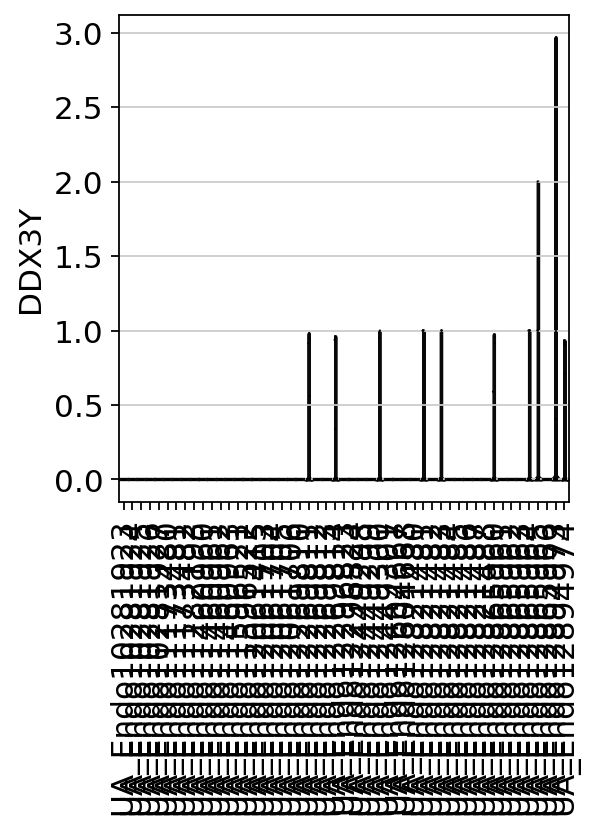

In [24]:
sc.pl.violin(adata, ['DDX3Y'], groupby='library', rotation = 90) # MALE

## General summaries

In [25]:
adata.obs['library'].values.describe()
adata.obs['Library_genotype'].values.describe()

,counts,freqs
categories,,
UA_Endo10281923_FX1101,9282,0.010889
UA_Endo10281924_FX1101,23816,0.027938
UA_Endo10281925_FX1101,24774,0.029062
UA_Endo10281926_FX1101,18927,0.022203
UA_Endo10281927_FX1101,21127,0.024784
...,...,...
UA_Endo12894973_FX9017,1410,0.001654
UA_Endo12894973_doublet,490,0.000575
UA_Endo12894974_FX9009,12983,0.015230


### Filter cells with few genes
Check number of genes per cell distribution and filter cells accordingly

UA_Endo11460962
UA_Endo12061703
UA_Endo12865963
UA_Endo12821486
UA_Endo12269813
UA_Endo12449301
UA_Endo11173480
UA_Endo10281924
UA_Endo12821487
UA_Endo12269814
UA_Endo11282193
UA_Endo12061415
UA_Endo12821485
UA_Endo10281925
UA_Endo11596522
UA_Endo12269812
UA_Endo12821488
UA_Endo12061705
UA_Endo11460963
UA_Endo11460961
UA_Endo12894973
UA_Endo12821483
UA_Endo12449299
UA_Endo12449298
UA_Endo10281927
UA_Endo11173481
UA_Endo12821484
UA_Endo12269811
UA_Endo12449300
UA_Endo12821480
UA_Endo11596521
UA_Endo10281926
UA_Endo12821481
UA_Endo12604667
UA_Endo11460960
UA_Endo12865965
UA_Endo12865966
UA_Endo12061704
UA_Endo12894974
UA_Endo12296823
UA_Endo12061706
UA_Endo12604668
UA_Endo12865961
UA_Endo11173482
UA_Endo12821482
UA_Endo12269810
UA_Endo12296824
UA_Endo12865960
UA_Endo12865964
UA_Endo12865962
UA_Endo10281923
UA_Endo12449300_EX0045


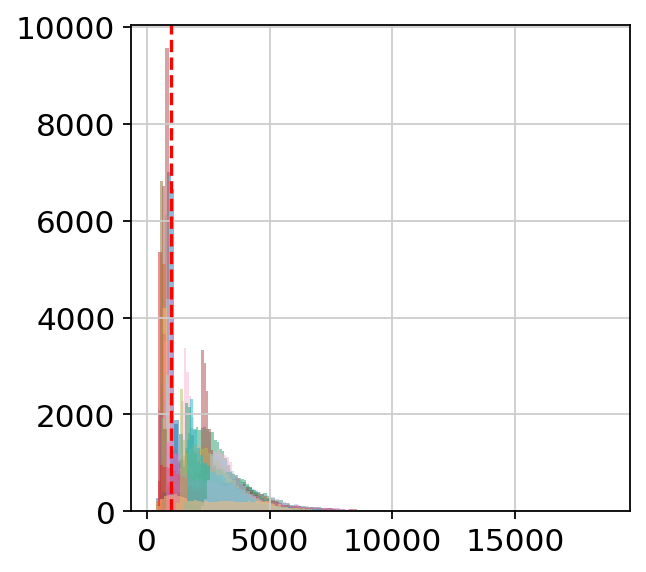

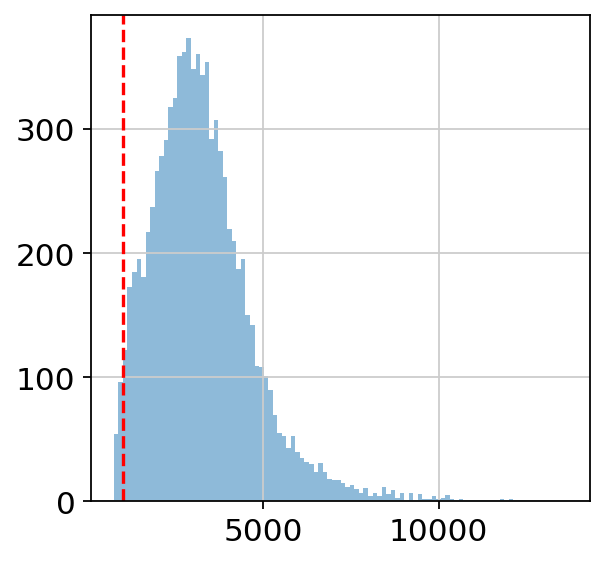

UA_Endo12269811_doublet


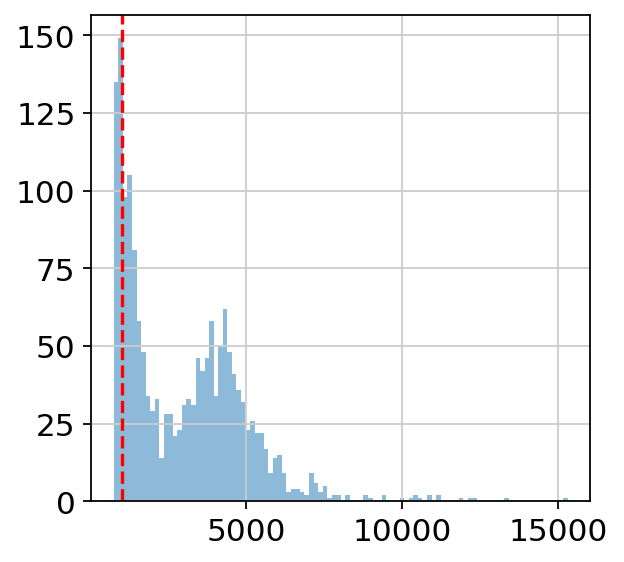

UA_Endo12821485_FX0065


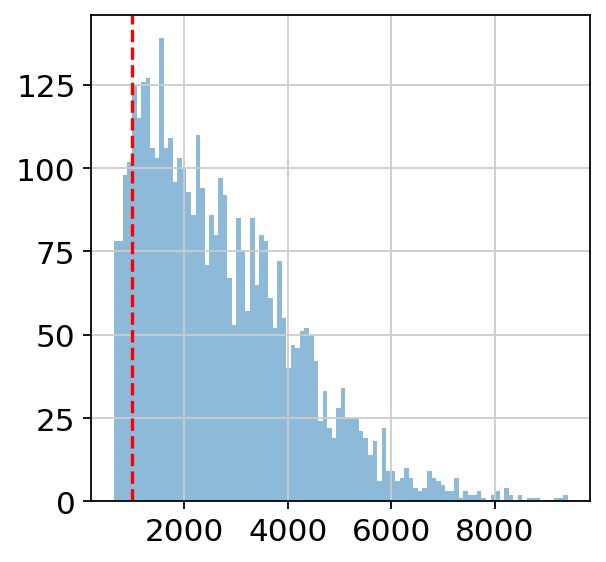

UA_Endo11173481_FX9022


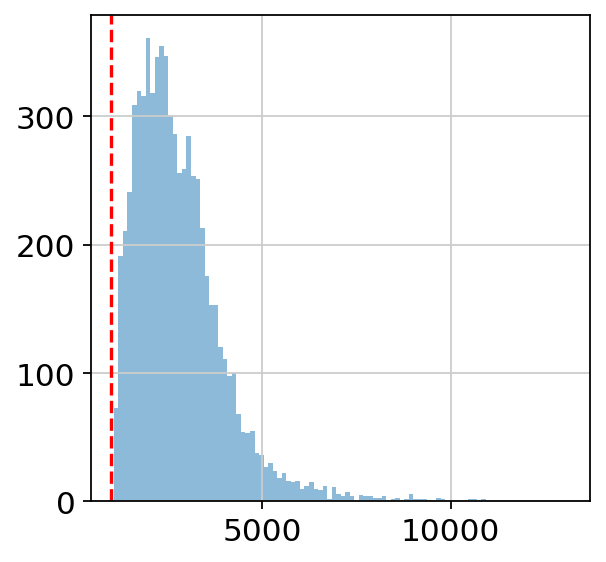

UA_Endo12269811_unassigned


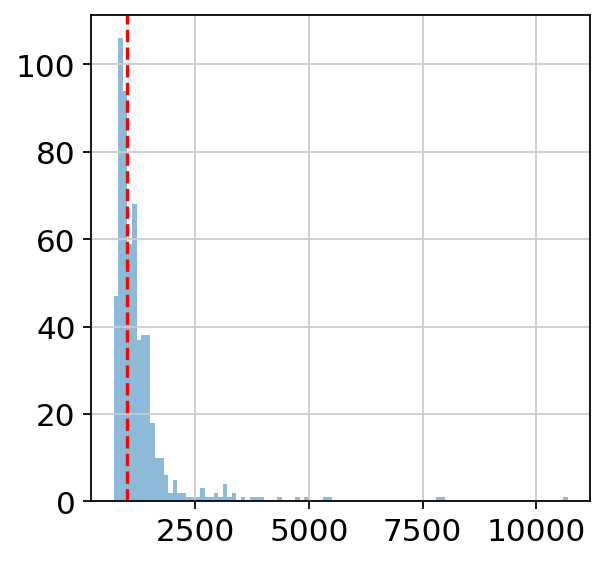

UA_Endo10281924_FX1101


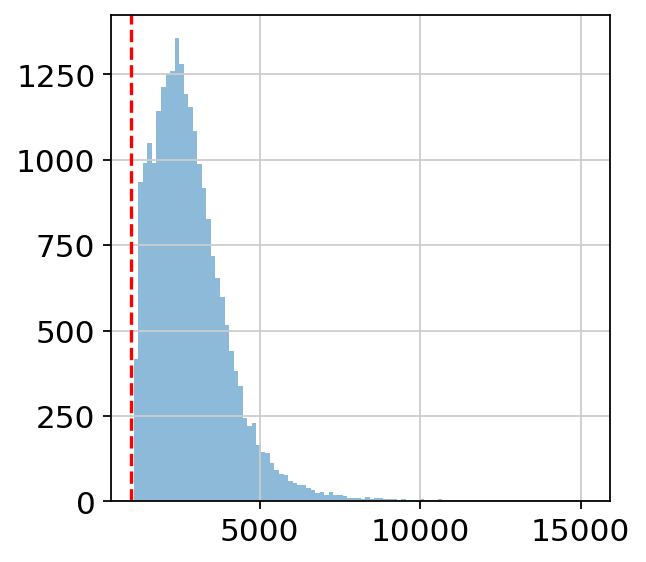

UA_Endo12269814_doublet


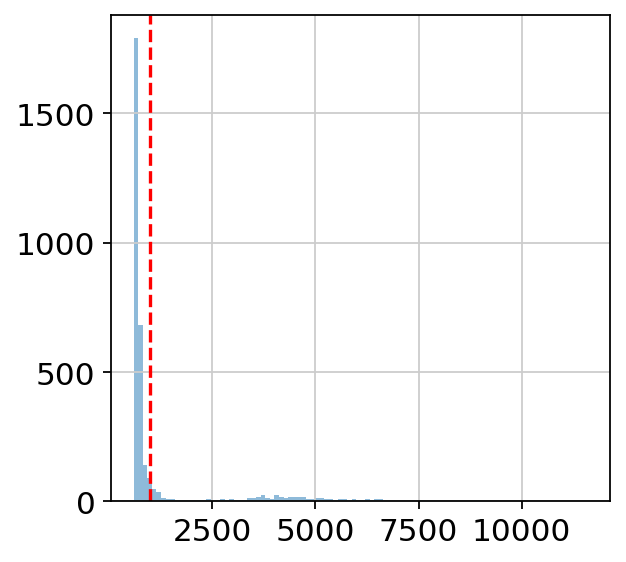

UA_Endo12449301_doublet


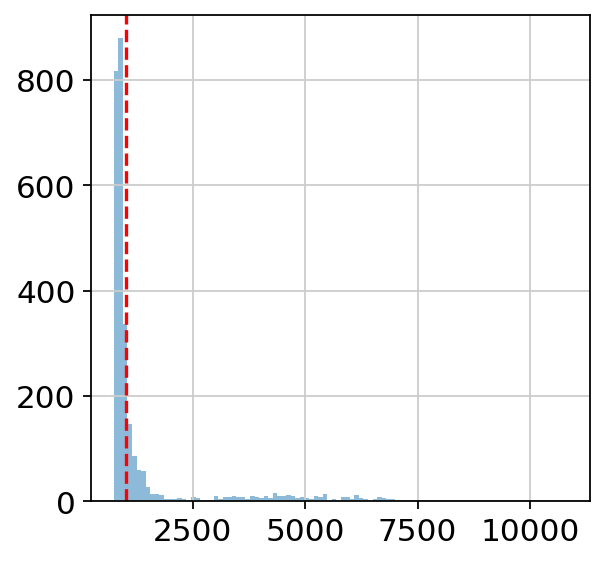

UA_Endo12604668_FX9016


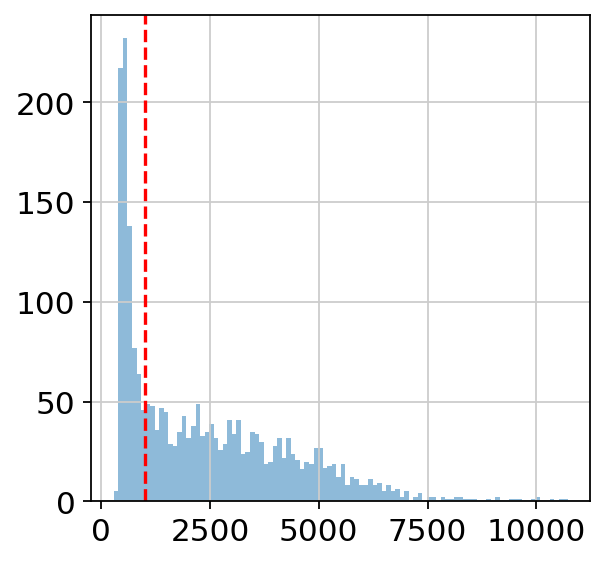

UA_Endo12865964_unassigned


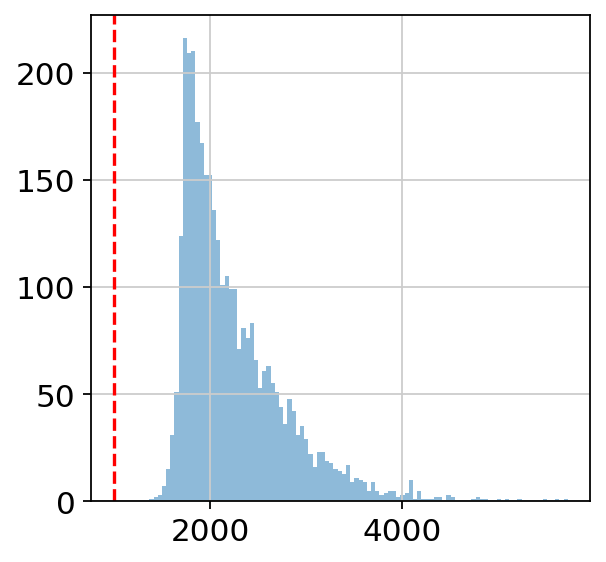

UA_Endo12269813_FX9001


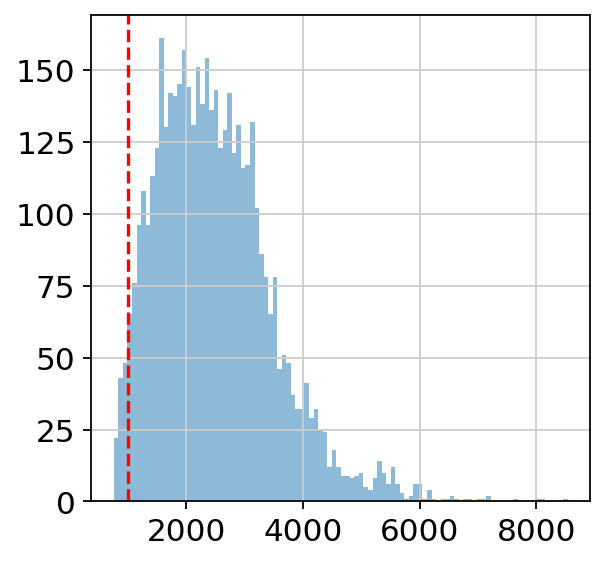

UA_Endo12449299_unassigned


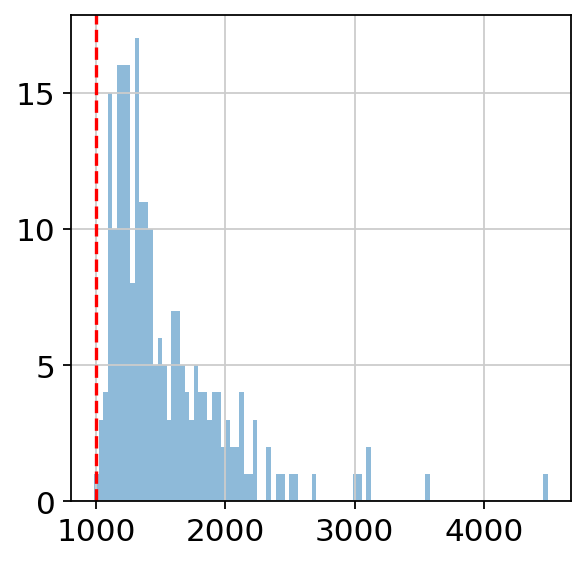

UA_Endo12269811_FX0022


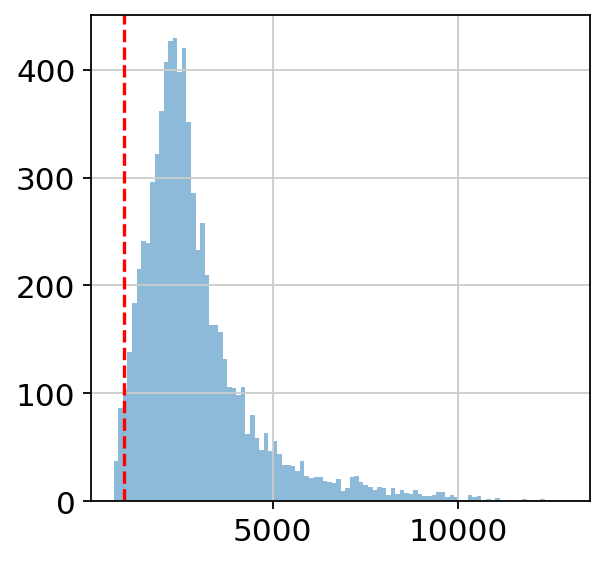

UA_Endo12821480_FX1122


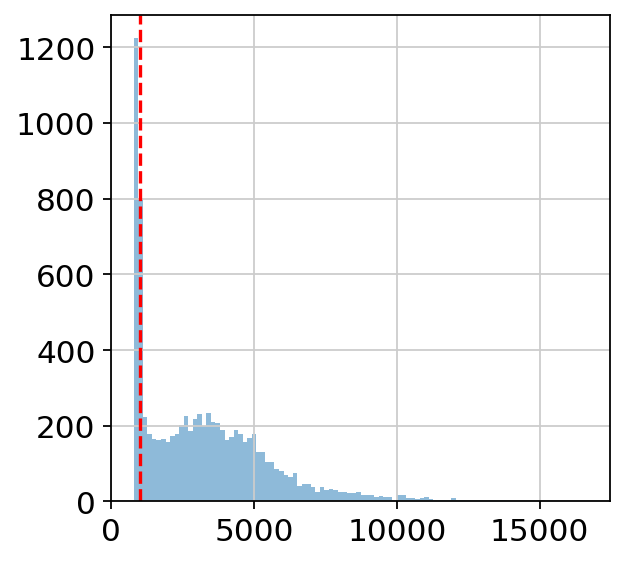

UA_Endo12821488_FX9018


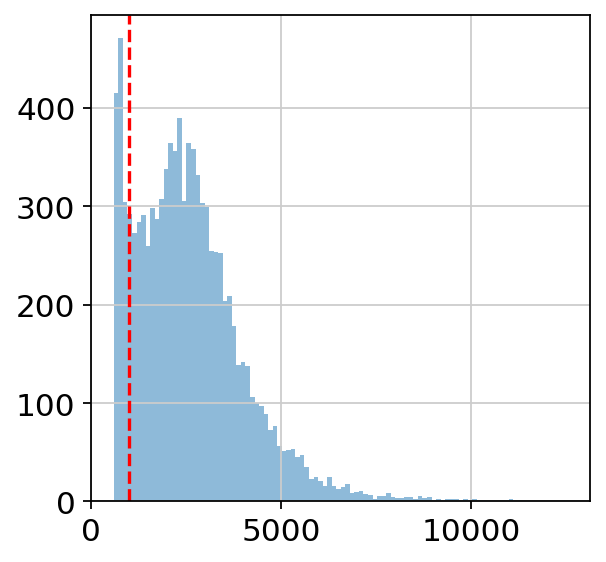

UA_Endo11460961_doublet


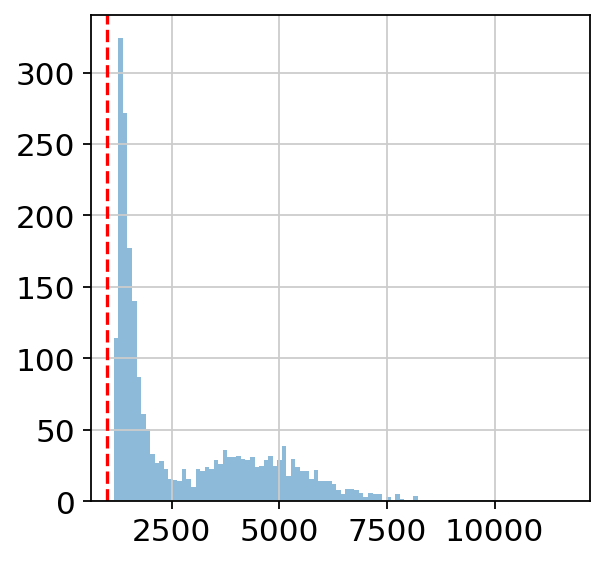

UA_Endo12061706_FX1176


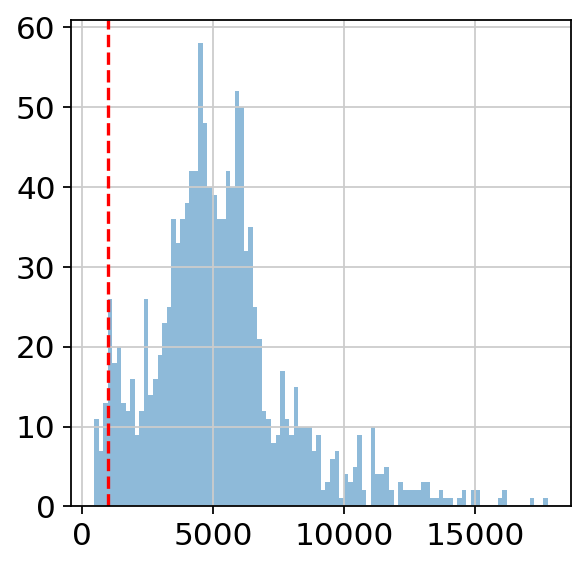

UA_Endo12865962_FX1236


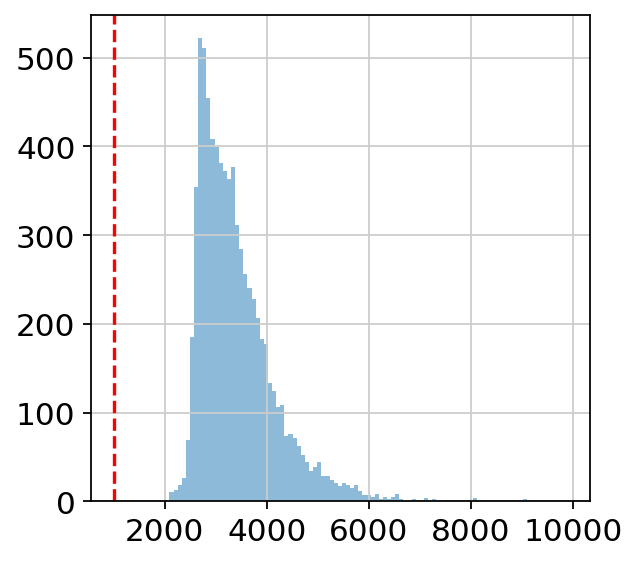

UA_Endo12894974_doublet


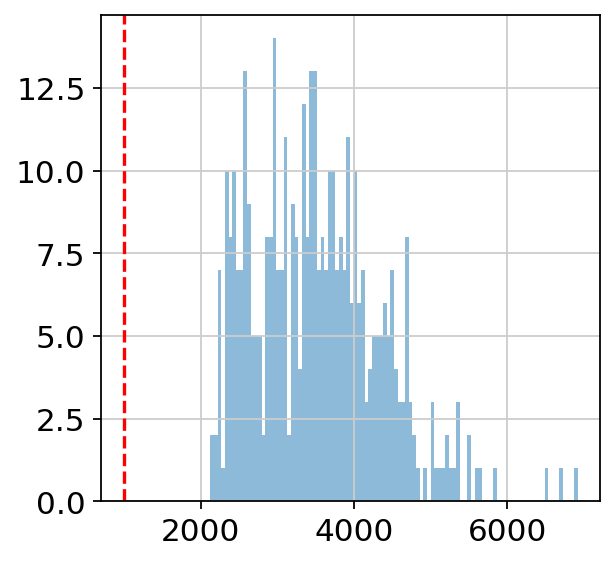

UA_Endo12296823_FX1119


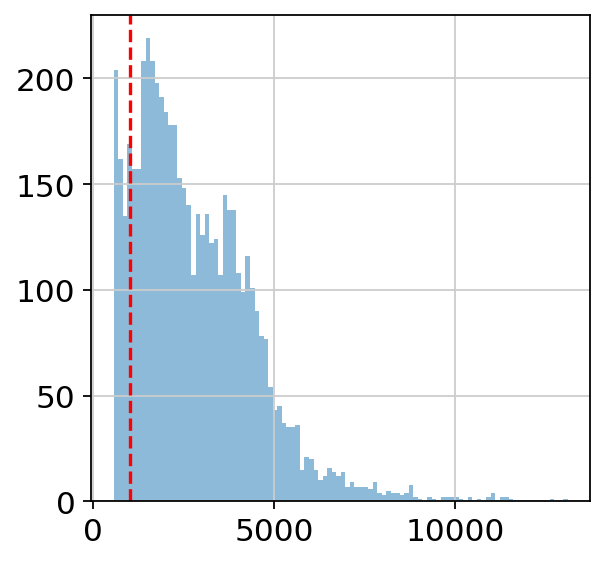

UA_Endo10281927_FX1101


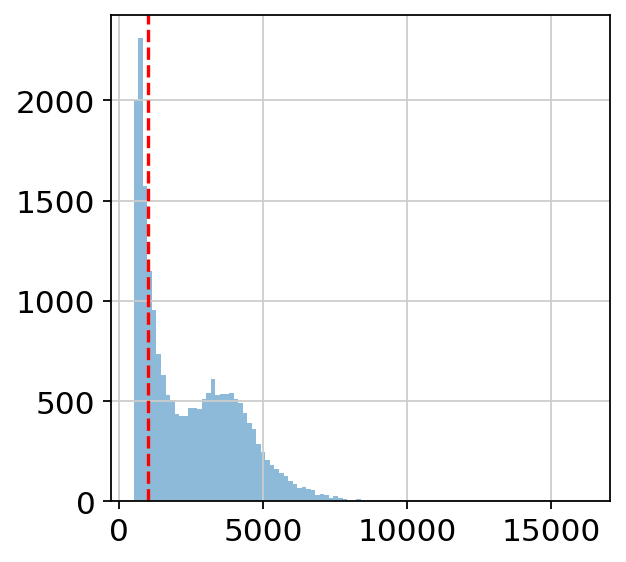

UA_Endo12061415_unassigned


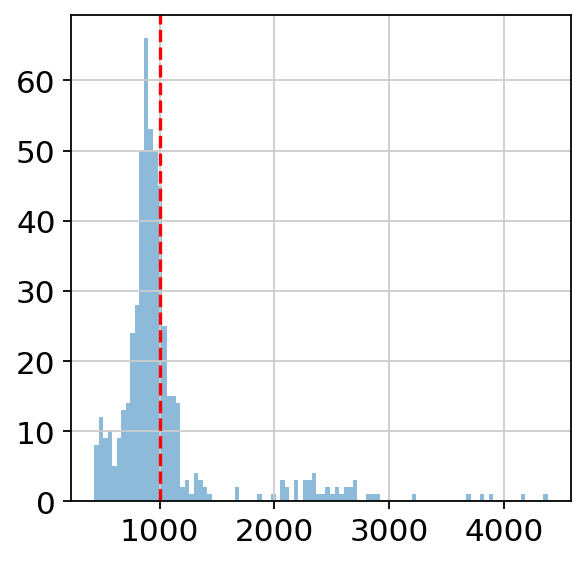

UA_Endo12061415_FX1223


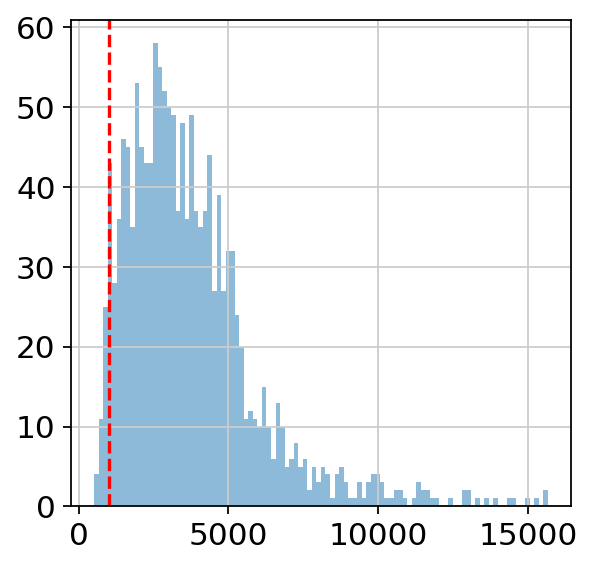

UA_Endo11173480_doublet


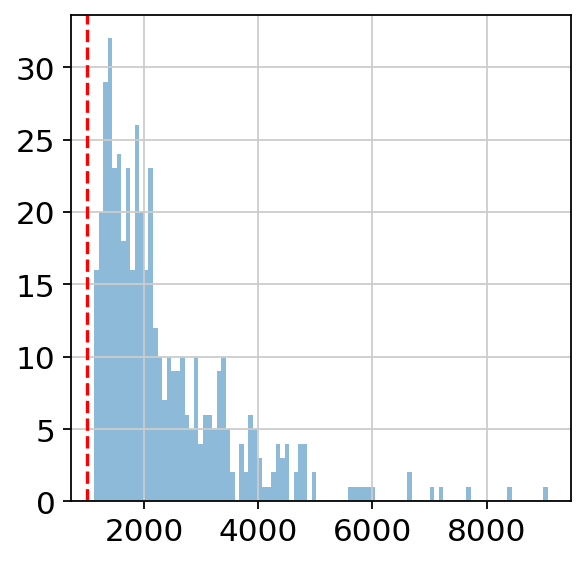

UA_Endo12269810_unassigned


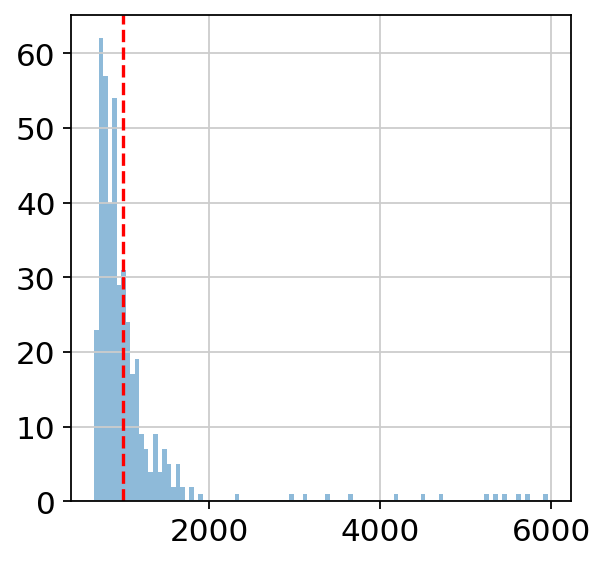

UA_Endo11282193_FX1146


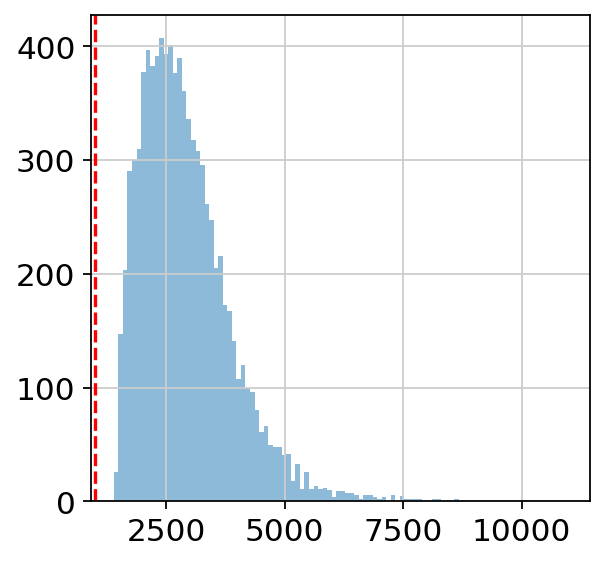

UA_Endo12269814_EX0789


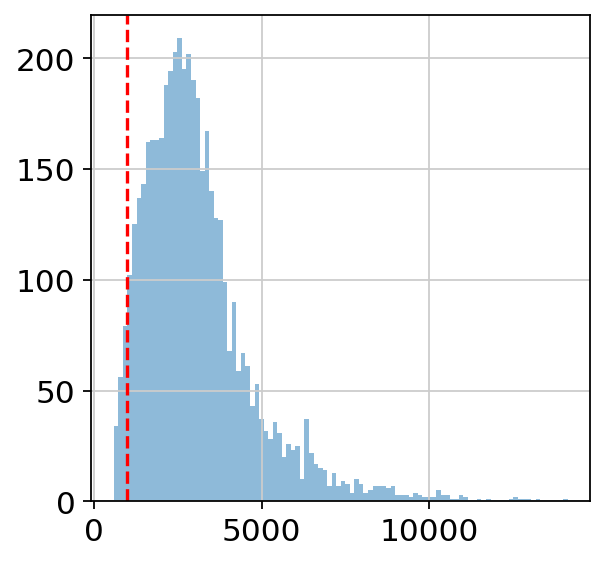

UA_Endo12865961_doublet


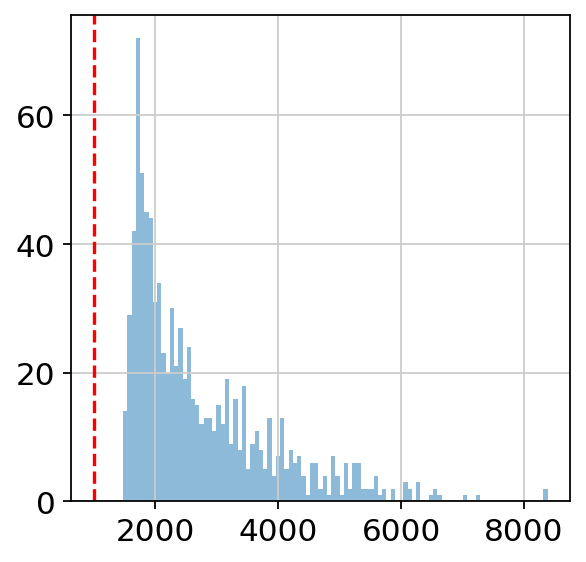

UA_Endo11596522_FX1104


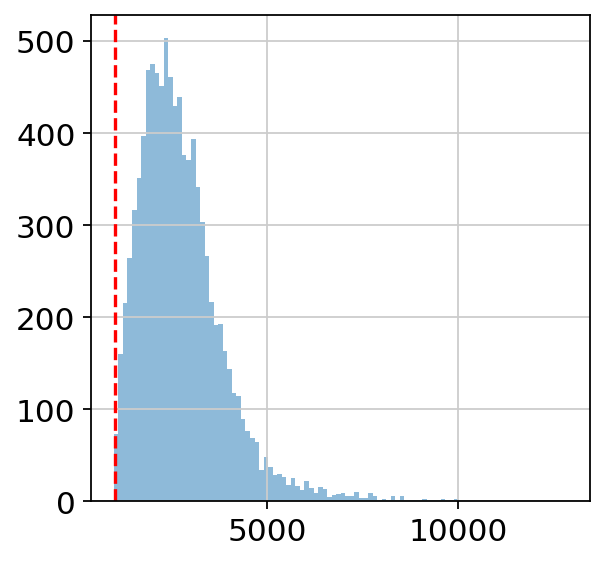

UA_Endo12865964_doublet


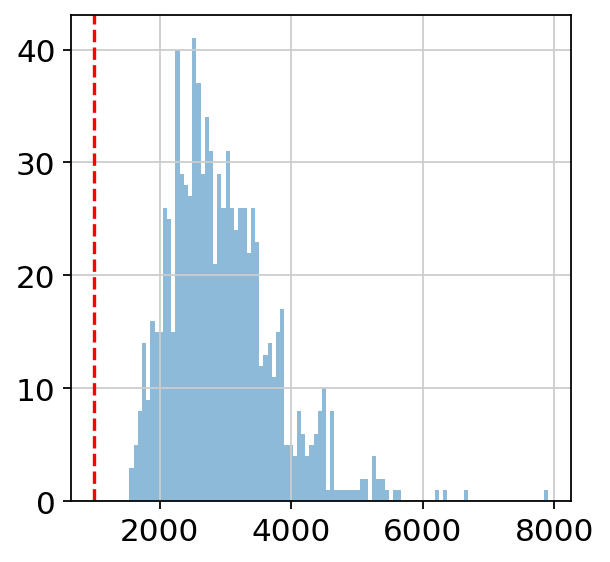

UA_Endo12865965_unassigned


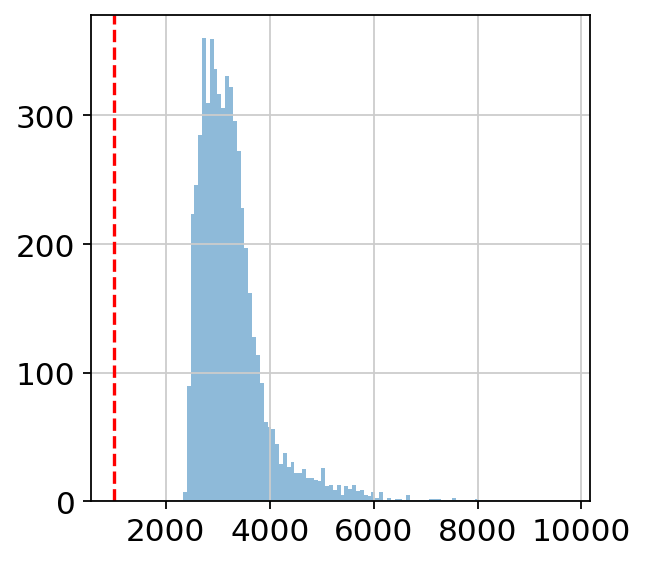

UA_Endo12821480_FX1074


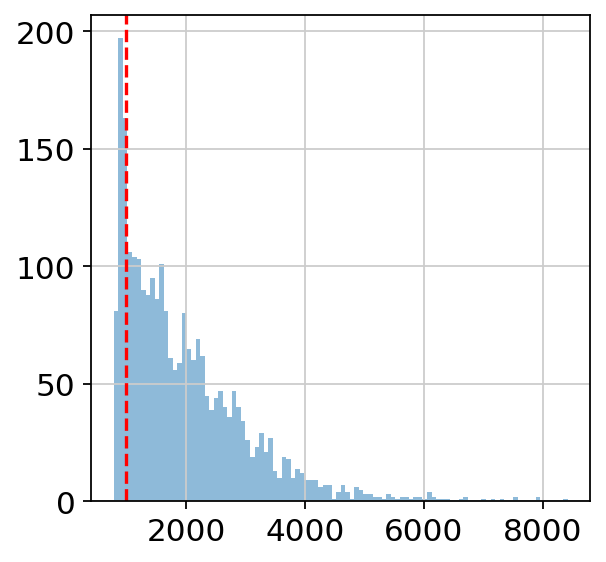

UA_Endo12296823_unassigned


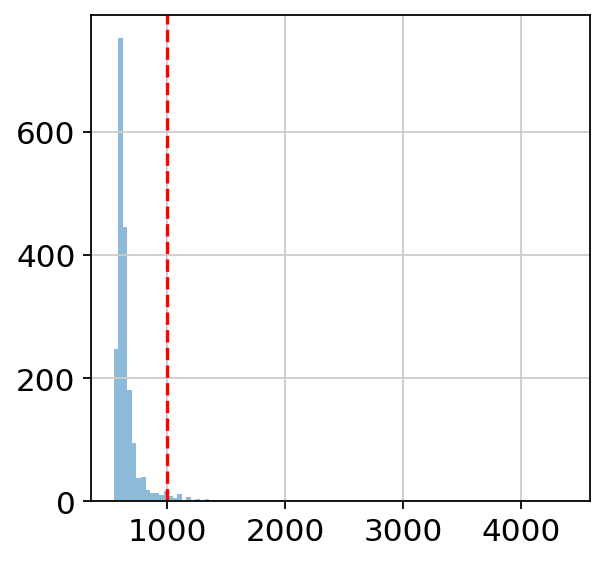

UA_Endo12061706_unassigned


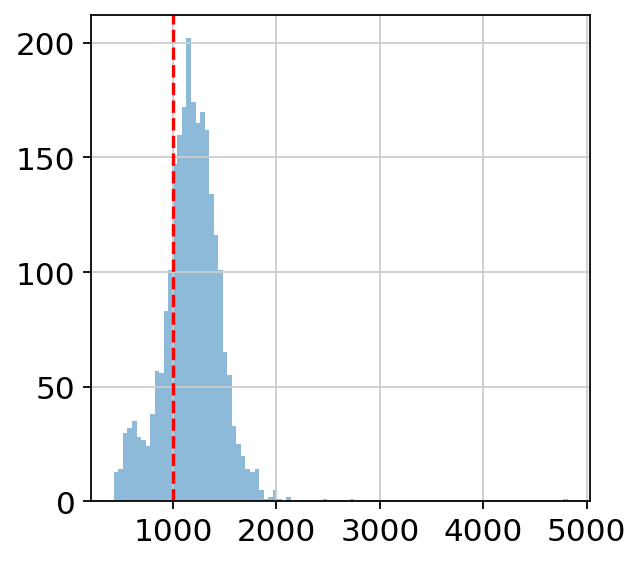

UA_Endo12061415_doublet


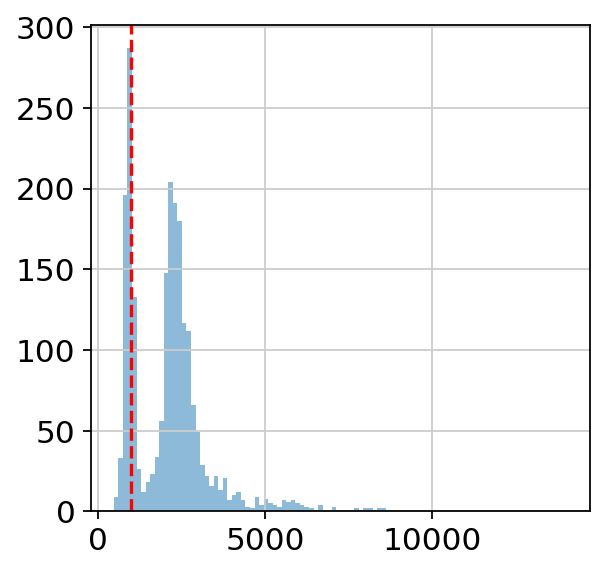

UA_Endo12061705_doublet


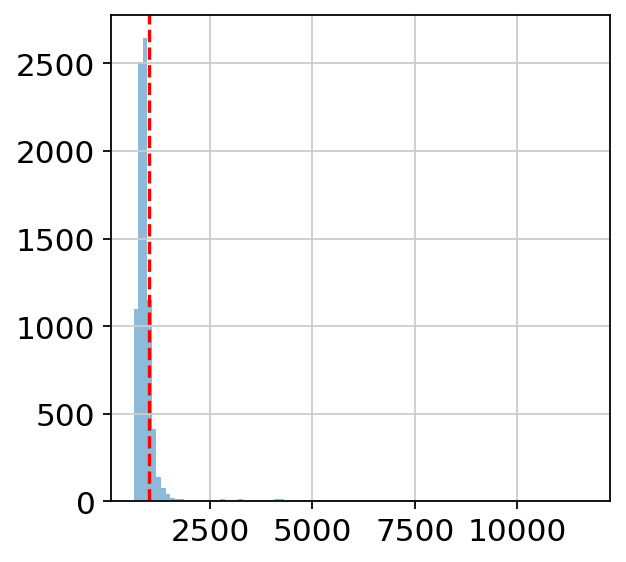

UA_Endo12865961_unassigned


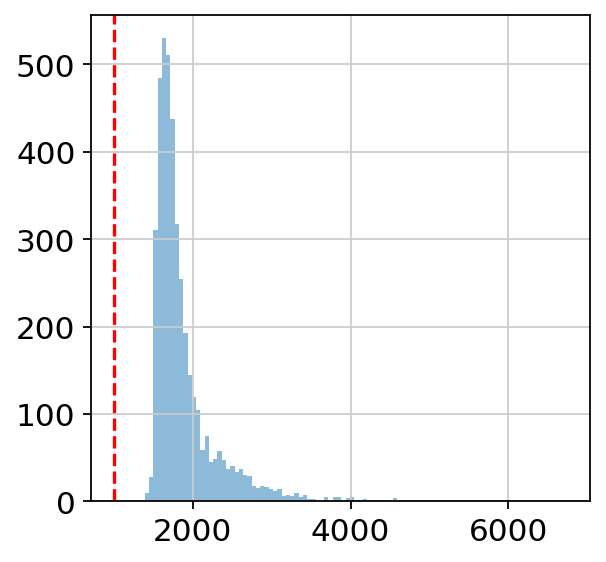

UA_Endo12865961_FX9014


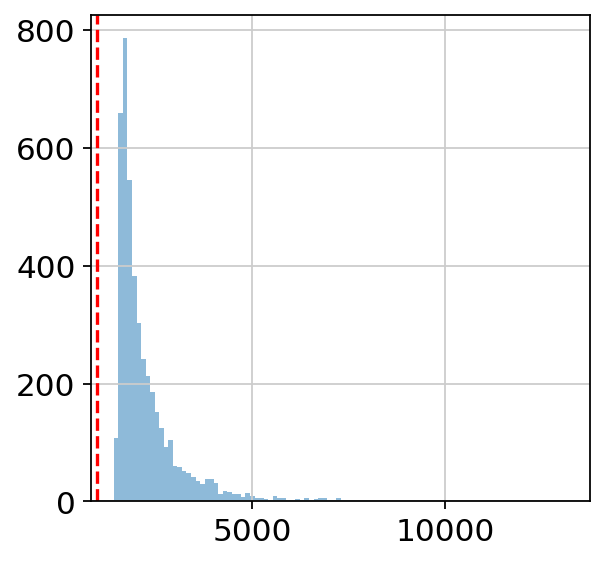

UA_Endo12269812_doublet


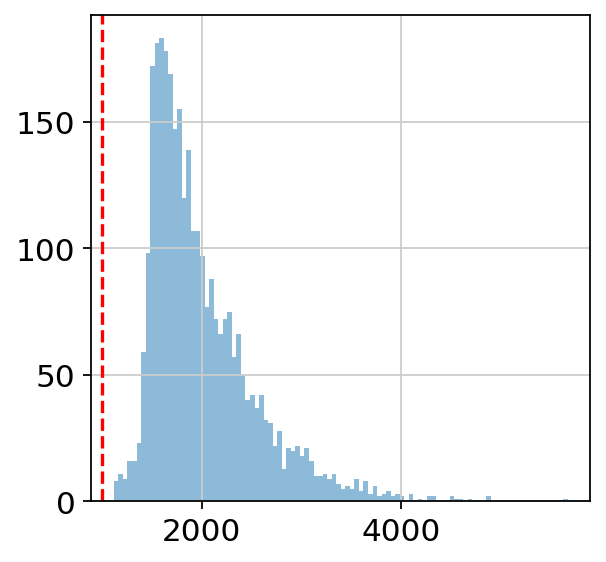

UA_Endo12865964_FX1215


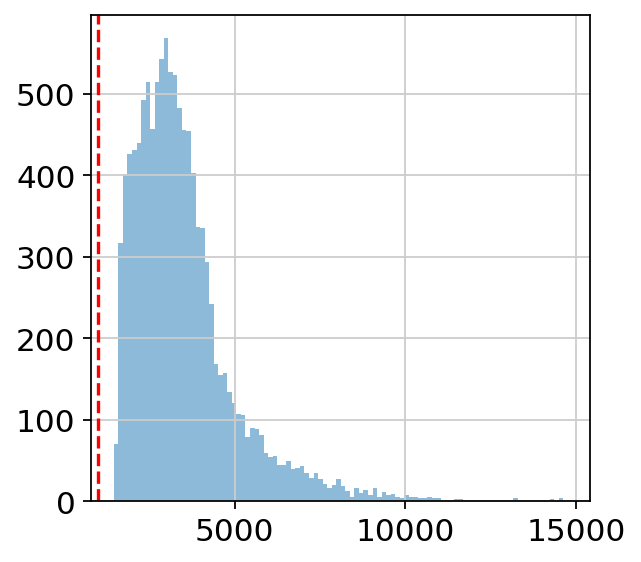

UA_Endo11173481_doublet


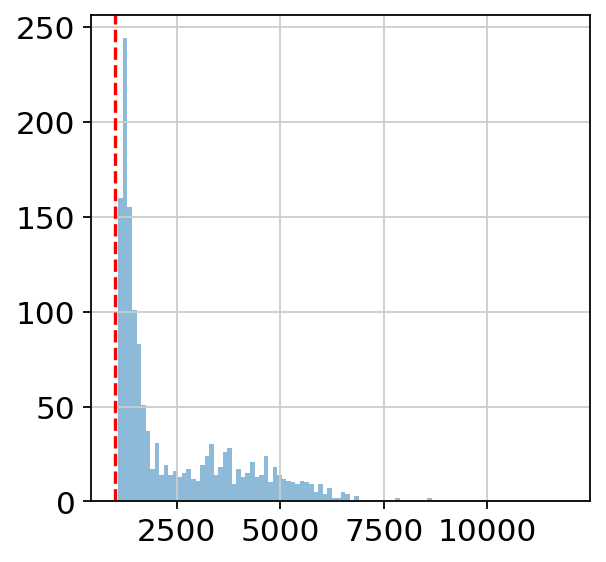

UA_Endo10281923_FX1101


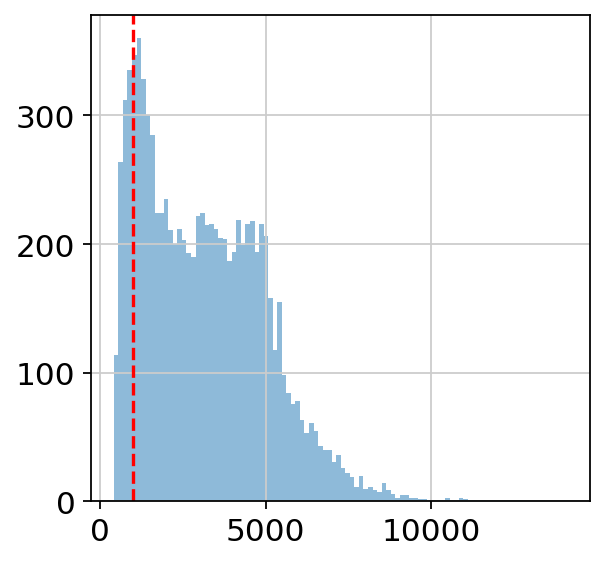

UA_Endo12865965_doublet


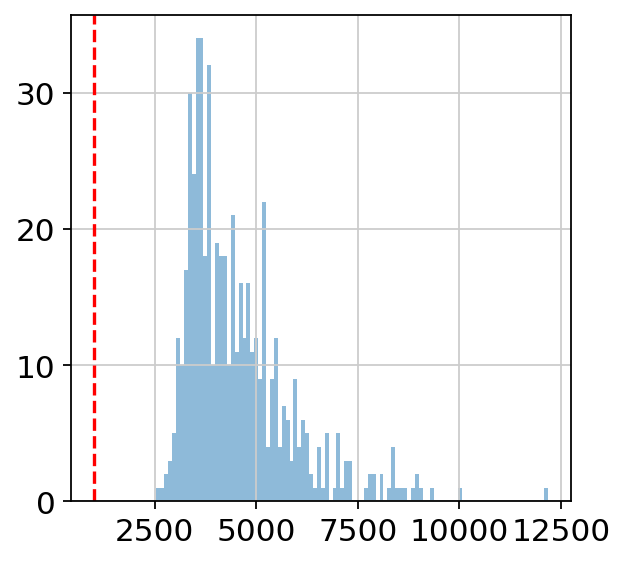

UA_Endo12821481_doublet


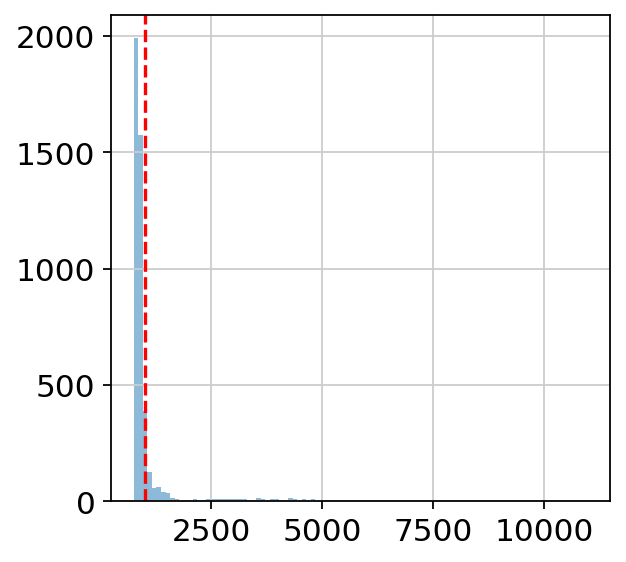

UA_Endo12449300_doublet


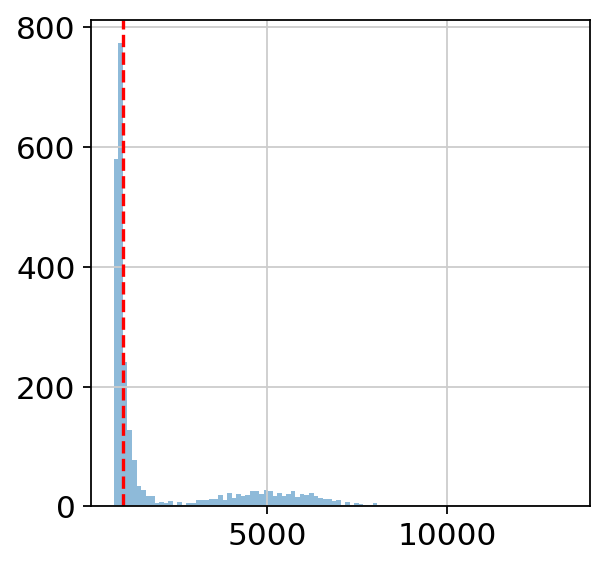

UA_Endo11282193_doublet


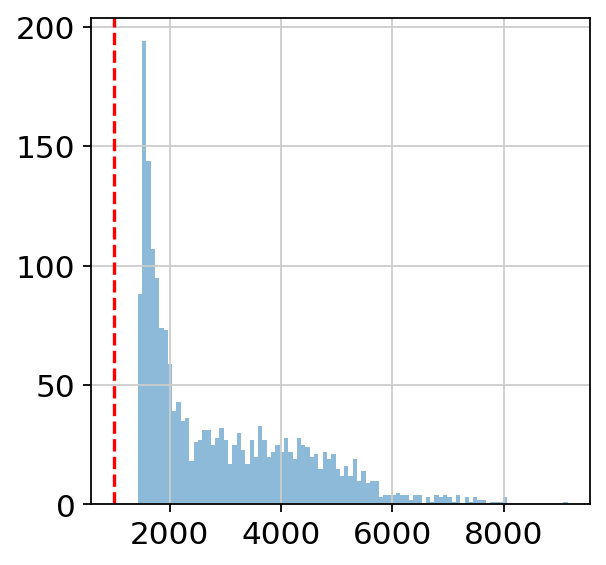

UA_Endo12449298_unassigned


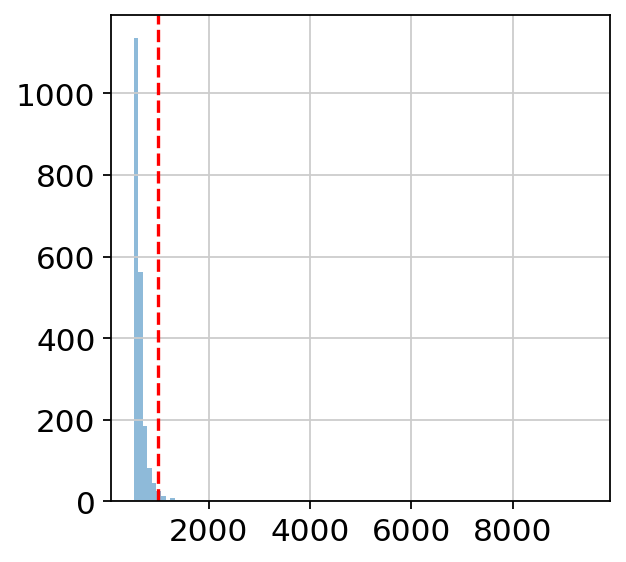

UA_Endo12865960_FX1170


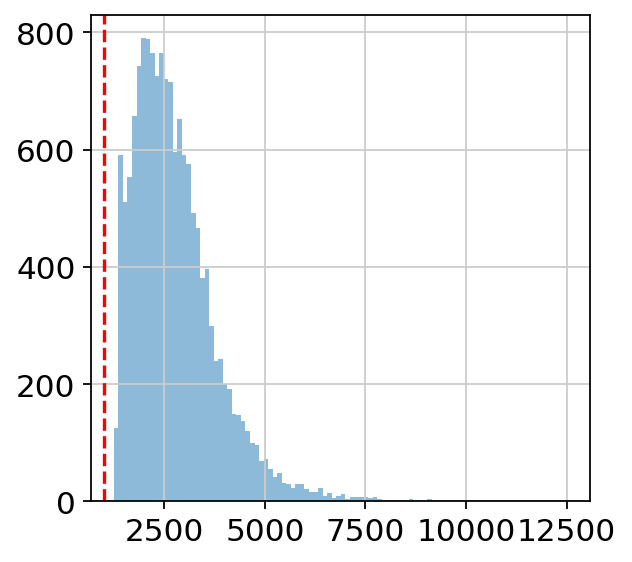

UA_Endo12894973_doublet


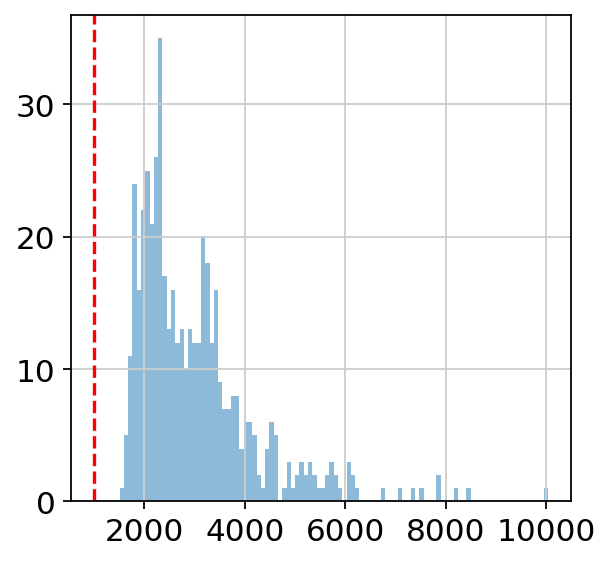

UA_Endo12269813_unassigned


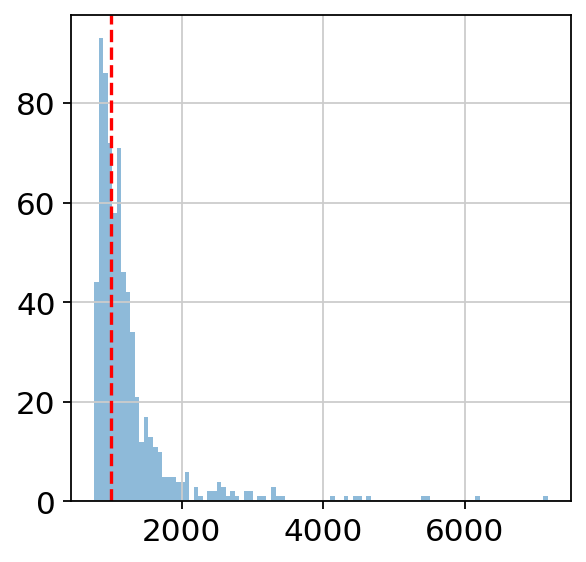

UA_Endo11173481_unassigned


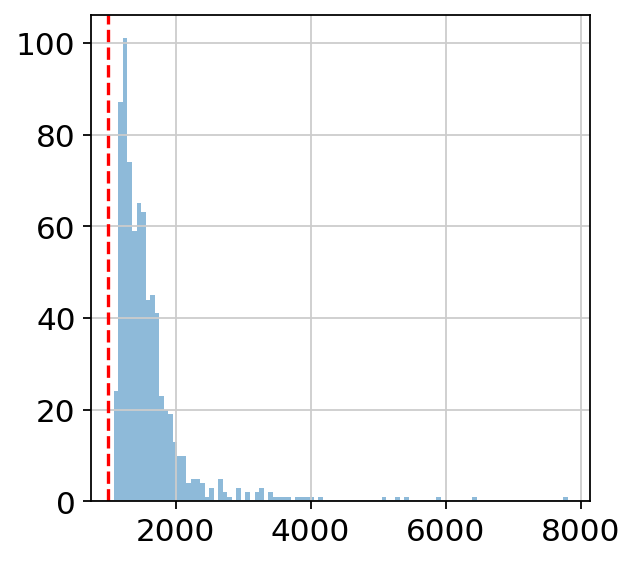

UA_Endo11173482_FX9011


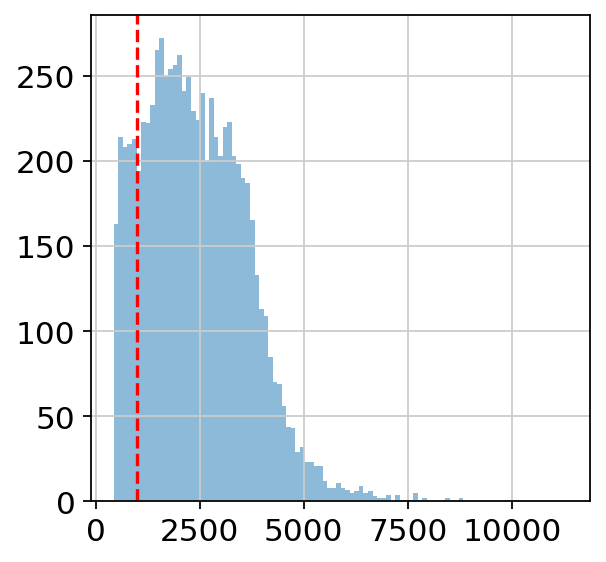

UA_Endo12269810_FX1106


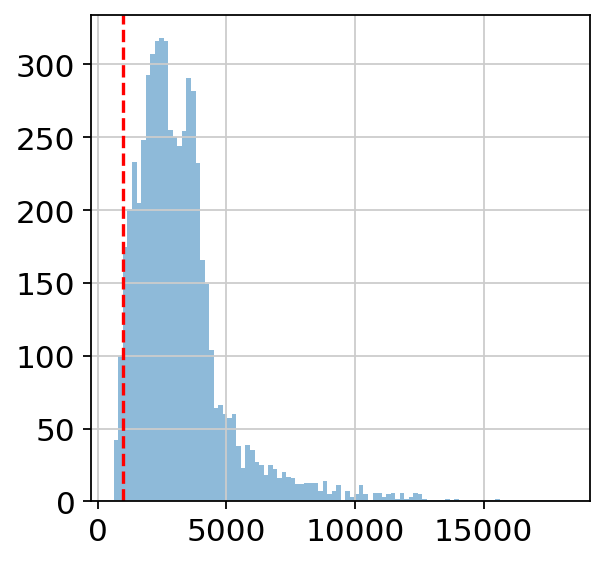

UA_Endo11173482_FX1087


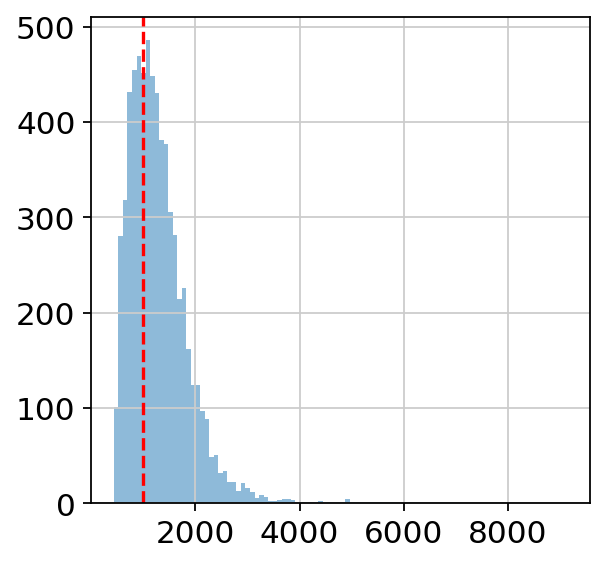

UA_Endo11173482_unassigned


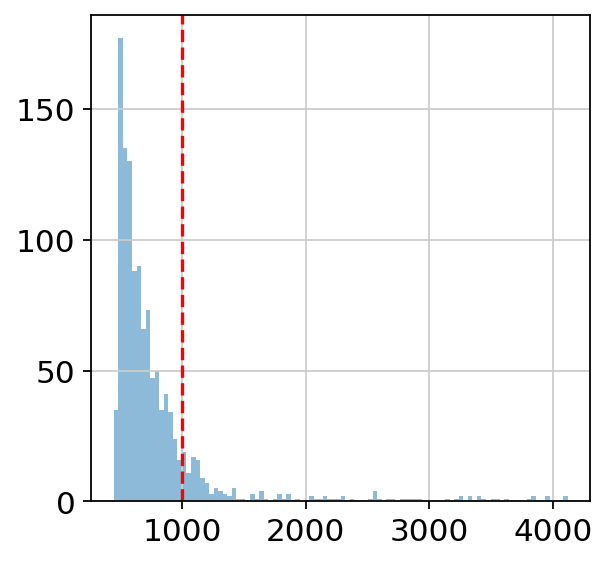

UA_Endo12449299_EX0288


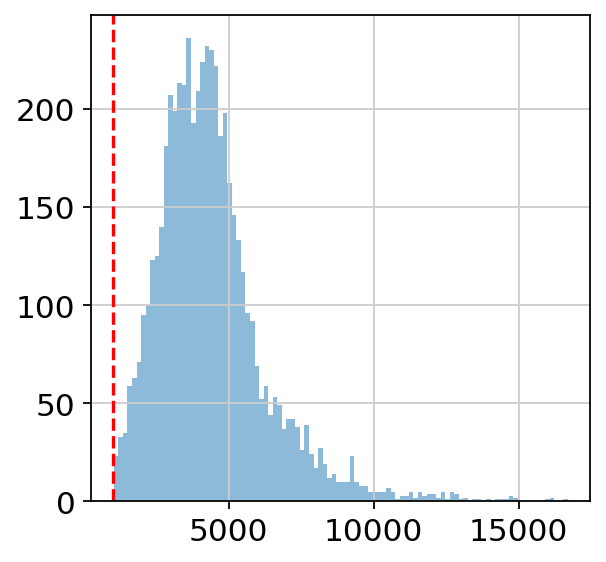

UA_Endo12604667_doublet


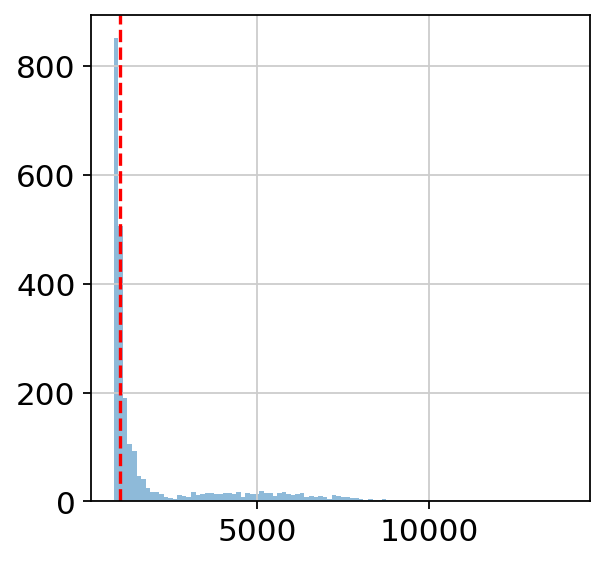

UA_Endo12821484_FX9010


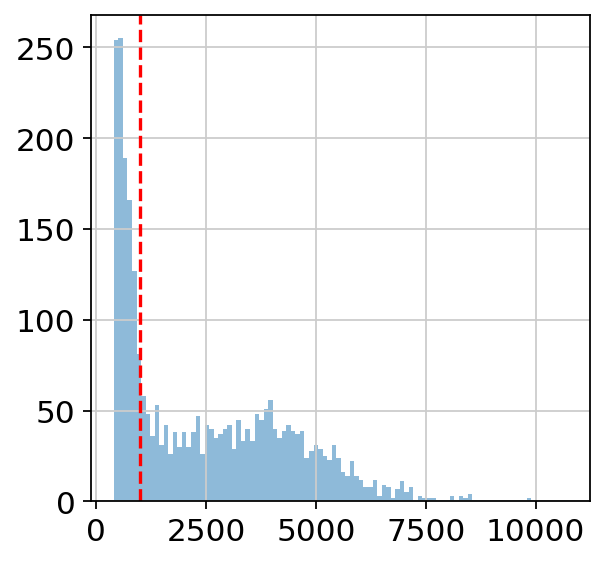

UA_Endo12865966_FX1176


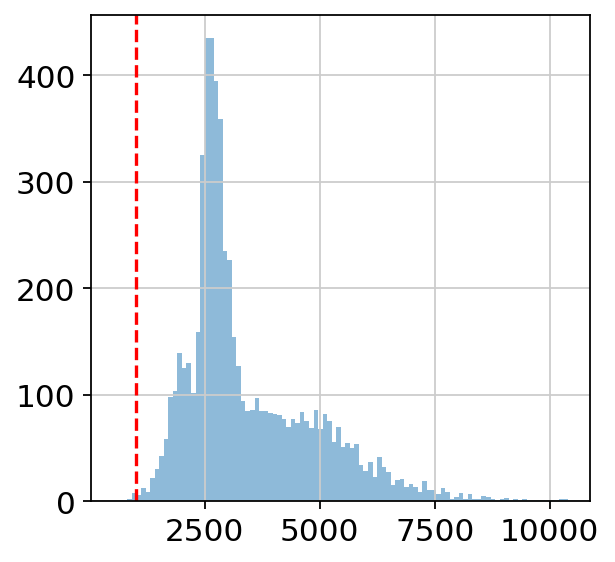

UA_Endo12269810_FX0033


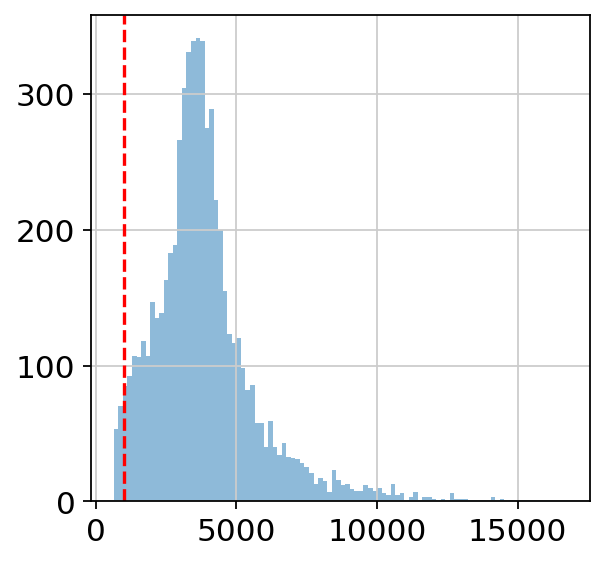

UA_Endo12865962_doublet


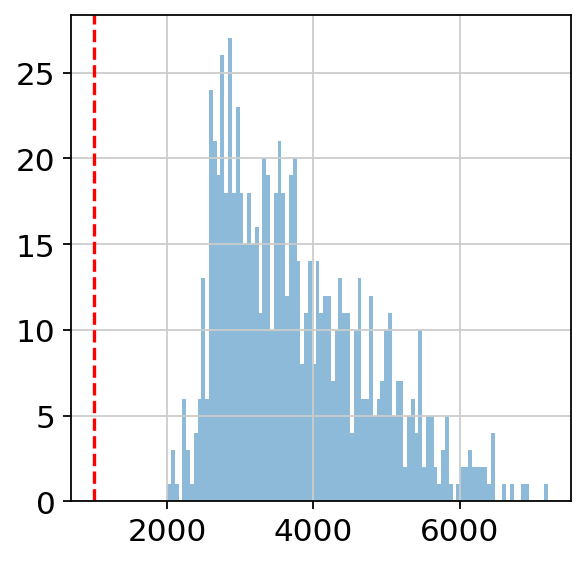

UA_Endo12061703_doublet


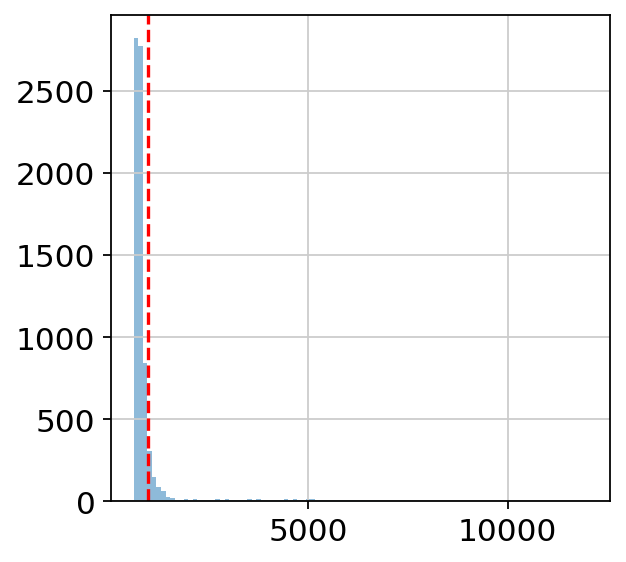

UA_Endo10281925_FX1101


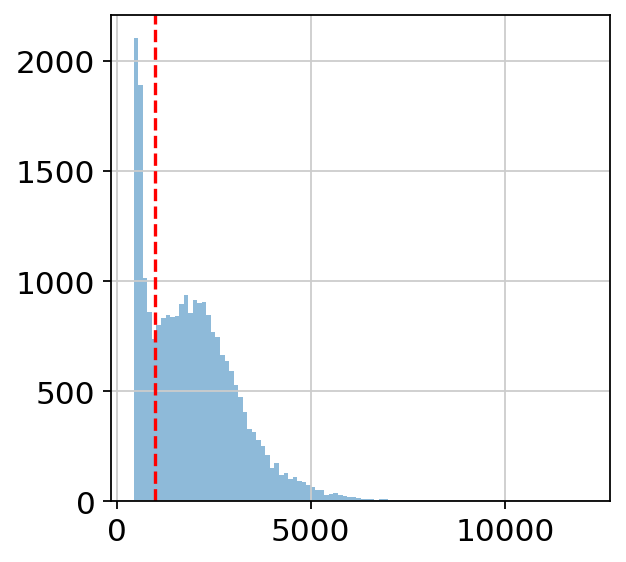

UA_Endo12894974_FX9009


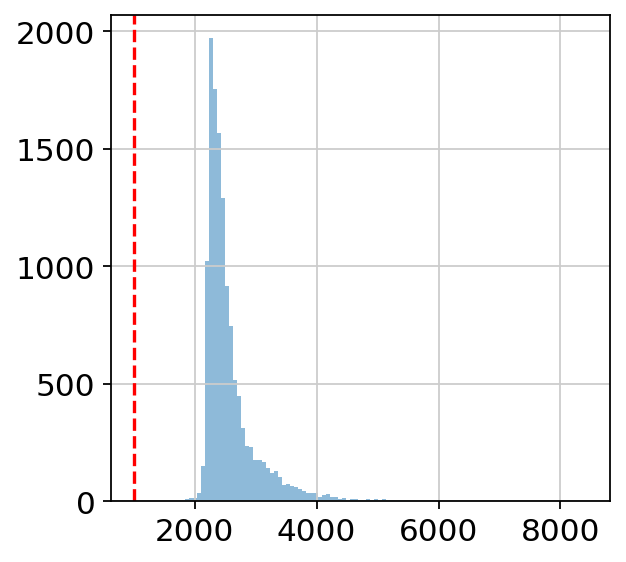

UA_Endo12061704_doublet


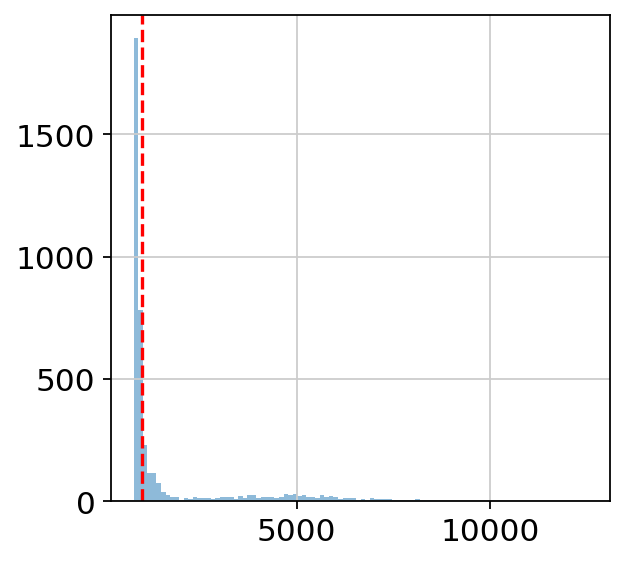

UA_Endo12894973_FX1158


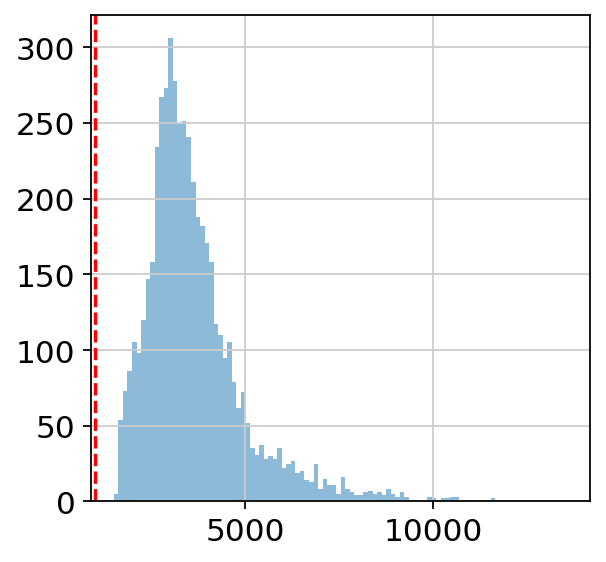

UA_Endo11460960_EX0366


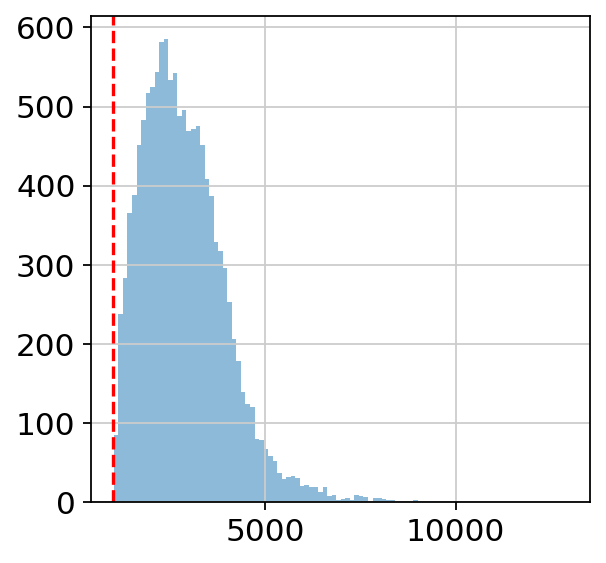

UA_Endo12269812_EX0661


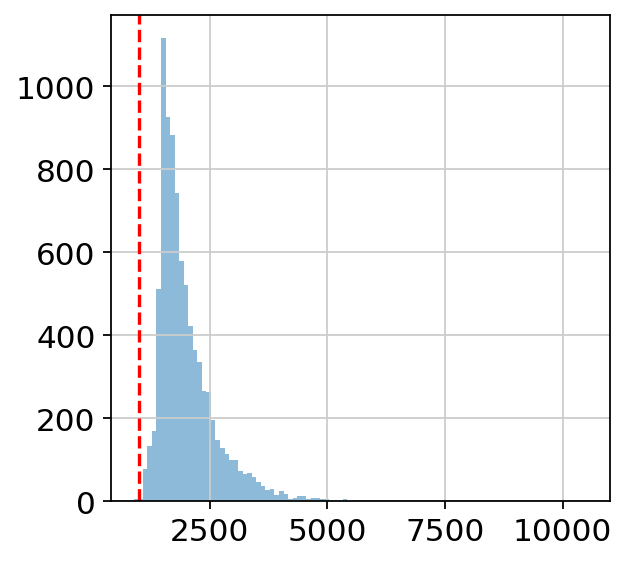

UA_Endo12449298_FX1160


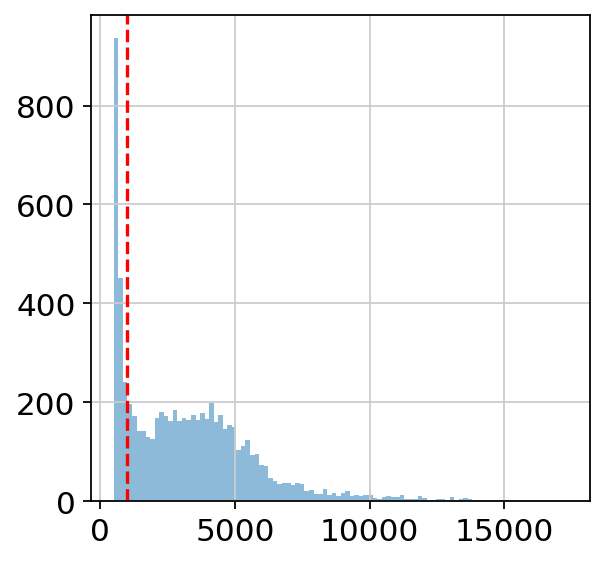

UA_Endo12604667_FX0028


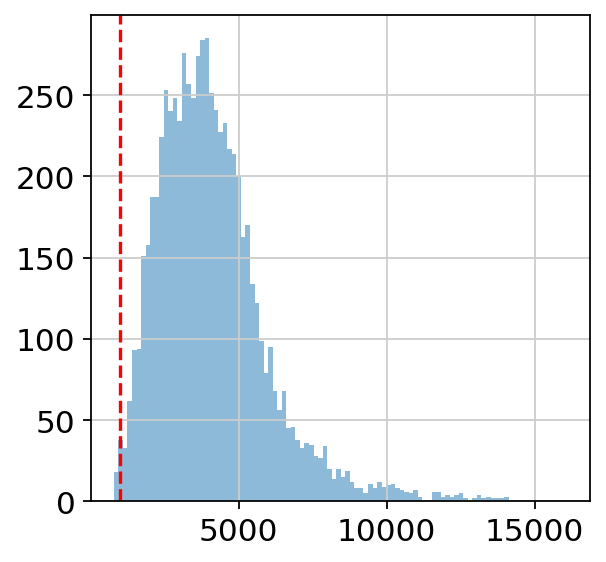

UA_Endo12865961_FX9006


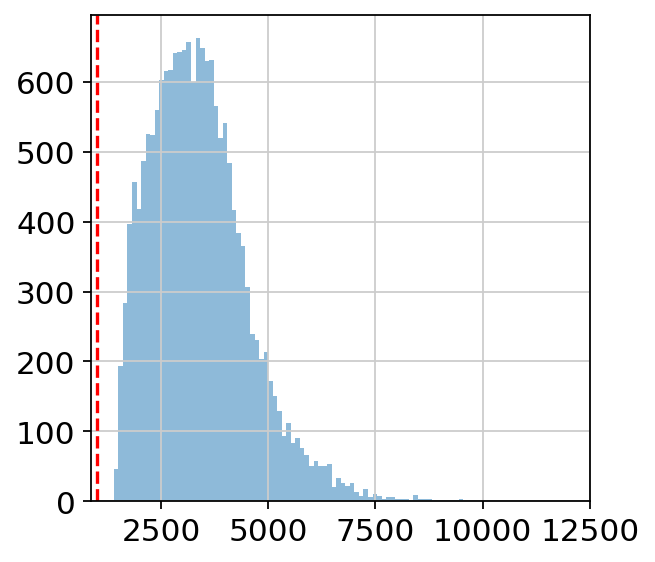

UA_Endo11173482_doublet


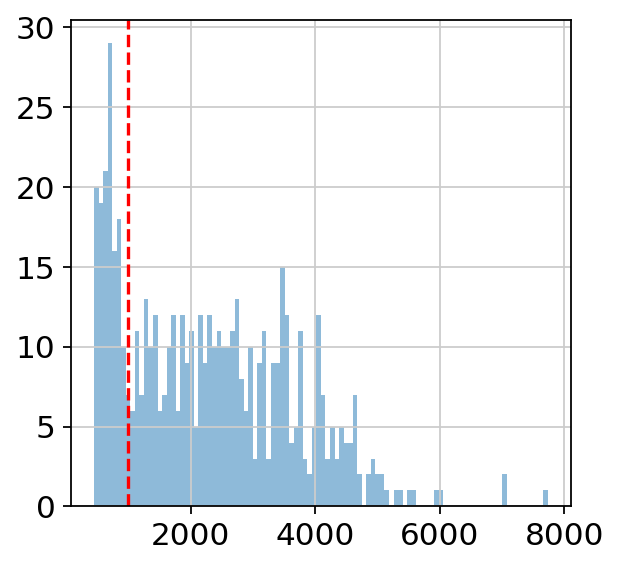

UA_Endo12821487_FX1191


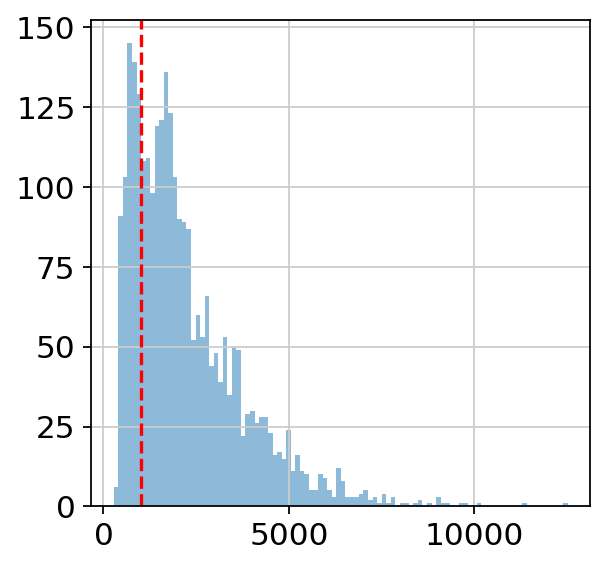

UA_Endo12449301_FX1136


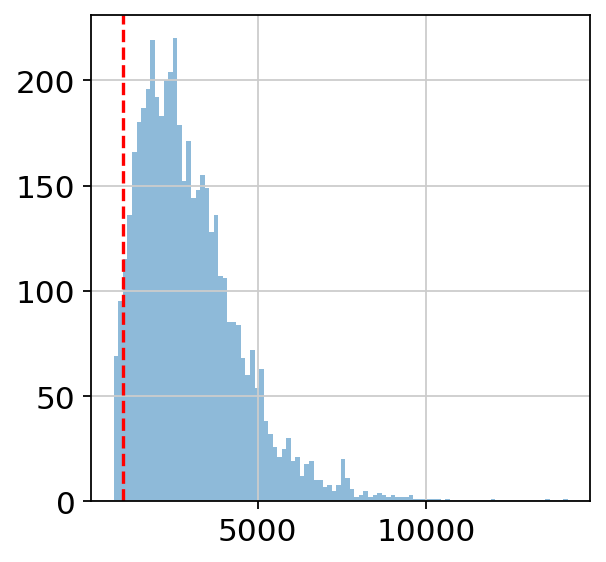

UA_Endo12061705_FX9009


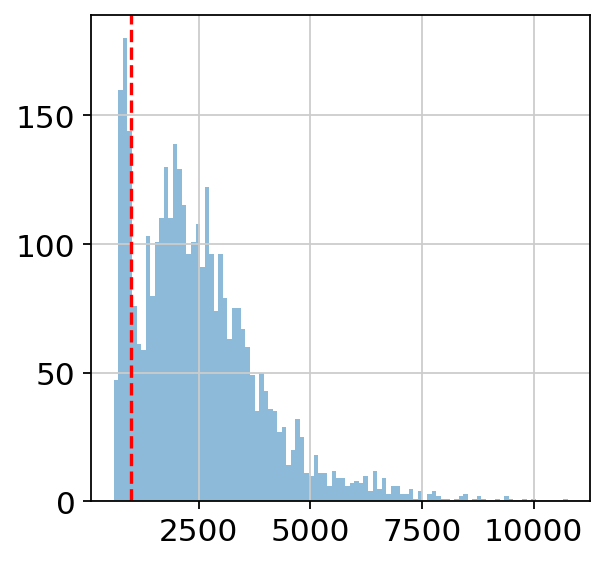

UA_Endo12269812_unassigned


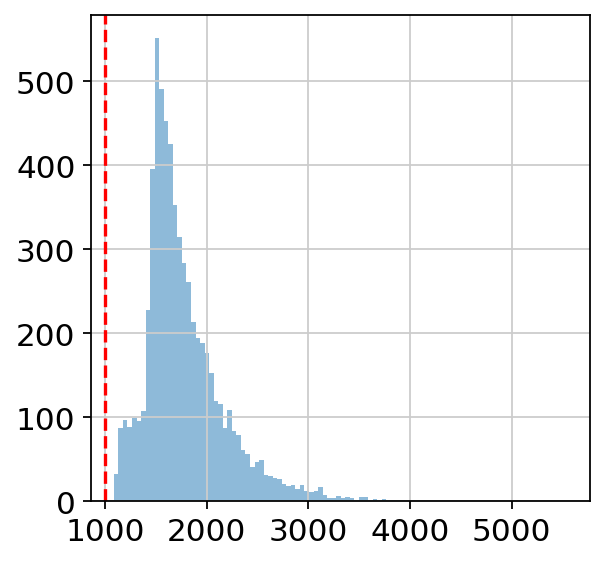

UA_Endo12296824_FX9008


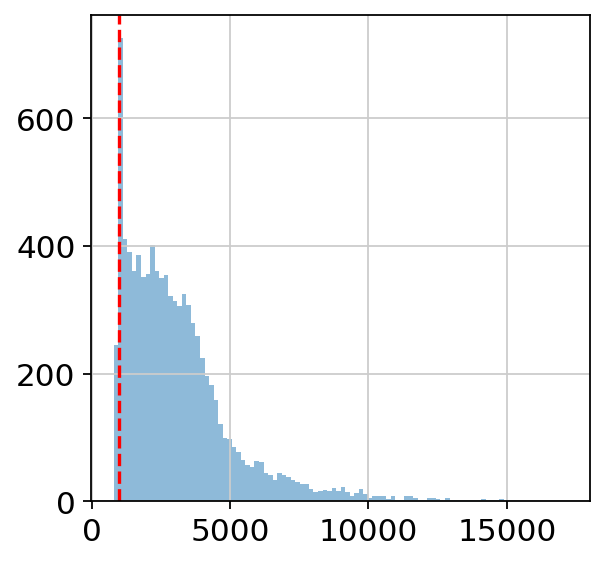

UA_Endo12865960_unassigned


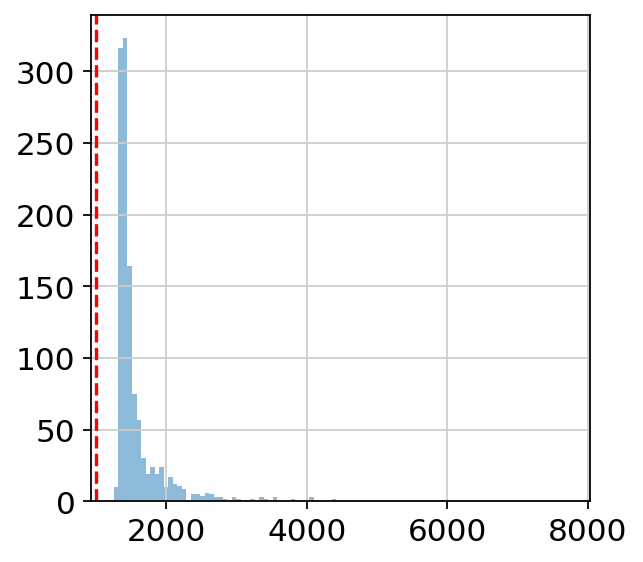

UA_Endo12865966_unassigned


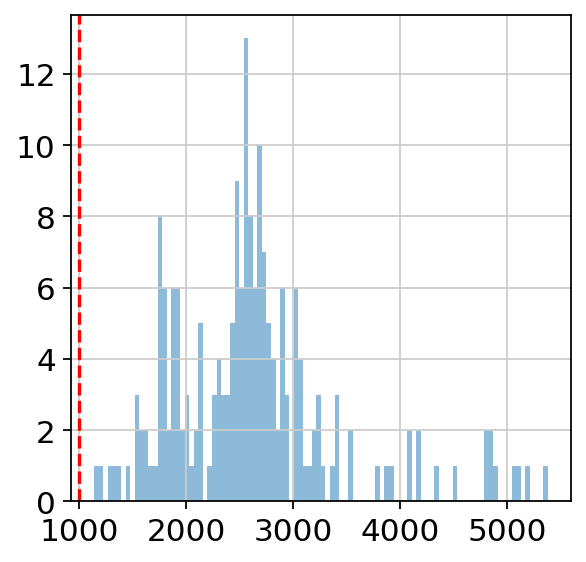

UA_Endo12821480_unassigned


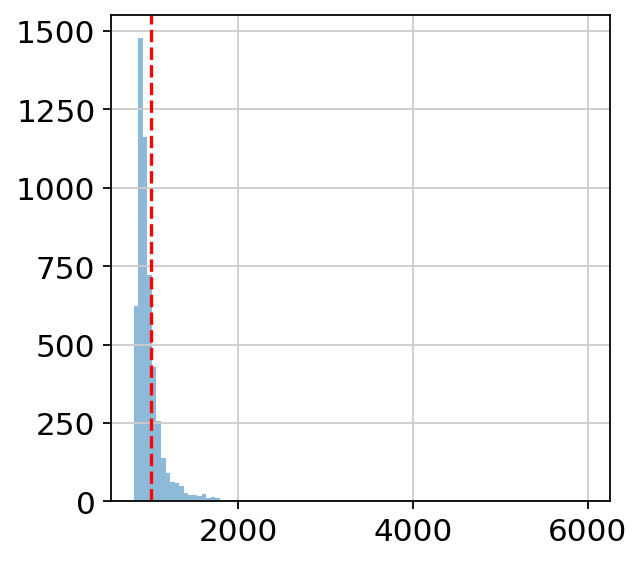

UA_Endo10281926_FX1101


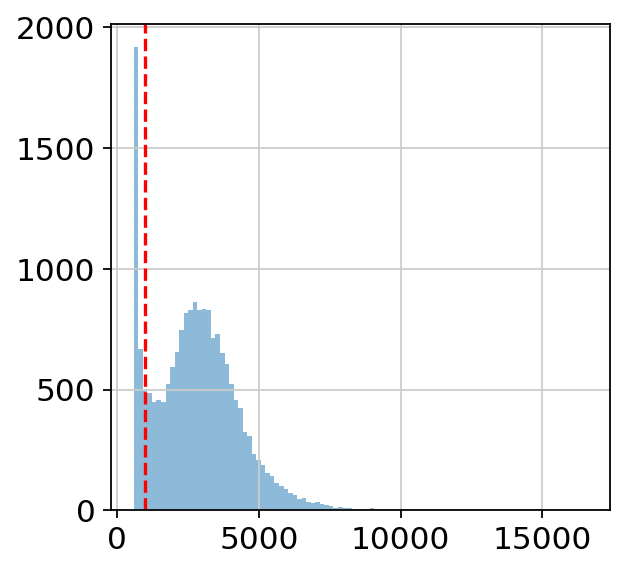

UA_Endo11460962_doublet


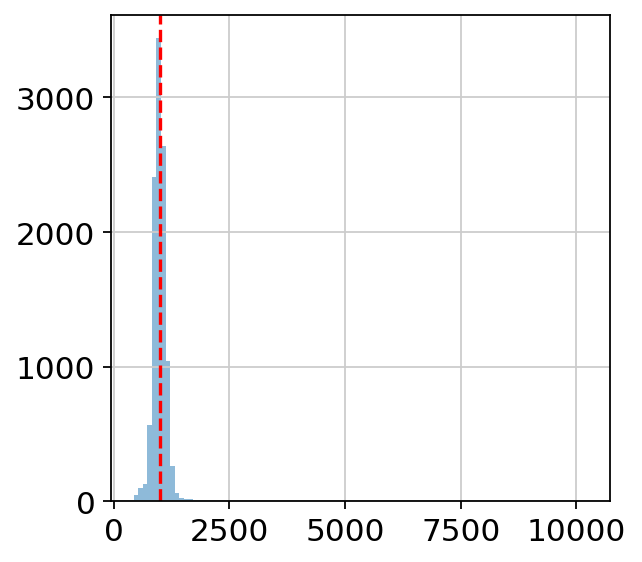

UA_Endo11282193_unassigned


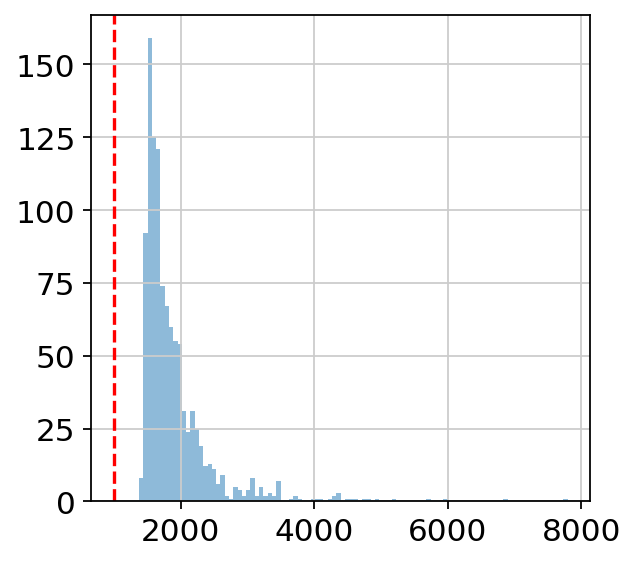

UA_Endo11460960_FX1100


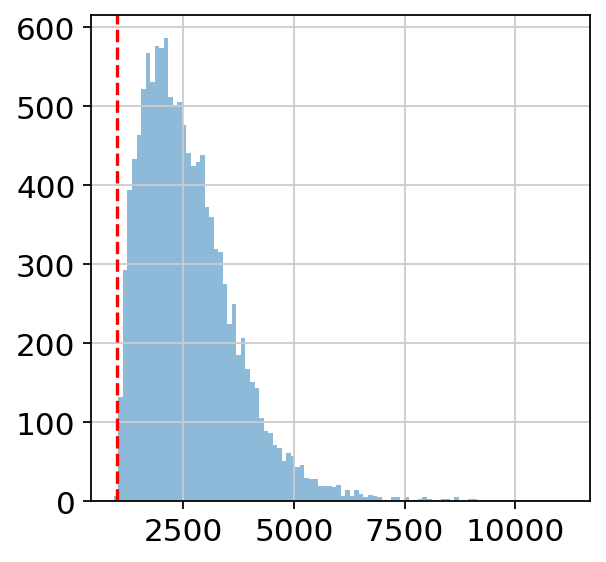

UA_Endo12061703_FX0056


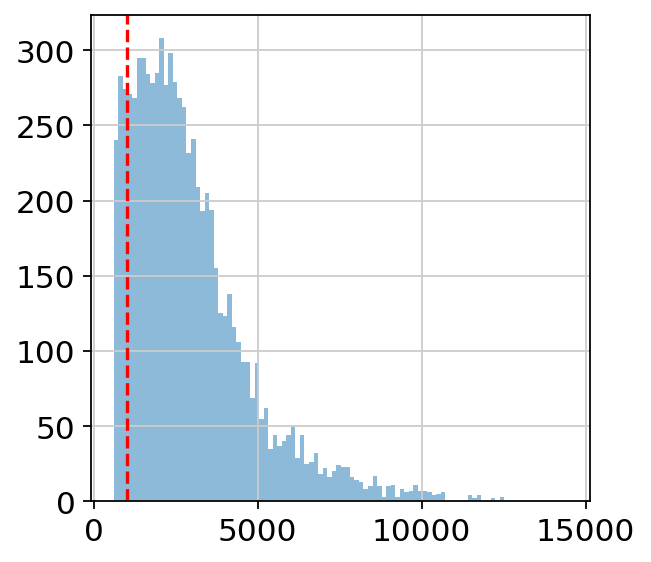

UA_Endo12865964_FX1109


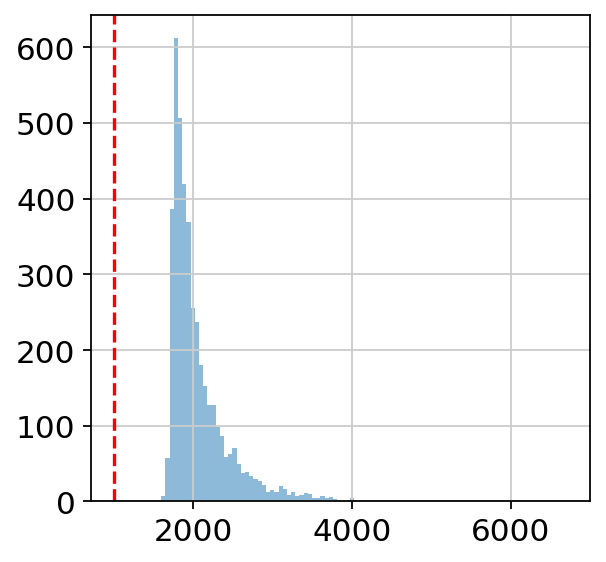

UA_Endo12821483_FX1080


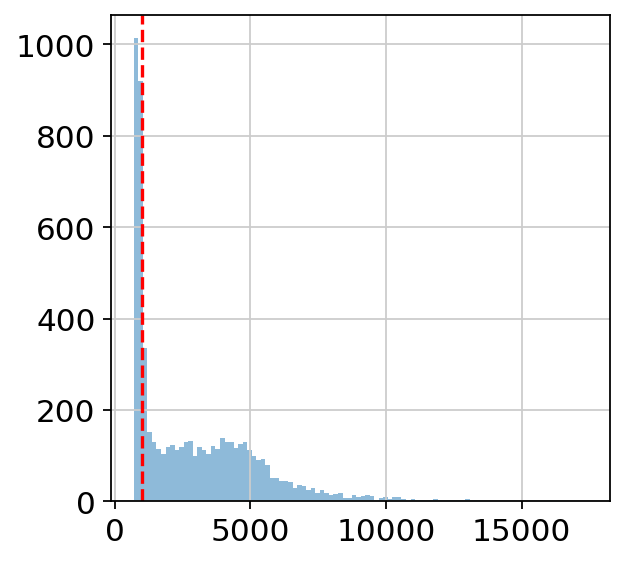

UA_Endo12296824_FX1125


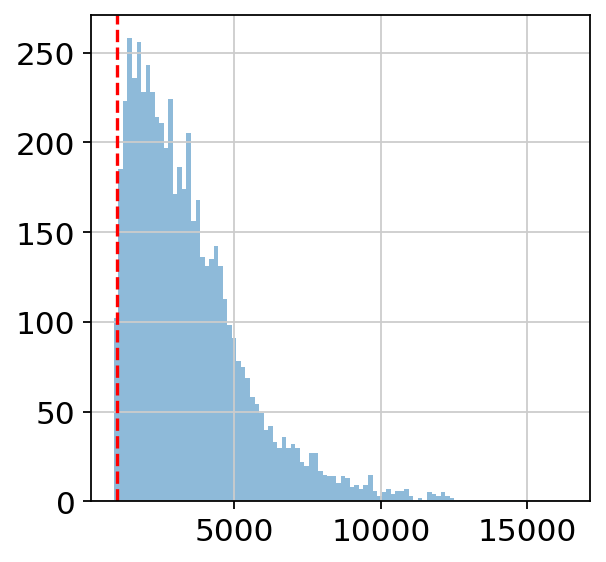

UA_Endo12821480_doublet


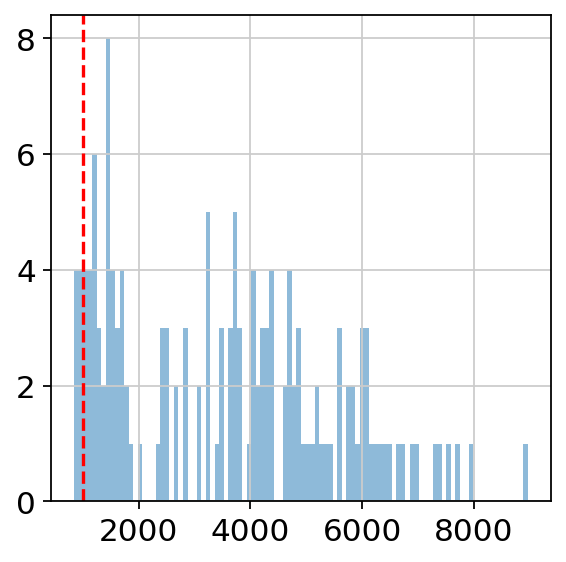

UA_Endo12296824_unassigned


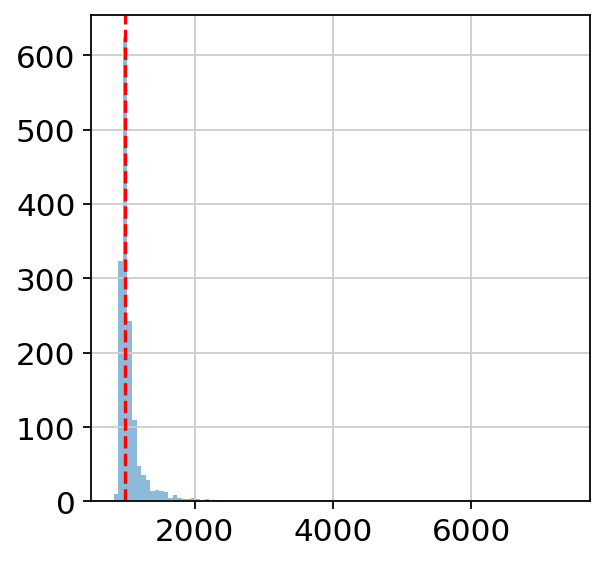

UA_Endo12269814_unassigned


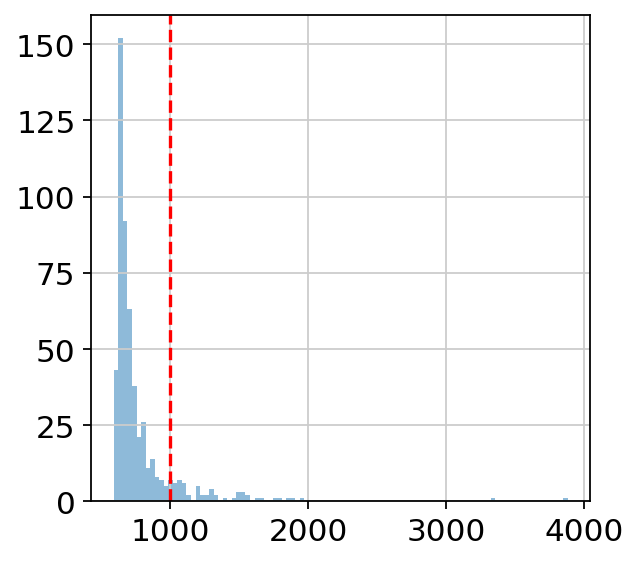

UA_Endo12865963_FX9021


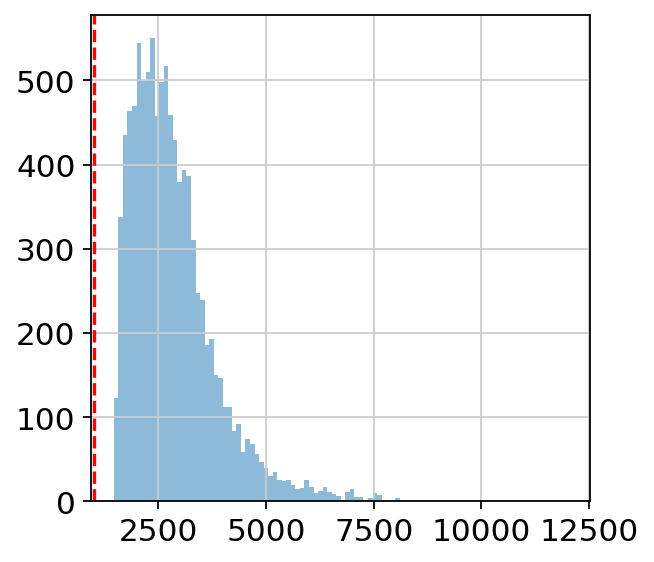

UA_Endo11596522_FX9005


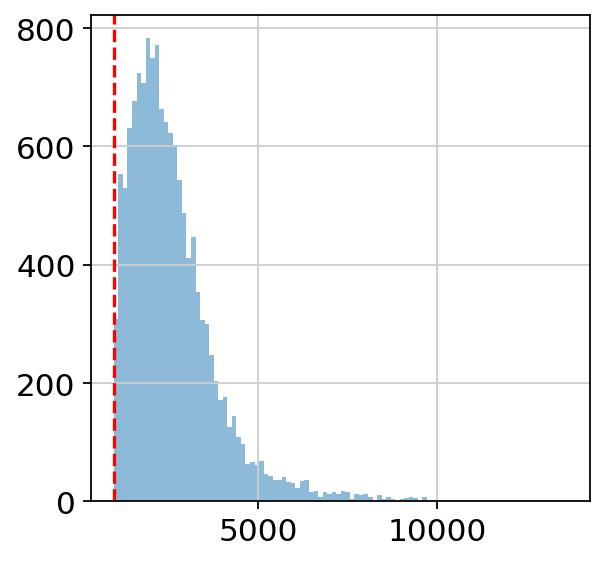

UA_Endo12604667_unassigned


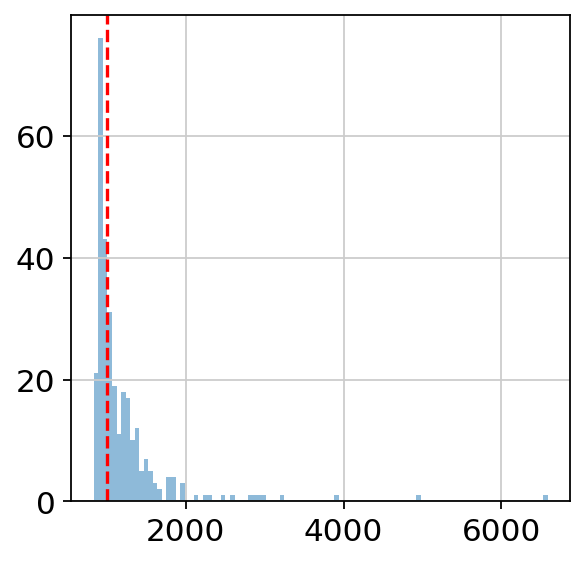

UA_Endo12449298_FX1156


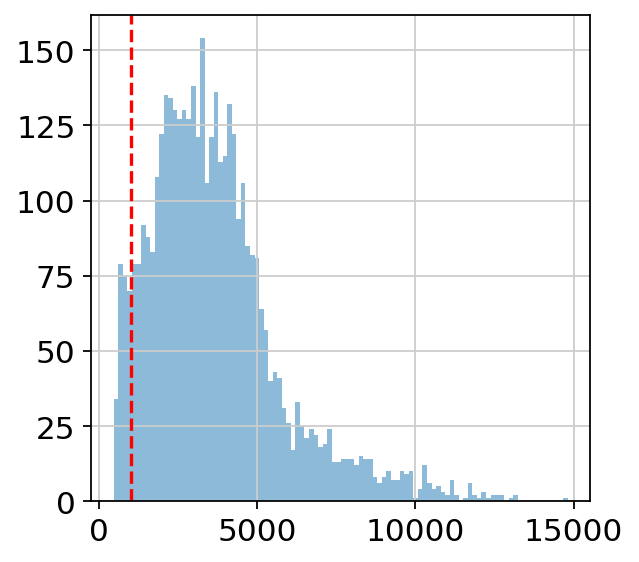

UA_Endo11460962_FX1170


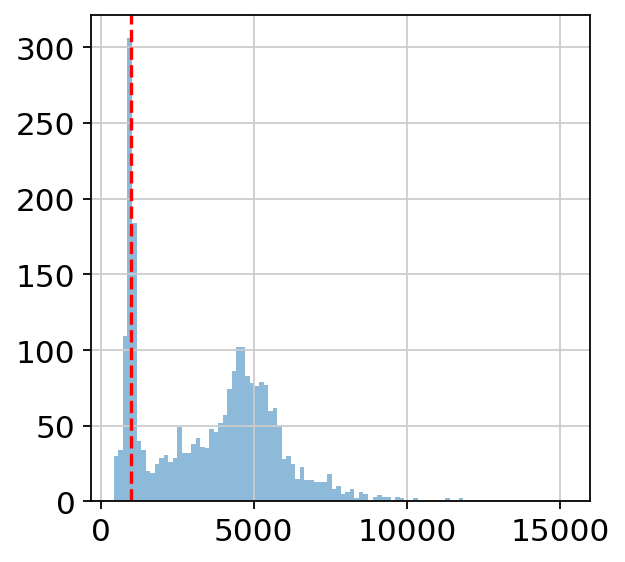

UA_Endo12821486_FX1174


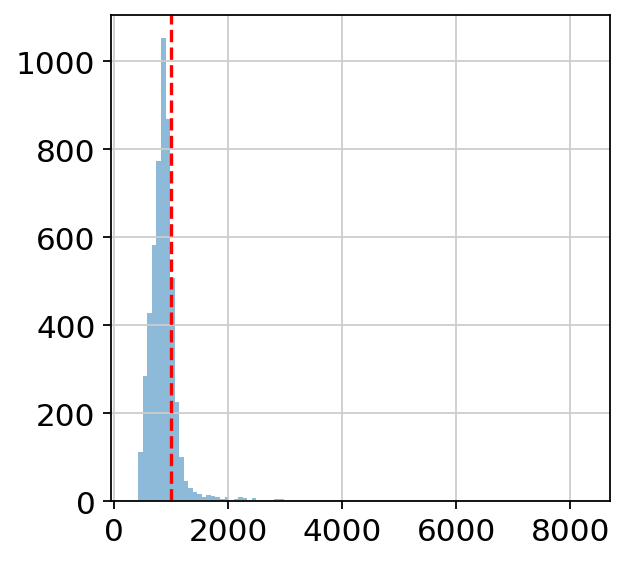

UA_Endo12449300_unassigned


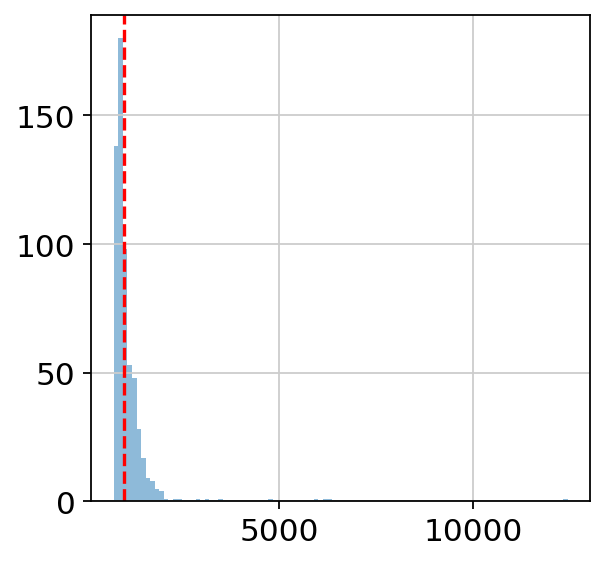

UA_Endo12061703_FX9020


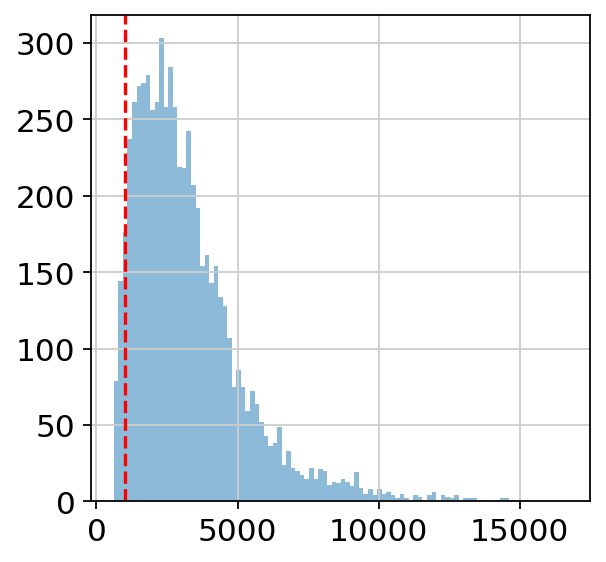

UA_Endo11460961_unassigned


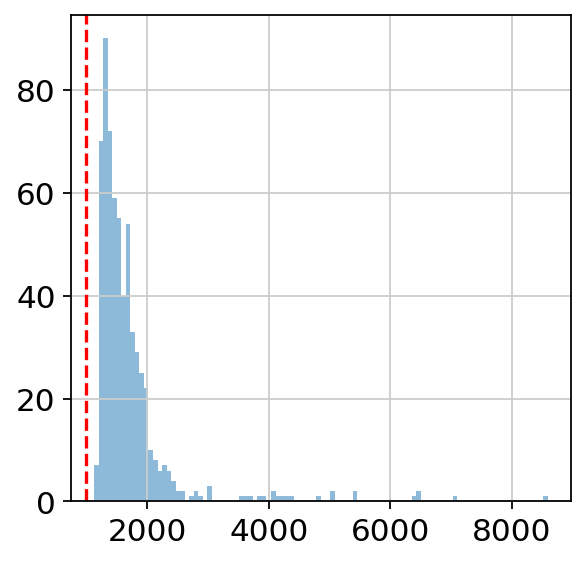

UA_Endo12865965_FX1141


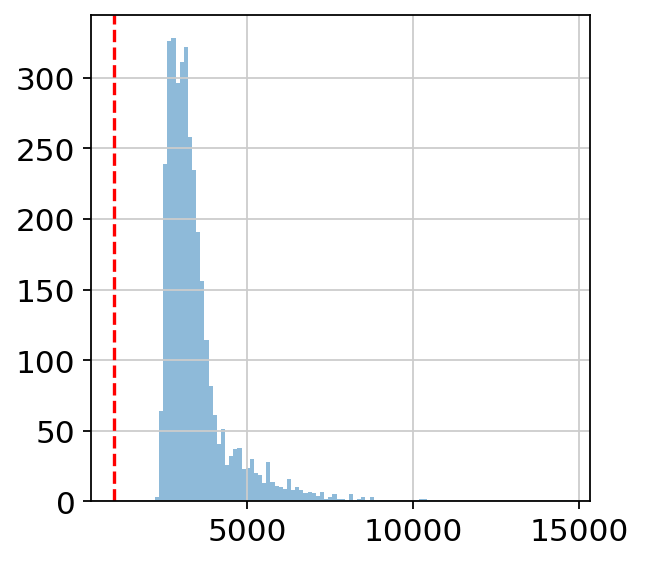

UA_Endo12296824_doublet


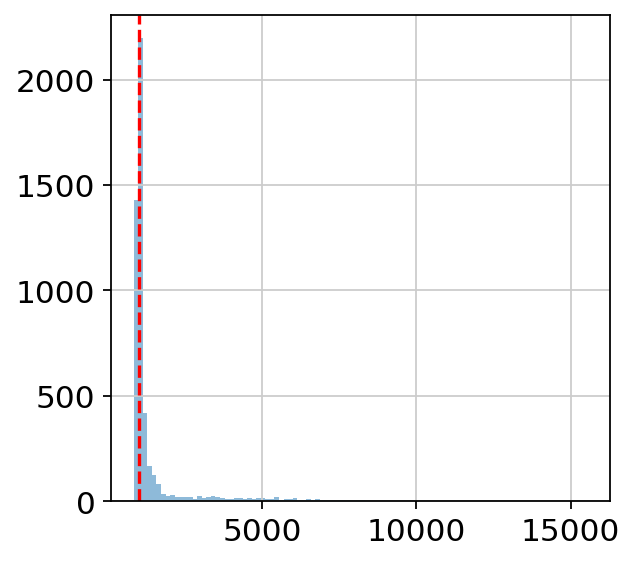

UA_Endo12296823_doublet


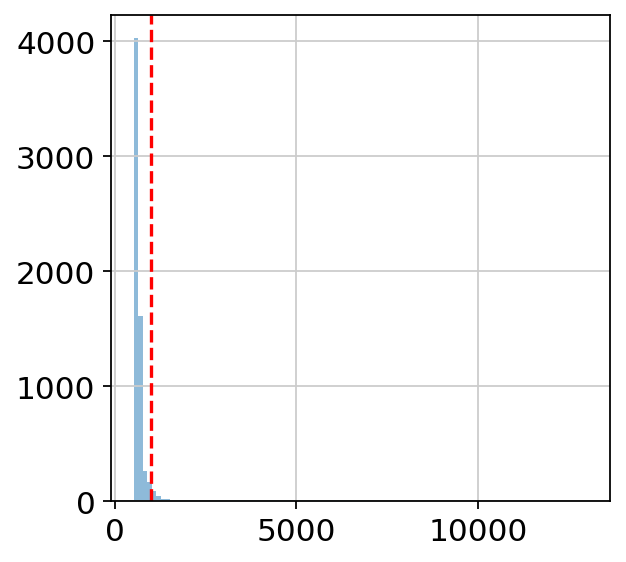

UA_Endo12865966_doublet


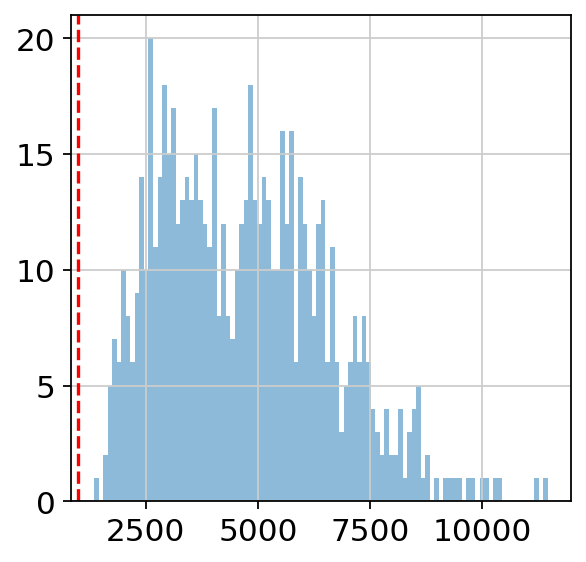

UA_Endo11173480_unassigned


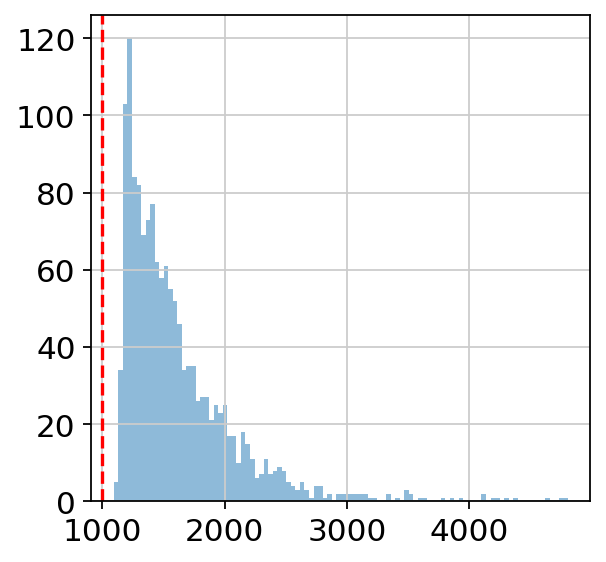

UA_Endo11173481_FX1090


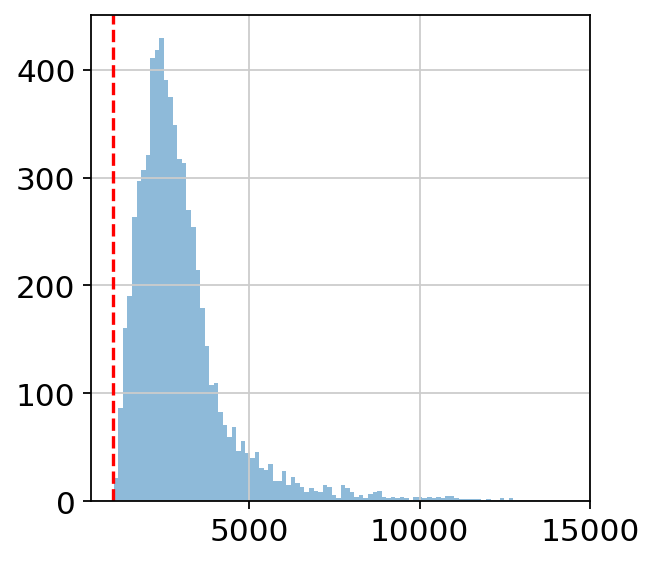

UA_Endo11460961_FX1097


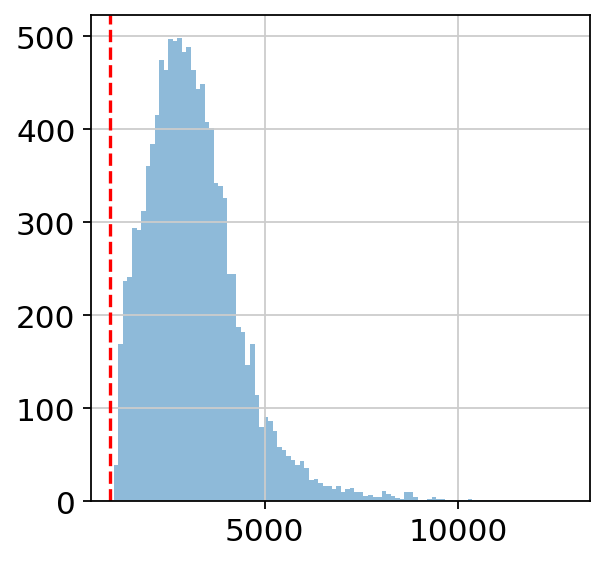

UA_Endo11596522_doublet


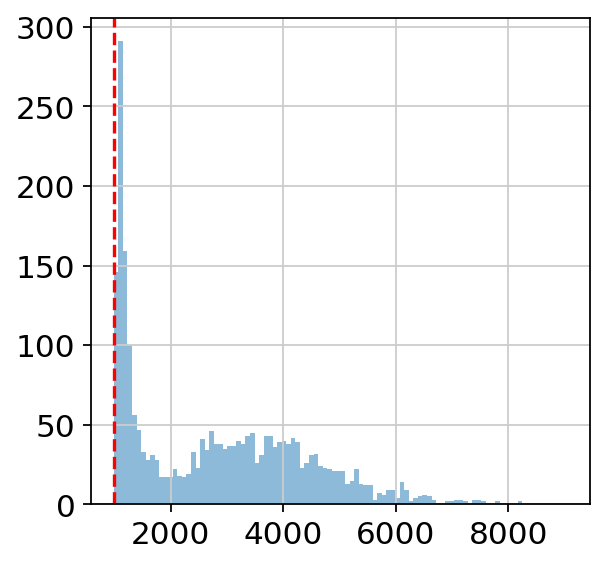

UA_Endo11173480_FX1205


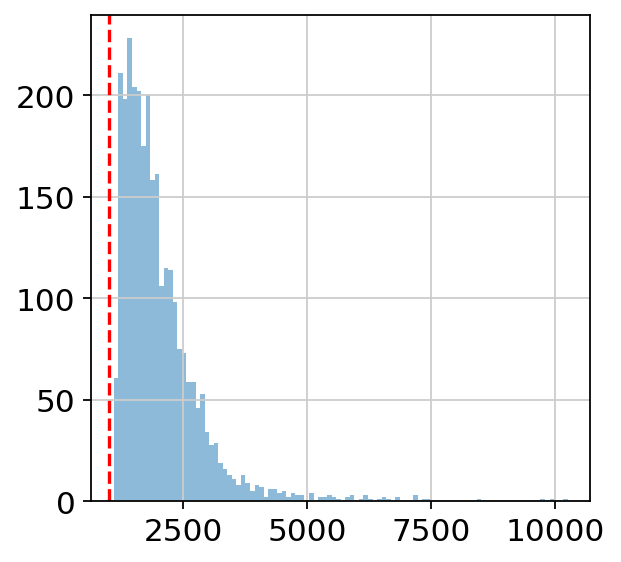

UA_Endo12894973_FX9017


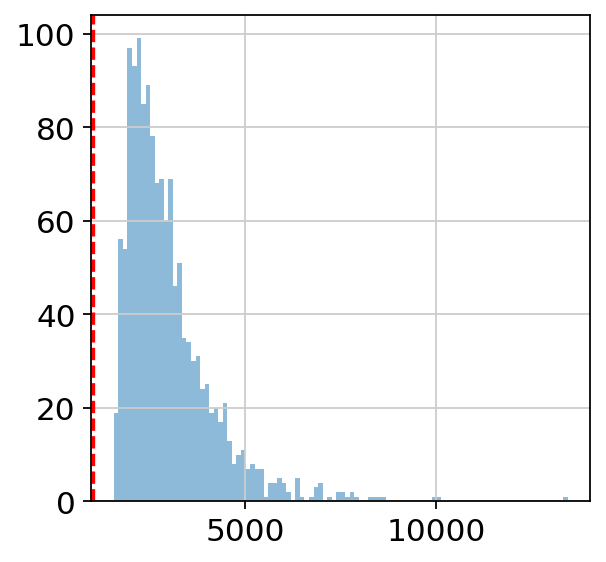

UA_Endo12061704_FX9024


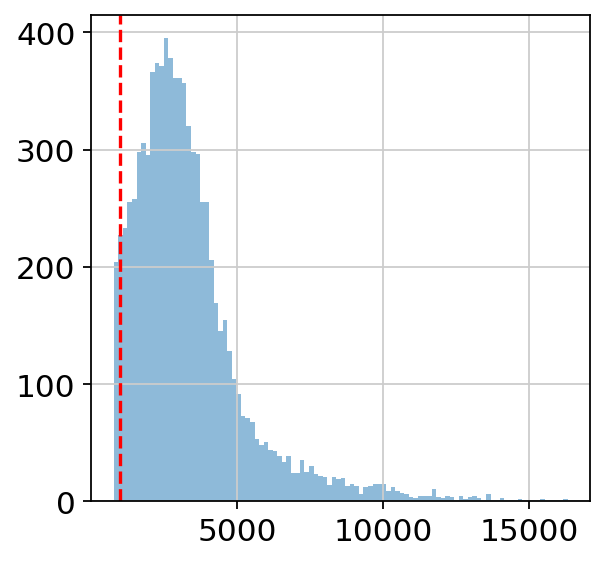

UA_Endo12449301_unassigned


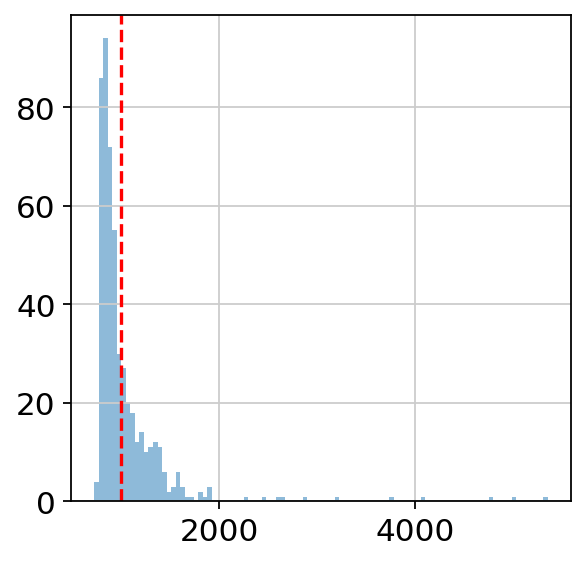

UA_Endo12269810_doublet


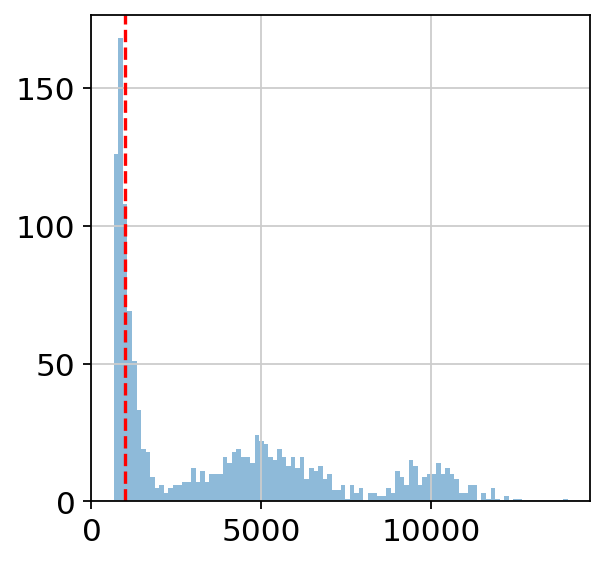

UA_Endo12865960_FX9013


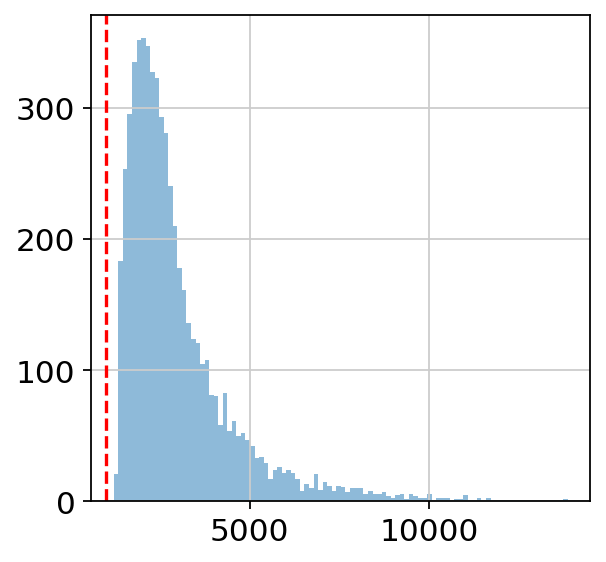

UA_Endo12865963_doublet


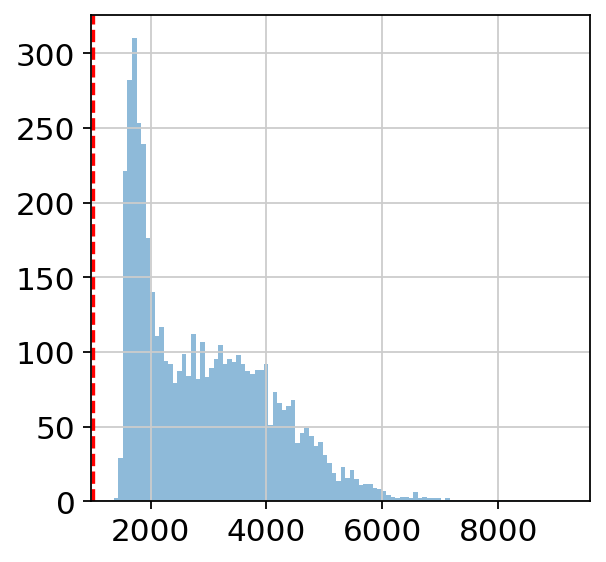

UA_Endo12296823_EX0795


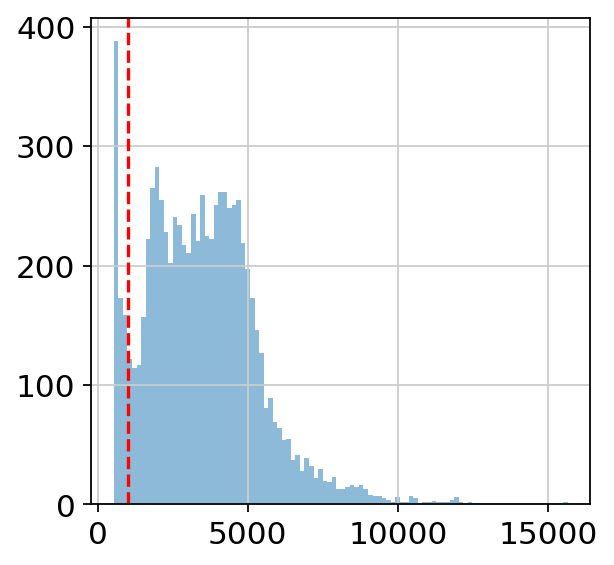

UA_Endo12061705_unassigned


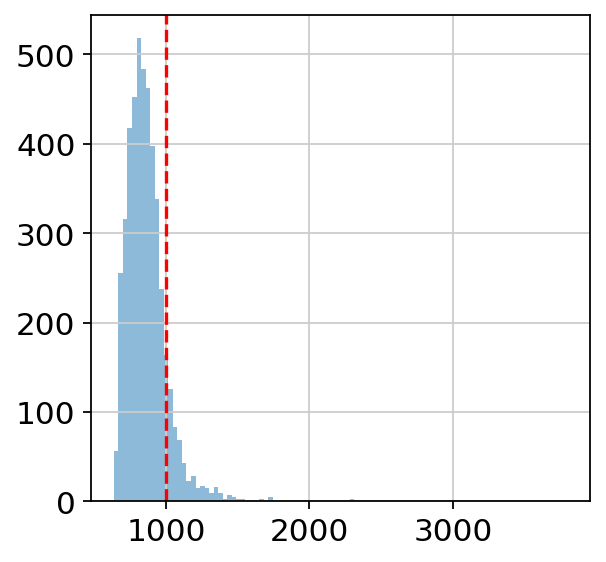

UA_Endo12269811_FX0060


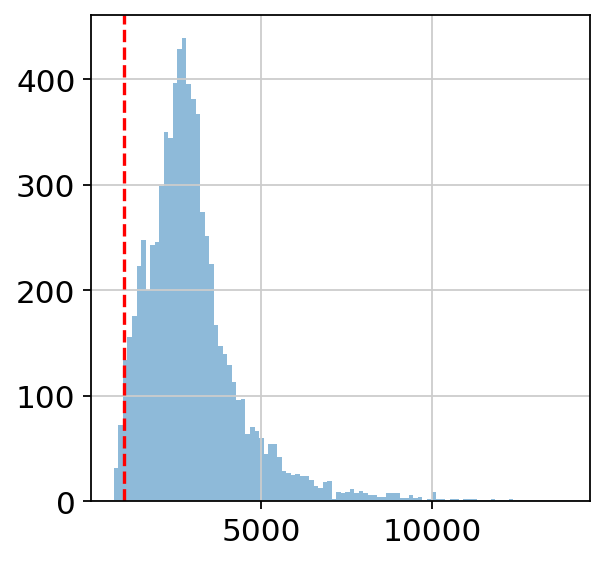

UA_Endo11460960_doublet


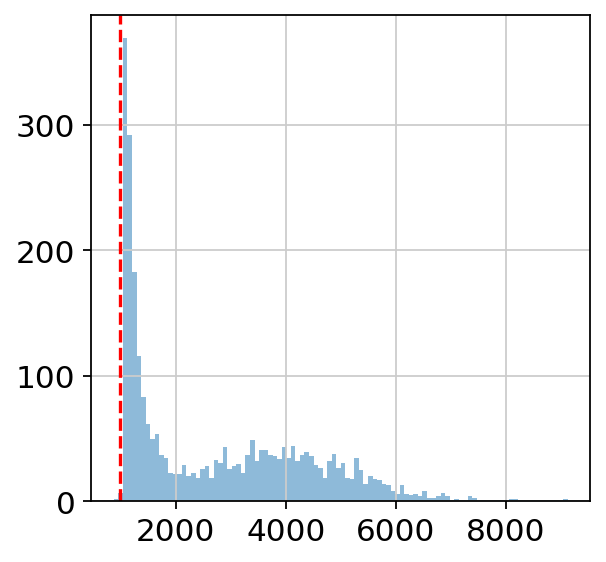

UA_Endo12865965_FX9001


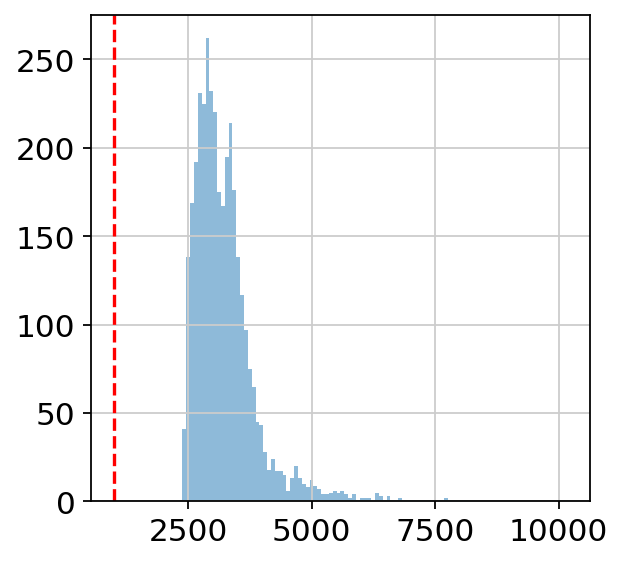

UA_Endo12865963_FX1087


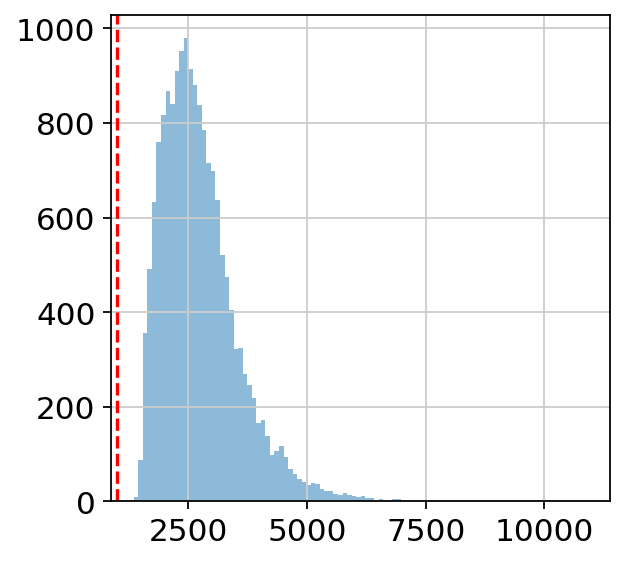

UA_Endo11460962_FX1141


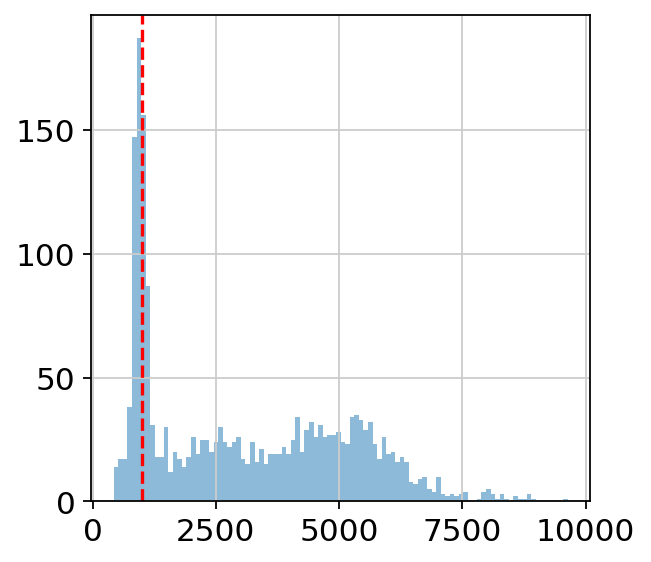

UA_Endo12061706_doublet


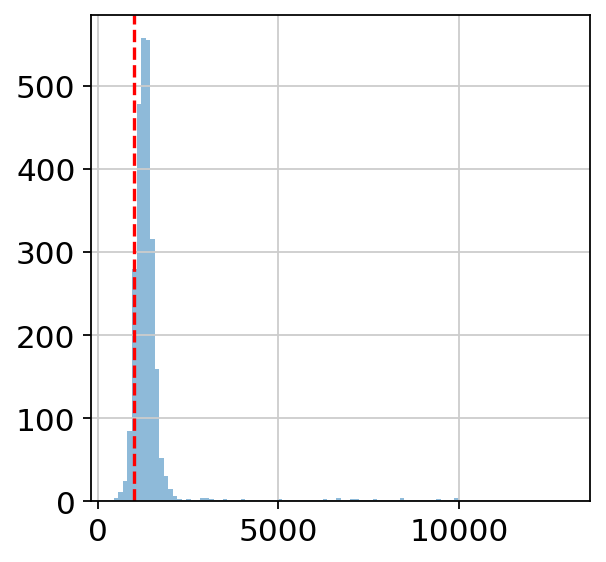

UA_Endo12894974_FX9023


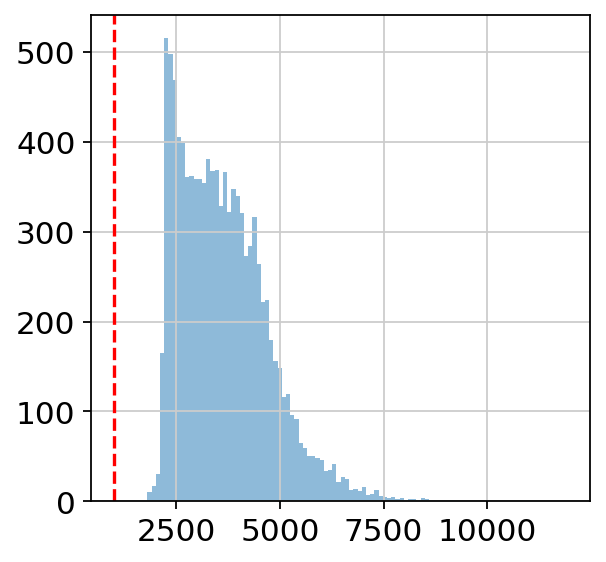

UA_Endo12821481_unassigned


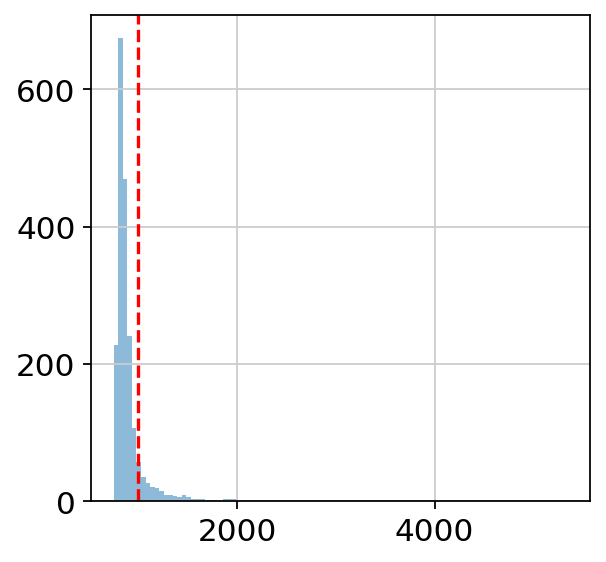

UA_Endo12449301_FX1150


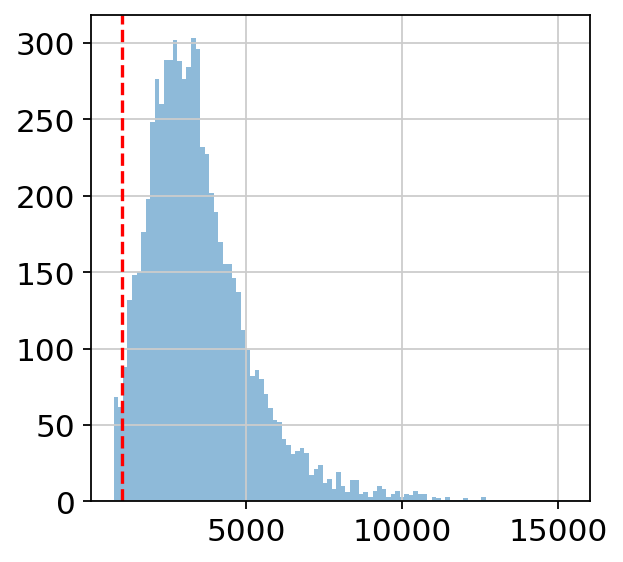

UA_Endo11173480_FX0052


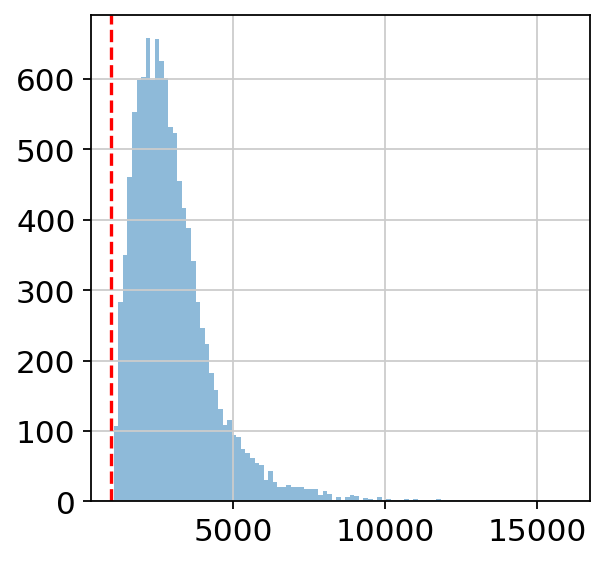

UA_Endo12061415_FX1158


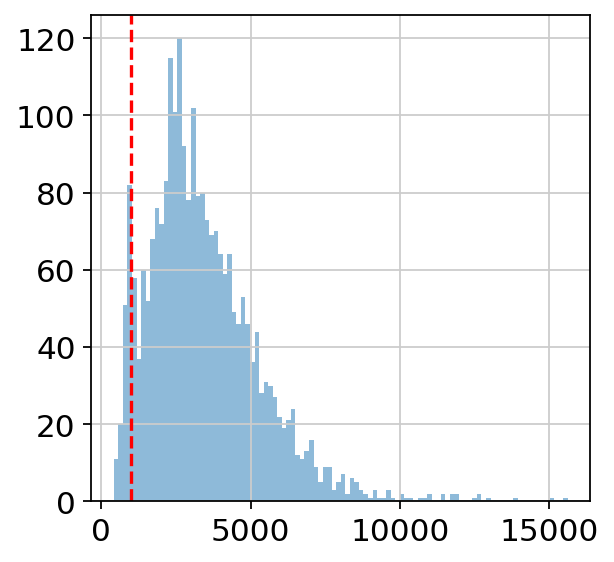

UA_Endo12061704_unassigned


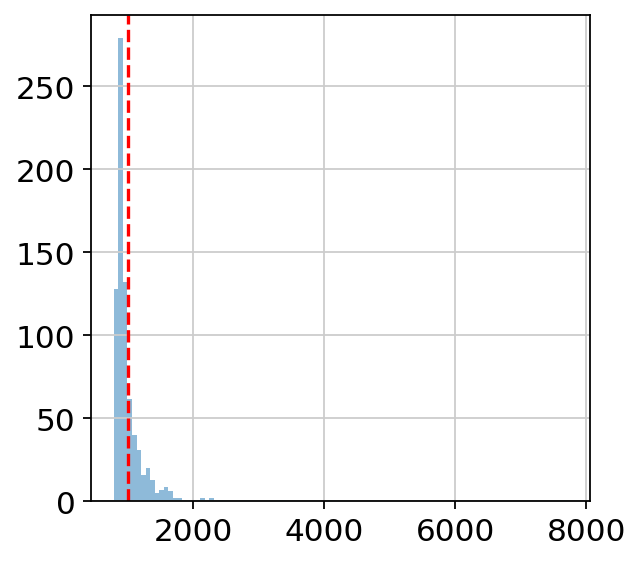

UA_Endo12865966_FX1223


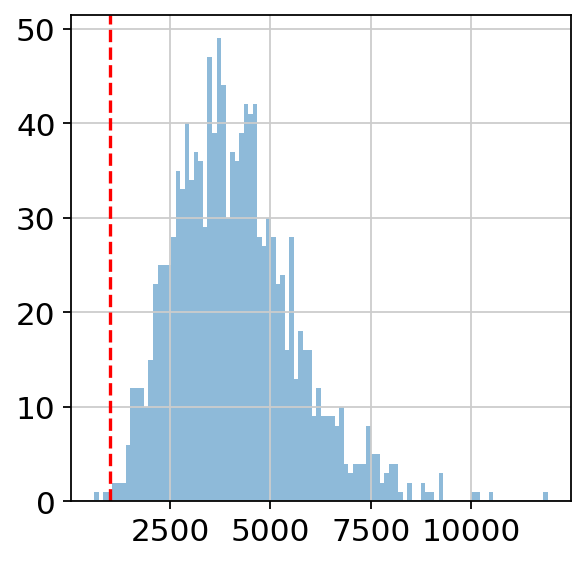

UA_Endo11460963_FX1215


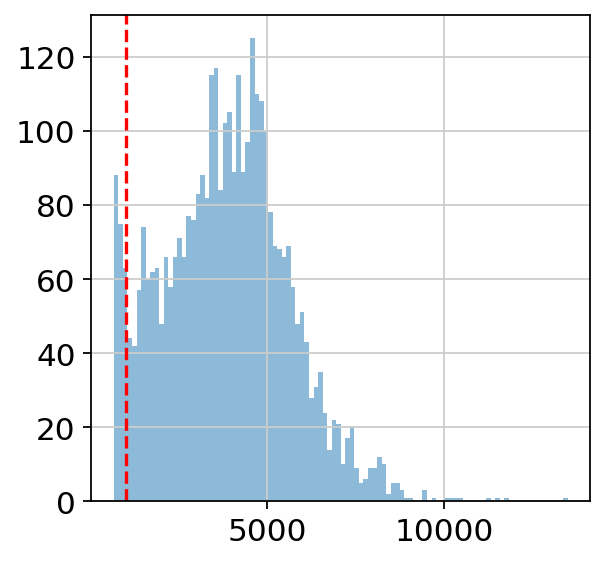

UA_Endo12449300_FX9027


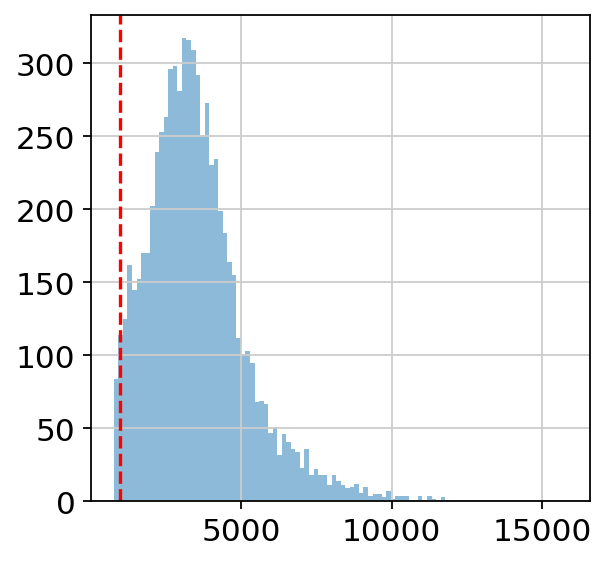

UA_Endo12865963_unassigned


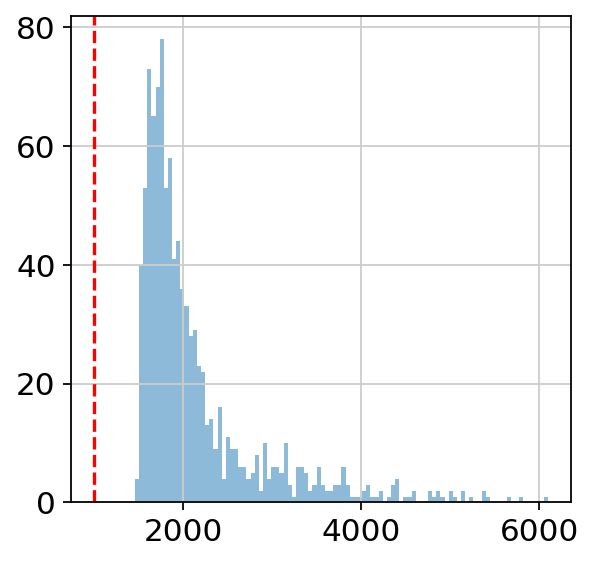

UA_Endo12269812_EX0789


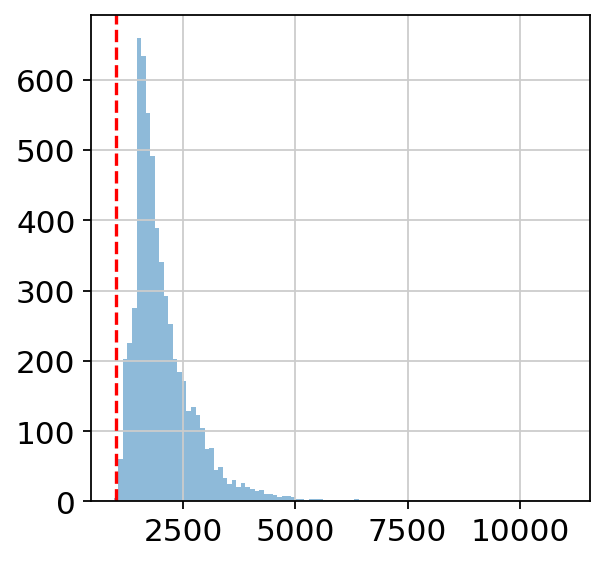

UA_Endo11460960_unassigned


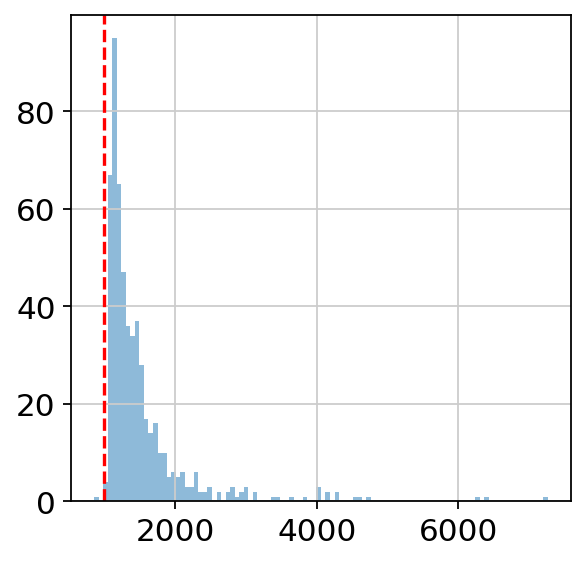

UA_Endo12604667_FX1130


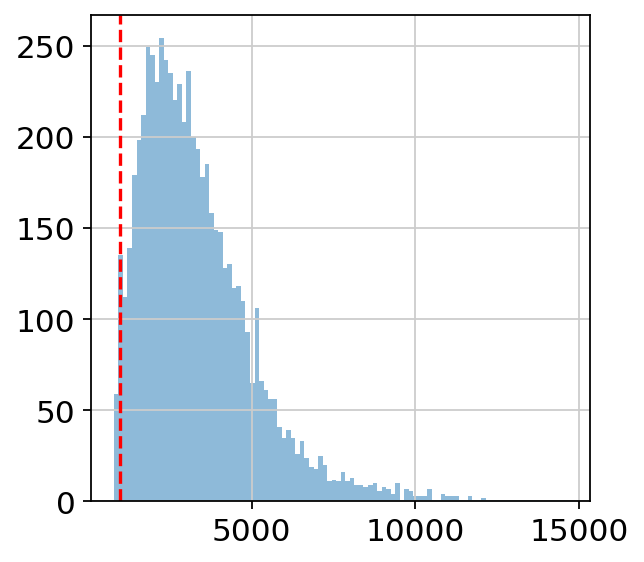

UA_Endo12061703_unassigned


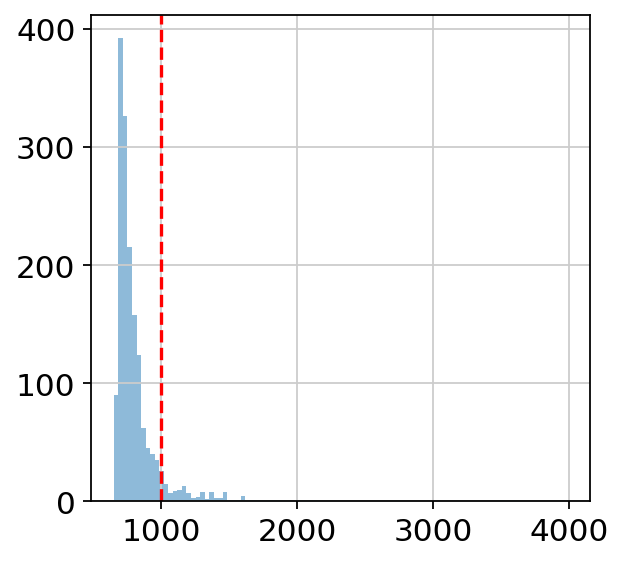

UA_Endo12865960_doublet


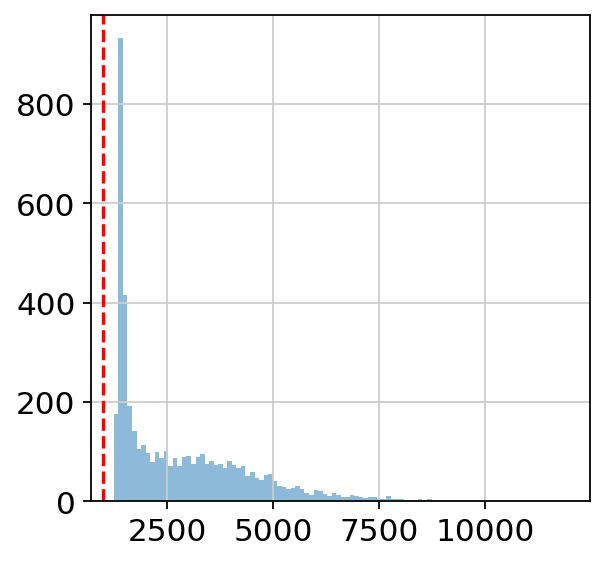

UA_Endo12269814_EX0661


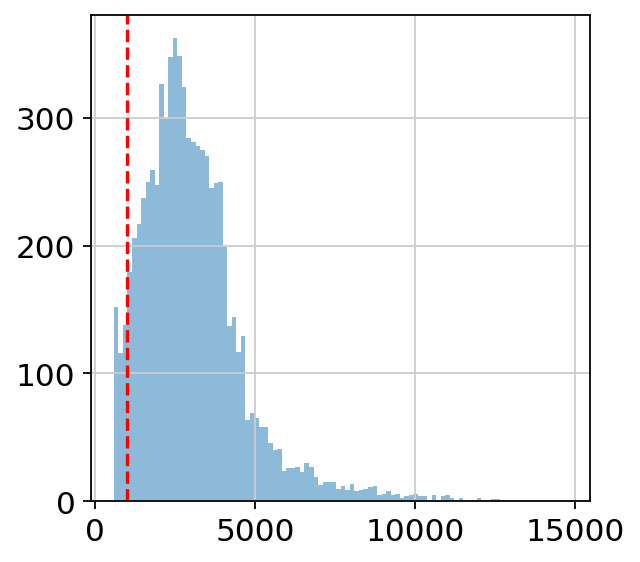

UA_Endo12449298_doublet


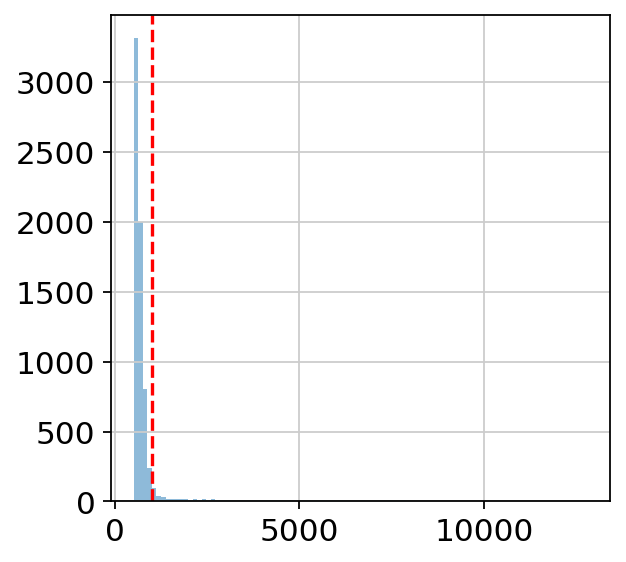

UA_Endo11460962_unassigned


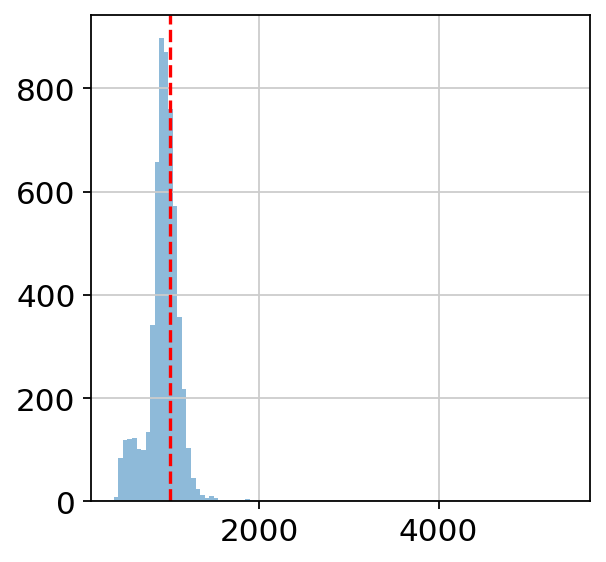

UA_Endo11460963_unassigned


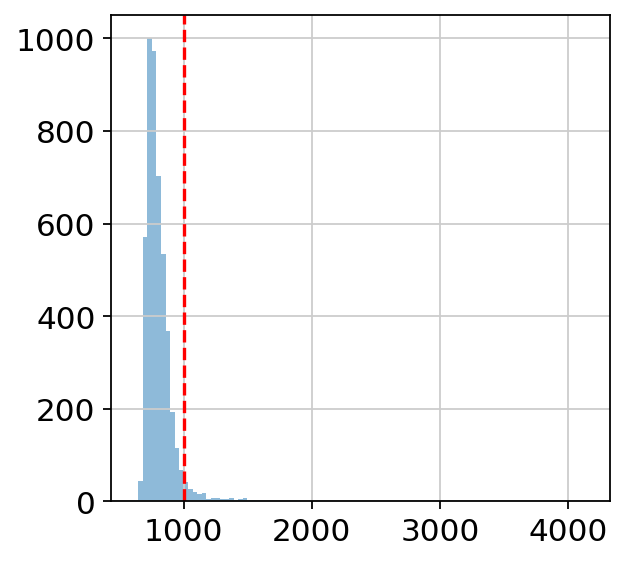

UA_Endo12061704_FX1163


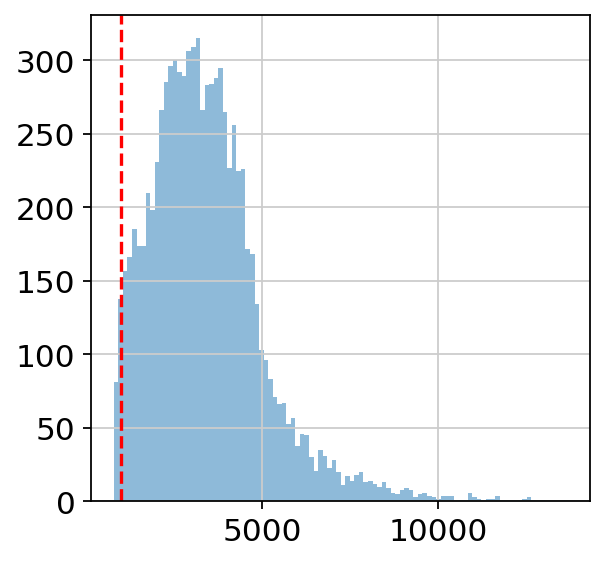

UA_Endo11282193_EX0540


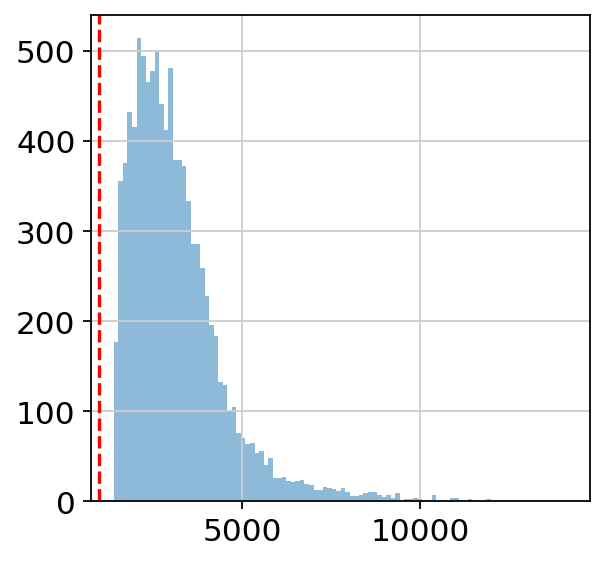

UA_Endo12269813_doublet


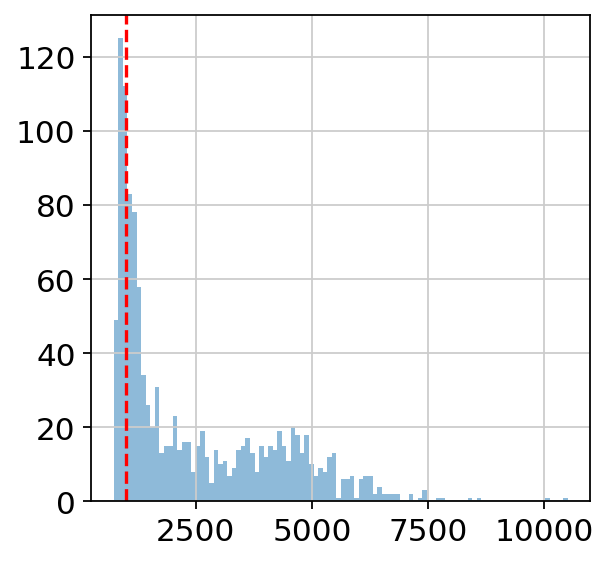

UA_Endo12449299_doublet


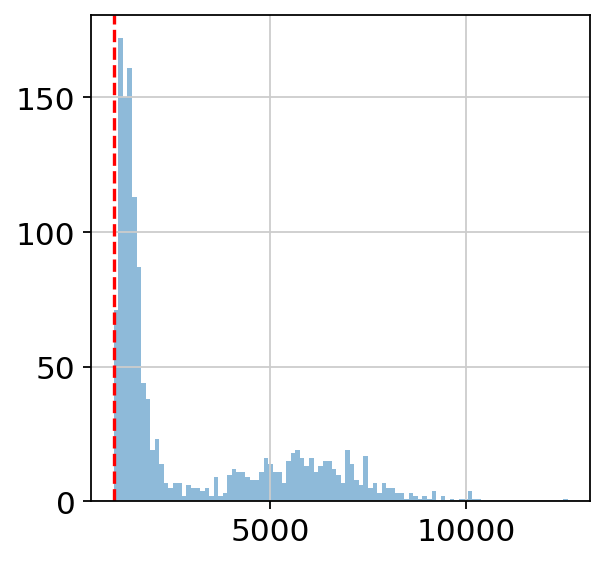

UA_Endo12061706_FX1109


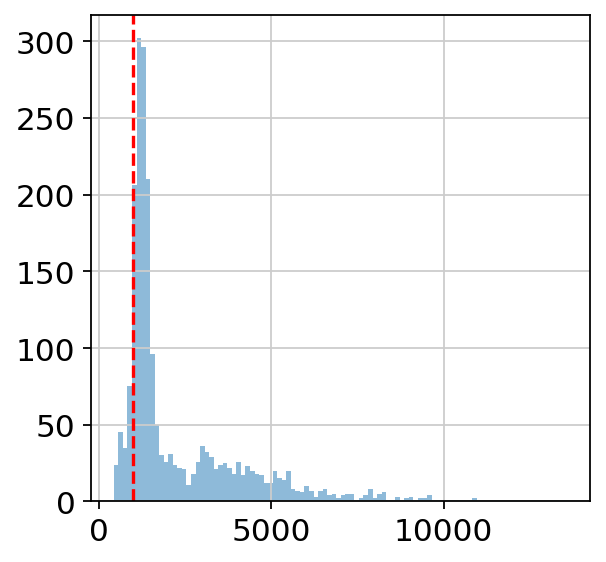

UA_Endo12821481_FX1111


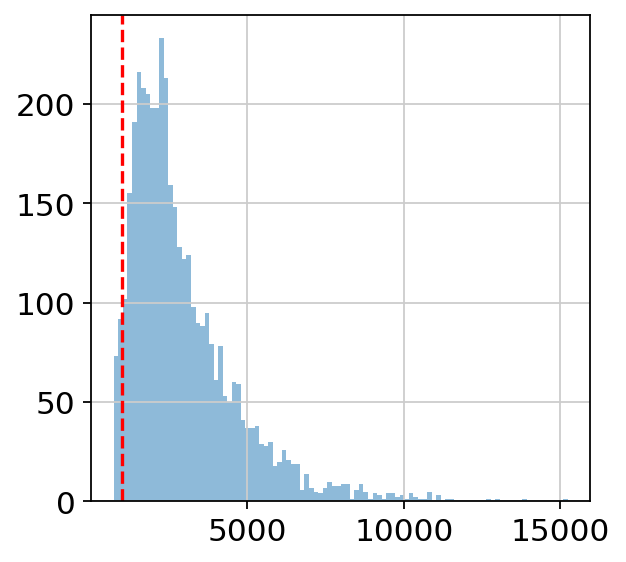

UA_Endo12269813_FX1233


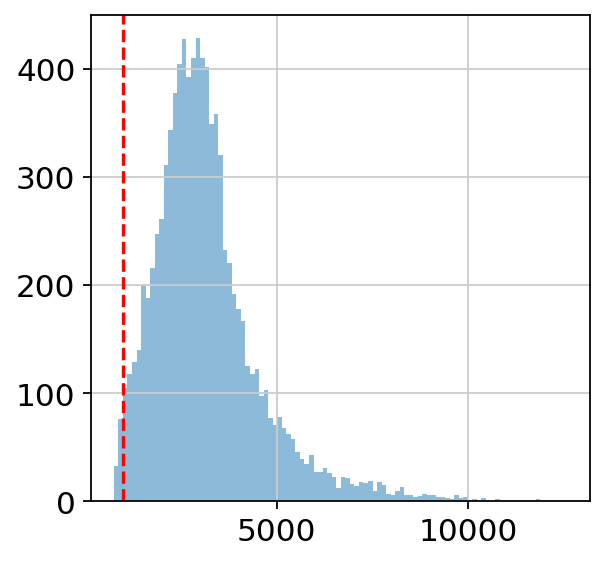

UA_Endo12821482_FX0024


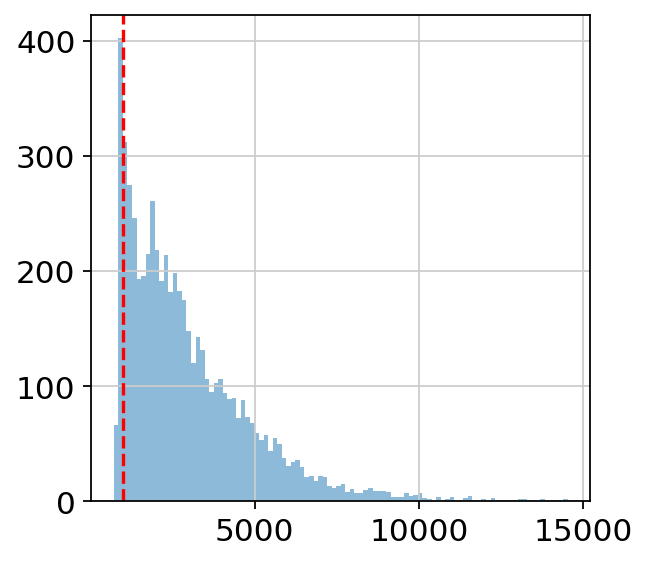

UA_Endo11460961_FX0011


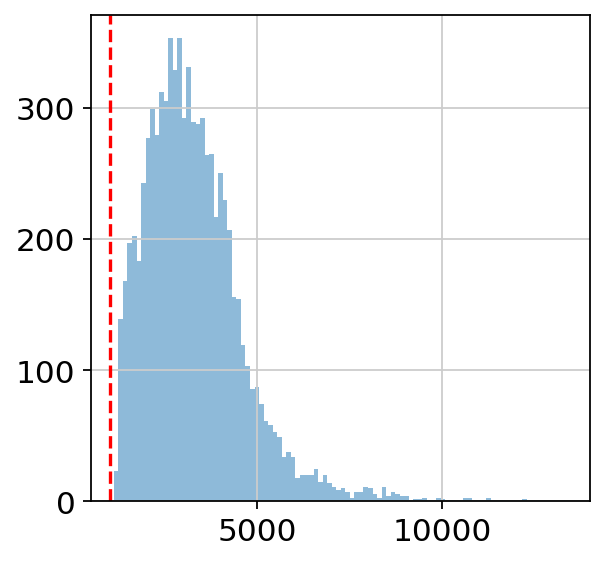

UA_Endo12061705_FX1129


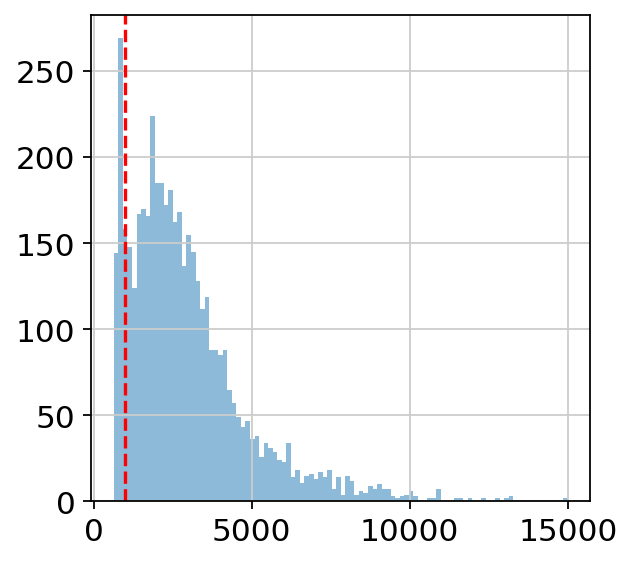

UA_Endo12821481_FX9007


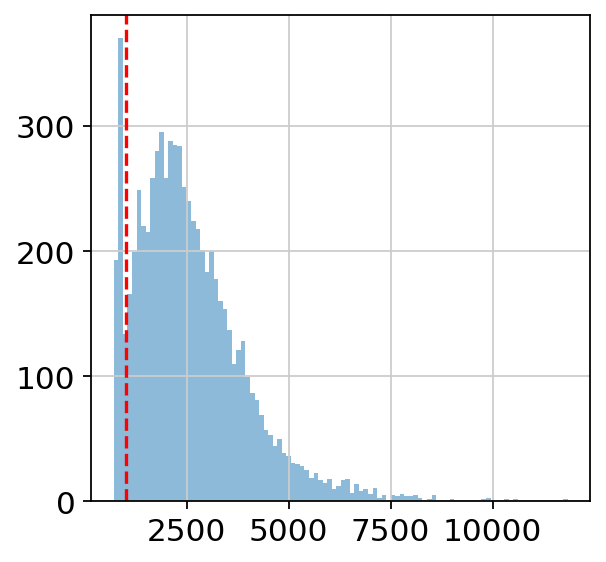

UA_Endo12865962_FX9012


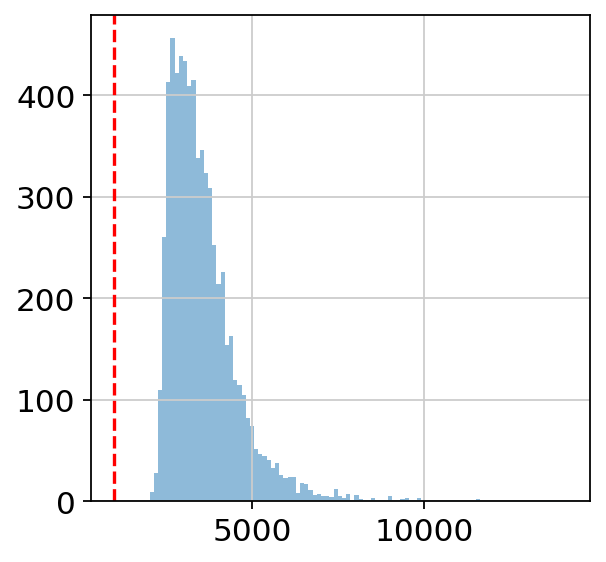

UA_Endo11460963_FX9006


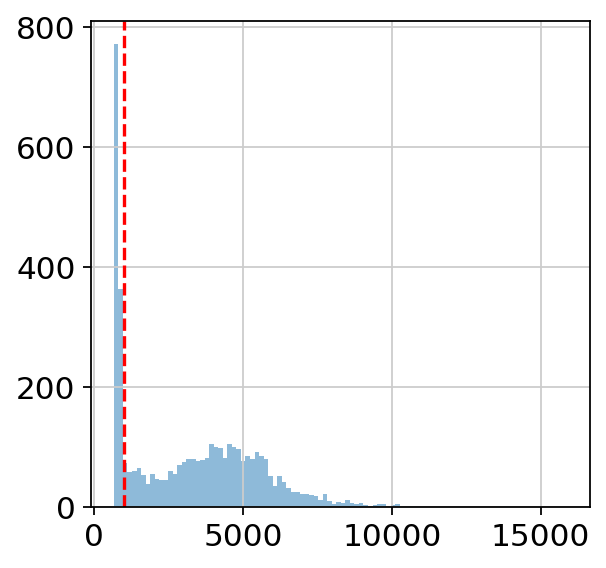

UA_Endo12449299_EX0277


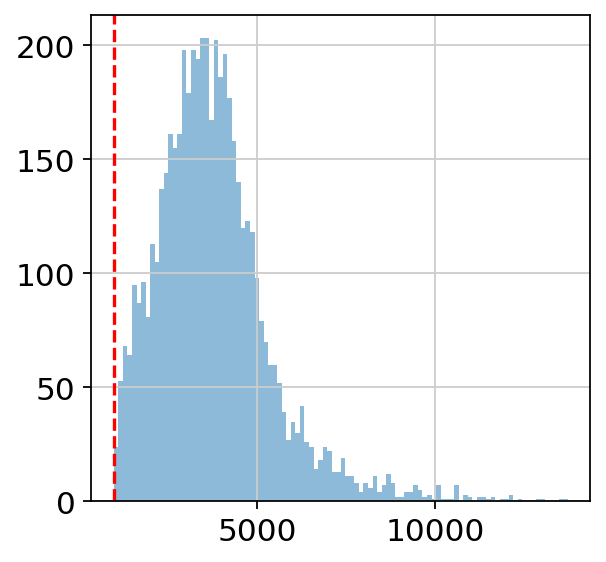

UA_Endo11460963_doublet


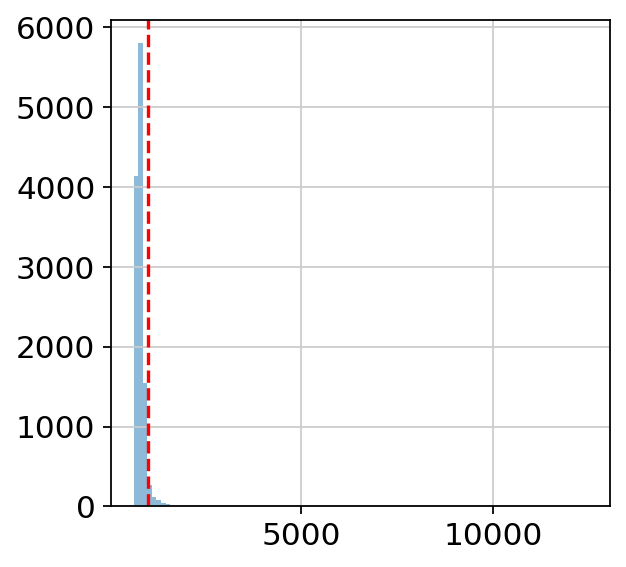

UA_Endo11596521_FX1236


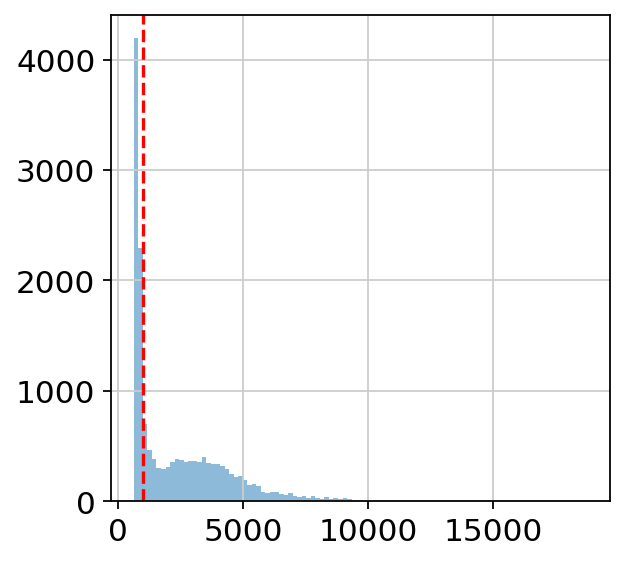

UA_Endo11596522_unassigned


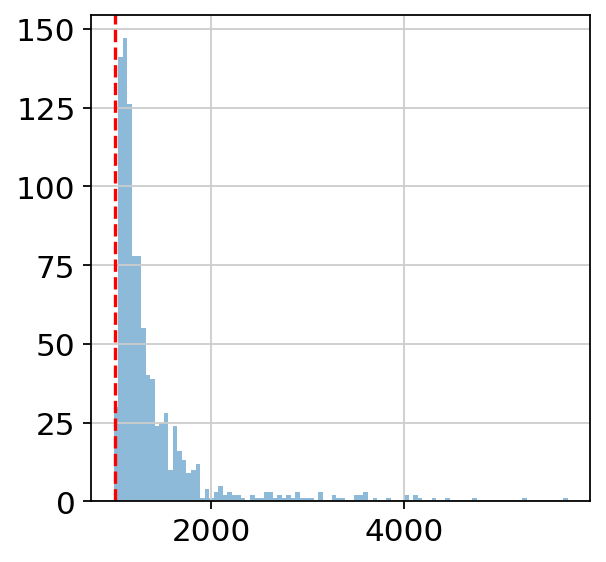

In [26]:
for sam in set(adata.obs.library):
    print(sam)
    x = adata[[ i in sam for i in adata.obs.library]]
    plt.hist(x.obs['n_genes'], bins = 100, alpha=0.5)
plt.axvline(1000, linestyle = '--', color = 'red')

for sam in set(adata.obs.Library_genotype):
    print(sam)
    x = adata[[ i in sam for i in adata.obs.Library_genotype]]
    plt.figure()
    plt.hist(x.obs['n_genes'], bins = 100, alpha=0.5)
    plt.axvline(1000, linestyle = '--', color = 'red')
    plt.show()


In [27]:
sc.pp.filter_cells(adata, min_genes=1000)

filtered out 139462 cells that have less than 1000 genes expressed


In [28]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['Library_genotype'].values.describe()

Total number of cells: 712995
Total number of genes: 34080


,counts,freqs
categories,,
UA_Endo10281923_FX1101,8187,0.011483
UA_Endo10281924_FX1101,23816,0.033403
UA_Endo10281925_FX1101,18310,0.025680
UA_Endo10281926_FX1101,16045,0.022504
UA_Endo10281927_FX1101,15079,0.021149
...,...,...
UA_Endo12894973_FX9017,1410,0.001978
UA_Endo12894973_doublet,490,0.000687
UA_Endo12894974_FX9009,12983,0.018209



### Filter cells with large % mitochondrial genes

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


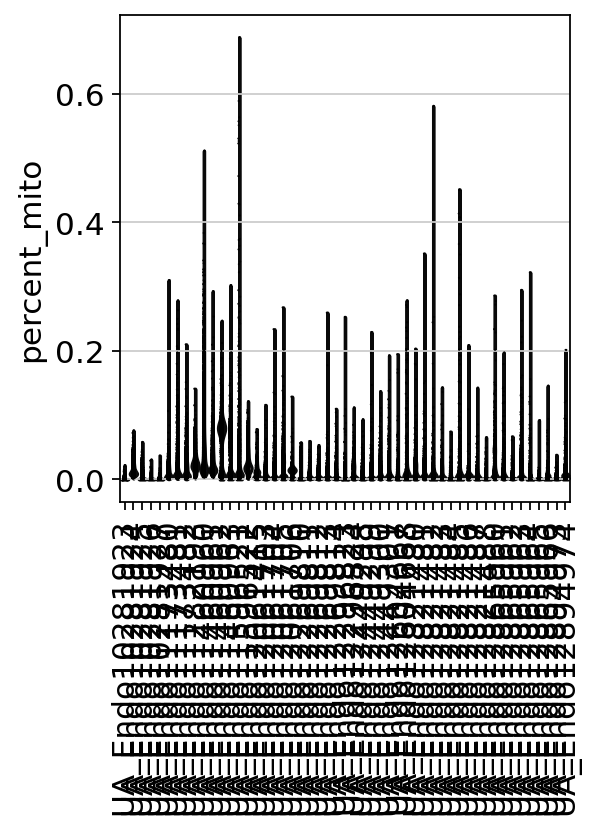

In [29]:
sc.pl.violin(adata, ['percent_mito'], groupby='library', rotation = 90) #hPGCs

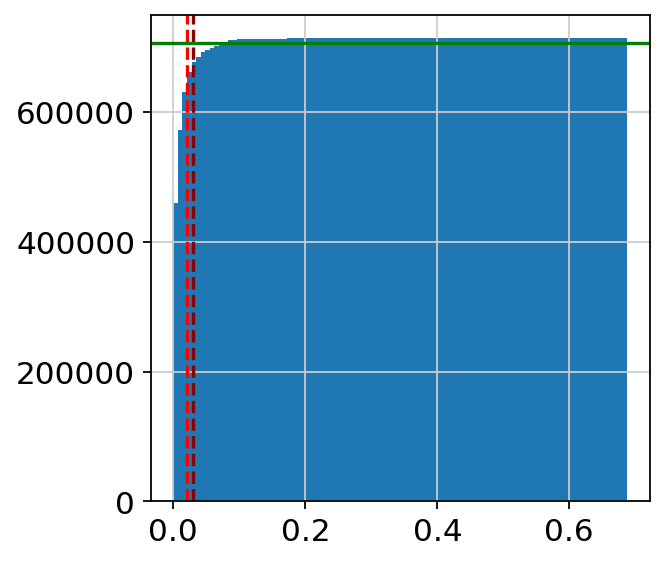

In [30]:
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.02, linestyle = '--', color = 'red')
plt.axvline(0.03, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [31]:
# >20%
adata = adata[adata.obs['percent_mito'] < 0.03, :]

In [32]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['Library_genotype'].values.describe()

Total number of cells: 667811
Total number of genes: 34080


,counts,freqs
categories,,
UA_Endo10281923_FX1101,8187,0.012259
UA_Endo10281924_FX1101,22758,0.034079
UA_Endo10281925_FX1101,18264,0.027349
UA_Endo10281926_FX1101,16044,0.024025
UA_Endo10281927_FX1101,15078,0.022578
...,...,...
UA_Endo12894973_FX9017,1410,0.002111
UA_Endo12894973_doublet,490,0.000734
UA_Endo12894974_FX9009,12909,0.019330


### Remove cells with low counts high mito combo

In [33]:
# x = [ int(i) < 1500 for i in adata.obs['n_counts']]
# adata.obs['low_ncounts'] = [ str(i) for i in x ]

# y = [ i > 0.1 for i in adata.obs['percent_mito']]
# adata.obs['high_mito'] = [ str(i) for i in y ]

# mask = [all(tup) for tup in zip(x,y)]
# adata.obs['low_ncounts_high_mito'] = [ str(i) for i in mask ]

# adata = adata[[ 'False' in i for i in adata.obs['low_ncounts_high_mito']   ]] # there is a bug so I have to iterate ... sorry 

In [34]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['Library_genotype'].values.describe()

Total number of cells: 667811
Total number of genes: 34080


,counts,freqs
categories,,
UA_Endo10281923_FX1101,8187,0.012259
UA_Endo10281924_FX1101,22758,0.034079
UA_Endo10281925_FX1101,18264,0.027349
UA_Endo10281926_FX1101,16044,0.024025
UA_Endo10281927_FX1101,15078,0.022578
...,...,...
UA_Endo12894973_FX9017,1410,0.002111
UA_Endo12894973_doublet,490,0.000734
UA_Endo12894974_FX9009,12909,0.019330


In [35]:
adata.obs['genotype'].value_counts()

FX1101        80331
doublet       45423
unassigned    31646
FX1087        20466
FX9006        19958
              ...  
FX1074         2075
FX9010         1836
FX9017         1410
FX9016         1383
FX1174          882
Name: genotype, Length: 72, dtype: int64

In [36]:
adata = adata[[ i not in ['doublet'] for i in adata.obs.genotype ]]
adata = adata[[ i not in ['unassigned'] for i in adata.obs.genotype ]]

### Filter genes expressed in less than 5 cells

In [37]:
sc.pp.filter_genes(adata, min_cells=5)

filtered out 551 genes that are detected in less than 5 cells


Trying to set attribute `.var` of view, copying.


In [38]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 590742
Total number of genes: 33529


### Identify cells behaving like cc genes
Per genes analysis: identify genes behaving like known cell cycle genes

In [39]:
# bdata = adata.copy()
# # Normalize total counts per cell
# sc.pp.normalize_per_cell(bdata, counts_per_cell_after=1e4)
# # Logarithmize the data matrix
# sc.pp.log1p(bdata)

In [40]:
# # Extract highly variable genes
# sc.pp.highly_variable_genes(bdata)
# highly_variable_genes = bdata.var["highly_variable"]
# bdata = bdata[:, highly_variable_genes]

In [41]:
# # Traspose matrix for a GENE-centered analysis
# bdata = bdata.copy().T
# bdata.X.shape

In [42]:
# # Scale data to unit variance and zero mean
# sc.pp.scale(bdata, max_value=10)

# # Scatter plot in PCA coordinates
# sc.tl.pca(bdata)
# bdata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
# # Plot the variance ratio
# sc.pl.pca_variance_ratio(bdata, log=True, save='_ccg_identification.pdf')

In [43]:
# num_pcs = 10
# # Compute a neighborhood graph of observations
# sc.pp.neighbors(bdata, n_pcs=num_pcs)
# # Embed the neighborhood graph using UMAP
# sc.tl.umap(bdata)
# # Cluster GENES into subgroups using louvain: resolution < 1 to find less clusters
# sc.tl.louvain(bdata, resolution=1)

In [44]:
# # Locate ccs cluster
# bdata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in bdata.obs_names]
# bdata.obs['known_cyclers'] = [ str(i) for i in  bdata.obs['known_cyclers']]
# sc.pl.umap(bdata, color=['known_cyclers', 'louvain'], color_map='OrRd',save='_ccg_identification.pdf')
# print(bdata.obs.loc[[i in ['CDK1','MKI67','CCNB2','PCNA'] for i in bdata.obs_names],'louvain'])

In [45]:
# ccgs_cl = bdata.obs.loc['CDK1',['louvain']][0]
# print("Cell cycle genes cluster is "+ccgs_cl)

### Flag ccgs

In [46]:
# # Add unstructured dict-like annotation for ccgs
# adata.uns['ccgs'] = list(bdata.obs[bdata.obs['louvain']==ccgs_cl].index)

In [47]:
# # Move plots
# MovePlots('ccg_identification','ccg_identification')

# Score cell cycle

In [48]:
s_genes = [x.strip() for x in open('S_genes.tsv')]
g2m_genes = [x.strip() for x in open('G2M_genes.tsv')]

s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [49]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    377 total control genes are used. (0:00:32)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    502 total control genes are used. (0:00:33)
-->     'phase', cell cycle phase (adata.obs)


# Save raw counts

In [53]:
adata = adata[[ i not in ['doublet', 'unassigned'] for i in adata.obs.genotype ]]

In [54]:
adata.write('/nfs/team292/lg18/endometriosis/raw_objects/nuclei_rawcounts_decontX.h5ad')

In [55]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
print('Total number of donors: {:d}'.format(len(set(adata.obs.genotype))))
print('Total number of samples: {:d}'.format(len(set(adata.obs['sample']))))
print('Total number of libraries: {:d}'.format(len(set(adata.obs['library']))))

Total number of cells: 590742
Total number of genes: 33529
Total number of donors: 70
Total number of samples: 88
Total number of libraries: 51


In [56]:
adata.obs['genotype'].value_counts()

FX1101    80331
FX1087    20466
FX9006    19958
FX1170    16532
EX0661    16016
          ...  
FX1074     2075
FX9010     1836
FX9017     1410
FX9016     1383
FX1174      882
Name: genotype, Length: 70, dtype: int64